In [1]:
import sys
sys.path.append('../../../')
import torch
from matplotlib import pyplot as plt
from tifffile import imread, imwrite
from sklearn.cluster import KMeans
import numpy as np
from glob import glob
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [6]:
path="/group/jug/Sheida/pancreatic beta cells/download/high_c1/"
patch_size = 64
model = torch.load("/home/sheida.rahnamai/GIT/HDN/examples/Pixel_Noise/Convallaria/Contrastive_new_dataloader/model/Contrastive_MAE_best_vae.net")
model.mode_pred=True
model.eval()
model.to(device)

LadderVAE(
  (first_bottom_up): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): BottomUpDeterministicResBlock(
      (res): ResidualBlock(
        (block): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ELU(alpha=1.0)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): Dropout2d(p=0.2, inplace=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ELU(alpha=1.0)
          (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): Dropout2d(p=0.2, inplace=False)
        )
      )
    )
  )
  (top_down_layers): ModuleList(
    (0-1): 2 x TopDownLayer(
      (deterministic_block): Sequential(
        (0): TopDownDeterministicResBlock(
          (pre_conv): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), 

In [7]:
centre_size = 4
n_channel = 32
hierarchy_level = 3

In [8]:
def get_normalized_tensor(img,model,device):
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images

In [9]:
def load_data(dir):
    return imread(dir)

In [10]:
data_dir = "/localscratch/testing/img/"
golgi = get_normalized_tensor(load_data(data_dir+'class1/*.tif'), model, device)
mitochondria = get_normalized_tensor(load_data(data_dir+'class2/*.tif'), model, device)
granule = get_normalized_tensor(load_data(data_dir+'class3/*.tif'), model, device)
class_type = [golgi, mitochondria, granule]

In [11]:
def get_mean_centre(x, i):
    if i == 3:
        return x[i][0].cpu().numpy().reshape(n_channel,-1).mean(-1)
    elif i == 4:
        return x[i][0].cpu().numpy().reshape(n_channel,-1).mean(-1)
    else:
        lower_bound = 2**(5-1-i)-int(centre_size/2)
        upper_bound = 2**(5-1-i)+int(centre_size/2)
        return x[i][0].cpu().numpy()[:,lower_bound:upper_bound,lower_bound:upper_bound].reshape(n_channel,-1).mean(-1)

In [12]:
def get_mus(model, z):
    n_features = n_channel * hierarchy_level
    data = np.zeros((n_features,))
    model.mode_pred=True
    model.eval()
    with torch.no_grad():
        model.to(device)
        z = z.to(device=device, dtype=torch.float)
        z = z.reshape(1,1,patch_size,patch_size)
        with torch.no_grad():
                sample = model(z, z, z,model_layers=[0,1,2])
                mu = sample['mu']
                for i in range(hierarchy_level):
                    data[i*n_channel:(i+1)*n_channel] = get_mean_centre(mu, i)
                data = data.T.reshape(-1,n_features)
    return data

In [22]:
def get_sigmas(model, z):
    n_features = n_channel * hierarchy_level
    data = np.zeros((n_features,))
    model.mode_pred=True
    model.eval()
    with torch.no_grad():
        model.to(device)
        z = z.to(device=device, dtype=torch.float)
        z = z.reshape(1,1,patch_size,patch_size)
        with torch.no_grad():
                sample = model(z, z, z,model_layers=[0,1,2])
                sigma = sample['logvar']
                for i in range(hierarchy_level):
                    data[i*n_channel:(i+1)*n_channel] = get_mean_centre(sigma, i)
                data = data.T.reshape(-1,n_features)
    return data

In [13]:
mu = []
mus = np.array([])   
for class_t in range(len(class_type)):
    for i in tqdm(range(len(class_type[class_t]))):
        mu.extend(get_mus(model,class_type[class_t][i]))
    mus = np.append(mus, mu).reshape(-1, 96)
    mu = []
for i in range(len(mus)):
    mus[i] = np.asarray(mus[i])

100%|██████████| 363/363 [00:08<00:00, 44.12it/s]


In [23]:
sigma = []
sigmas = np.array([])
for class_t in range(len(class_type)):
    for i in tqdm(range(len(class_type[class_t]))):
        sigma.extend(get_sigmas(model,class_type[class_t][i]))
    sigmas = np.append(sigmas, sigma).reshape(-1, 96)
    sigma = []
for i in range(len(sigmas)):
    sigmas[i] = np.asarray(sigmas[i])

100%|██████████| 363/363 [00:07<00:00, 47.05it/s]


In [42]:
data_A = pd.DataFrame(mus[:19,64])
data_B = pd.DataFrame(mus[19:180,64])
data_C = pd.DataFrame(mus[180:,64])

In [227]:
data_A.columns = pd.MultiIndex.from_product([['A']])
data_B.columns = pd.MultiIndex.from_product([['B']])
data_C.columns = pd.MultiIndex.from_product([['C']])

In [118]:
copy_to = data_A.loc[:].copy()
data_A = data_A._append([copy_to] * 58442, ignore_index=True)
copy_to = data_B.loc[:].copy()
data_B = data_B._append([copy_to] * 6896, ignore_index=True)
copy_to = data_C.loc[:].copy()
data_C = data_C._append([copy_to] * 3058, ignore_index=True)

In [ ]:
data_A.columns = pd.MultiIndex.from_product([['A'], range(2)])
data_B.columns = pd.MultiIndex.from_product([['B'], range(2)])
data_C.columns = pd.MultiIndex.from_product([['C'], range(2)])

In [228]:
combined_data = pd.concat([data_A, data_B, data_C], axis=1)

In [229]:
combined_data

A         B         C
0    0.028838 -0.089149 -0.082413
1    0.033217 -0.088483 -0.086672
2    0.025159 -0.094118 -0.092877
3    0.030988 -0.090426 -0.078501
4    0.033093 -0.091231 -0.073752
..        ...       ...       ...
358       NaN       NaN -0.093560
359       NaN       NaN -0.081114
360       NaN       NaN -0.092258
361       NaN       NaN -0.085958
362       NaN       NaN -0.084034

[363 rows x 3 columns]

In [16]:
def calculate_average_correlation(data1, data2, var1, var2):
    combined = pd.concat([data1, data2], axis=1)
    common = combined.dropna()
    if not common.empty:
        full_corr = common.corr()
        indices_var1 = full_corr.loc[:, var1].columns.get_level_values(0) == var1
        indices_var2 = full_corr.loc[:, var2].columns.get_level_values(0) == var2
        avg_corr = full_corr.loc[var1, var2].values[indices_var1, :][:, indices_var2].mean()
        return avg_corr
    else:
        return np.nan # 19 161 363

In [231]:
variables = ['A', 'B', 'C']
data_dict = {'A': data_A, 'B': data_B, 'C': data_C}

In [232]:
simple_corr_matrix = pd.DataFrame(index=variables, columns=variables)

In [178]:
simple_corr_matrix_1 = pd.DataFrame(index=variables, columns=variables)

In [186]:
simple_corr_matrix_2 = pd.DataFrame(index=variables, columns=variables)

In [233]:
for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            simple_corr_matrix.loc[var1, var2] = 1.0
        else:
            avg_corr = calculate_average_correlation(data_dict[var1], data_dict[var2], var1, var2)
            simple_corr_matrix.loc[var1, var2] = avg_corr
            simple_corr_matrix.loc[var2, var1] = avg_corr

print("Simplified 3x3 Correlation Matrix:\n", simple_corr_matrix)

Simplified 3x3 Correlation Matrix:
           A         B         C
A       1.0   0.08628  0.437785
B   0.08628       1.0  0.094181
C  0.437785  0.094181       1.0


In [179]:
for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            simple_corr_matrix_1.loc[var1, var2] = 1.0
        else:
            avg_corr = calculate_average_correlation(data_dict[var1], data_dict[var2], var1, var2)
            simple_corr_matrix_1.loc[var1, var2] = avg_corr
            simple_corr_matrix_1.loc[var2, var1] = avg_corr

print("Simplified 3x3 Correlation Matrix:\n", simple_corr_matrix_1)

Simplified 3x3 Correlation Matrix:
           A         B         C
A       1.0  0.077779  -0.48618
B  0.077779       1.0  0.056966
C  -0.48618  0.056966       1.0


In [187]:
for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            simple_corr_matrix_2.loc[var1, var2] = 1.0
        else:
            avg_corr = calculate_average_correlation(data_dict[var1], data_dict[var2], var1, var2)
            simple_corr_matrix_2.loc[var1, var2] = avg_corr
            simple_corr_matrix_2.loc[var2, var1] = avg_corr

print("Simplified 3x3 Correlation Matrix:\n", simple_corr_matrix_2)

Simplified 3x3 Correlation Matrix:
           A         B         C
A       1.0  0.155196 -0.247544
B  0.155196       1.0  0.094181
C -0.247544  0.094181       1.0


In [200]:
dfs = [pd.DataFrame() for _ in range(2)]
dfs[0] = simple_corr_matrix_1
dfs[1] = simple_corr_matrix_2
print(type(dfs))
averages = pd.concat([each.stack() for each in dfs],axis=1).apply(lambda x:x.mean(),axis=1).unstack()

<class 'list'>


In [191]:
averages

A         B         C
A  1.000000  0.116487 -0.366862
B  0.116487  1.000000  0.075574
C -0.366862  0.075574  1.000000

In [ ]:
for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            simple_corr_matrix.loc[var1, var2] = 1.0
        else:
            avg_corr = calculate_average_correlation(data_dict[var1], data_dict[var2], var1, var2)
            simple_corr_matrix.loc[var1, var2] = avg_corr
            simple_corr_matrix.loc[var2, var1] = avg_corr

print("Simplified 3x3 Correlation Matrix:\n", simple_corr_matrix)

In [208]:
dfs = [pd.DataFrame() for _ in range(96)]
variables = ['A', 'B', 'C']
for index_df in range(96):
    data_A = pd.DataFrame(mus[:19,index_df:index_df+1])
    data_B = pd.DataFrame(mus[19:180,index_df:index_df+1])
    data_C = pd.DataFrame(mus[180:,index_df:index_df+1])
    data_A.columns = pd.MultiIndex.from_product([['A']])
    data_B.columns = pd.MultiIndex.from_product([['B']])
    data_C.columns = pd.MultiIndex.from_product([['C']])
    data_dict = {'A': data_A, 'B': data_B, 'C': data_C}
    combined_data = pd.concat([data_A, data_B, data_C], axis=1)
    simple_corr_matrix = pd.DataFrame(index=variables, columns=variables)
    for var1 in variables:
        for var2 in variables:
            if var1 == var2:
                simple_corr_matrix.loc[var1, var2] = 1.0
            else:
                avg_corr = calculate_average_correlation(data_dict[var1], data_dict[var2], var1, var2)
                simple_corr_matrix.loc[var1, var2] = avg_corr
                simple_corr_matrix.loc[var2, var1] = avg_corr

    dfs[index_df] = simple_corr_matrix
    print(simple_corr_matrix)
averages = pd.concat([each.stack() for each in dfs],axis=1)\
             .apply(lambda x:x.mean(),axis=1)\
             .unstack()

          A         B         C
A       1.0  0.077779  -0.48618
B  0.077779       1.0  0.056966
C  -0.48618  0.056966       1.0
          A         B         C
A       1.0  0.155196 -0.247544
B  0.155196       1.0  0.094181
C -0.247544  0.094181       1.0
          A         B         C
A       1.0 -0.360889 -0.177155
B -0.360889       1.0  0.001637
C -0.177155  0.001637       1.0
          A         B         C
A       1.0 -0.112269  0.189854
B -0.112269       1.0   0.11995
C  0.189854   0.11995       1.0
          A         B         C
A       1.0  -0.31869  0.469062
B  -0.31869       1.0  0.025386
C  0.469062  0.025386       1.0
          A         B         C
A       1.0 -0.092513 -0.588836
B -0.092513       1.0  0.041719
C -0.588836  0.041719       1.0
          A         B         C
A       1.0  0.145791  0.015032
B  0.145791       1.0  0.014294
C  0.015032  0.014294       1.0
          A         B         C
A       1.0 -0.022995 -0.019115
B -0.022995       1.0 -0.046653
C -0.019

In [209]:
averages

A         B         C
A  1.000000  0.001095 -0.014884
B  0.001095  1.000000  0.004119
C -0.014884  0.004119  1.000000

In [19]:
dfs = [pd.DataFrame() for _ in range(1000)]
for index_df in range(1000):
    i, j, k = np.random.randint(19), np.random.randint(19,180), np.random.randint(180,543)
    variables = ['A', 'B', 'C']
    data_A = pd.DataFrame(mus[i])
    data_B = pd.DataFrame(mus[j])
    data_C = pd.DataFrame(mus[k])
    data_A.columns = pd.MultiIndex.from_product([['A']])
    data_B.columns = pd.MultiIndex.from_product([['B']])
    data_C.columns = pd.MultiIndex.from_product([['C']])
    data_dict = {'A': data_A, 'B': data_B, 'C': data_C}
    combined_data = pd.concat([data_A, data_B, data_C], axis=0)
    simple_corr_matrix = pd.DataFrame(index=variables, columns=variables)
    for var1 in variables:
        for var2 in variables:
            if var1 == var2:
                simple_corr_matrix.loc[var1, var2] = 1.0
            else:
                avg_corr = calculate_average_correlation(data_dict[var1], data_dict[var2], var1, var2)
                simple_corr_matrix.loc[var1, var2] = avg_corr
                simple_corr_matrix.loc[var2, var1] = avg_corr
    dfs[index_df] = simple_corr_matrix

In [24]:
print(mus[0][0], sigmas[0][0])

0.06618794053792953 1.577157974243164


In [27]:
from scipy.stats import norm

In [43]:
mu, sigma = norm.fit(data_A)
print(mu, sigma)

0.02288332061940118 0.000861382955852171


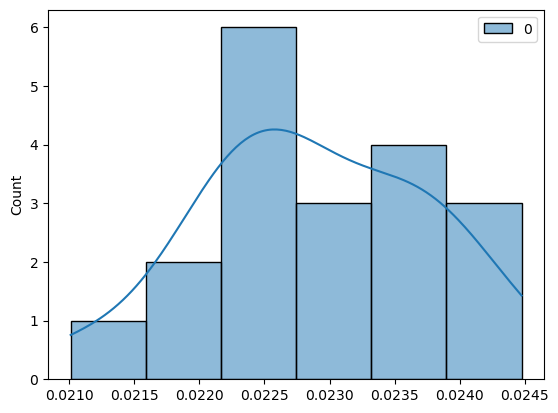

In [44]:
sns.histplot(data_A, kde=True)
plt.show()

0.023141209892234445 0.0009076517778618116


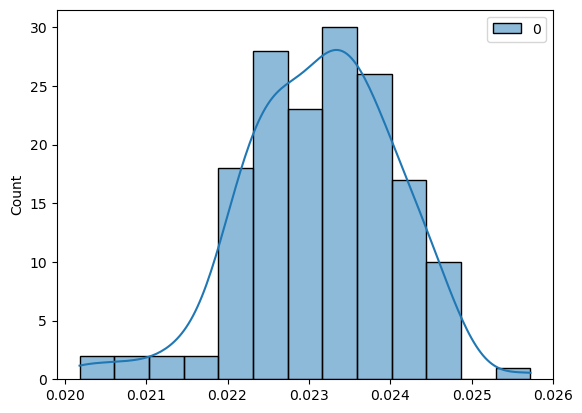

In [45]:
mu, sigma = norm.fit(data_B)
print(mu, sigma)
sns.histplot(data_B, kde=True)
plt.show()

0.02289847660676343 0.001052406449756296


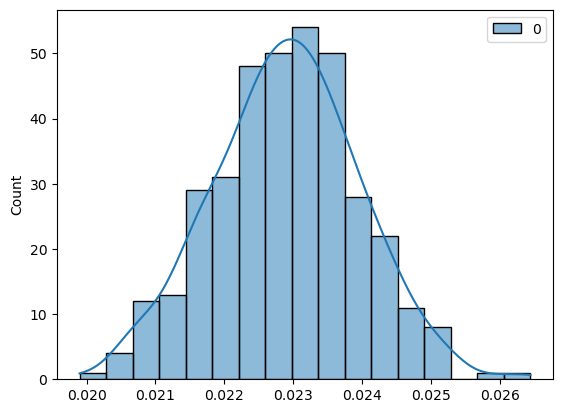

In [46]:
mu, sigma = norm.fit(data_C)
print(mu, sigma)
sns.histplot(data_C, kde=True)
plt.show()

0.06856655623098325 0.0018583286993854237


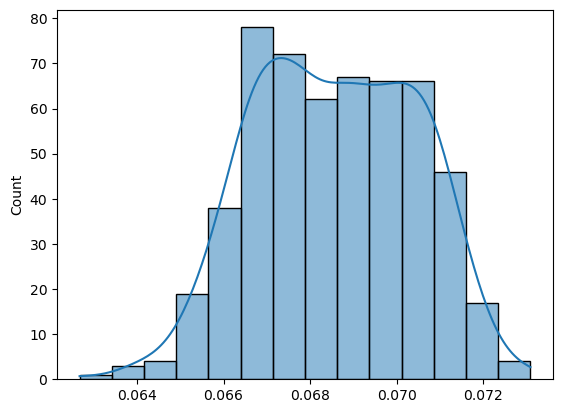

-0.06451941081228396 0.003111704634746534


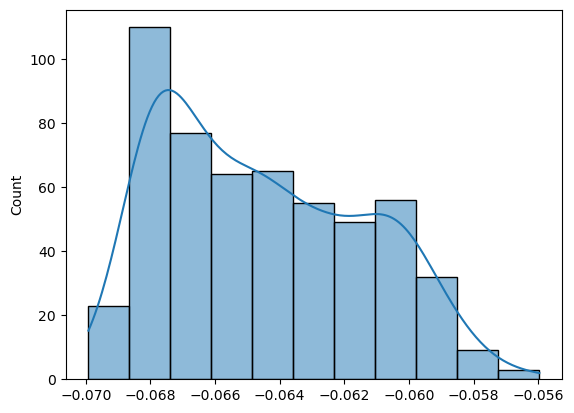

-0.013252091492846965 0.0015078899929513432


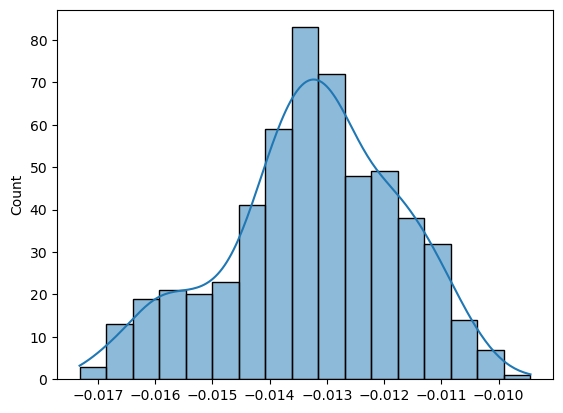

-0.1491776250343955 0.0014842678786148593


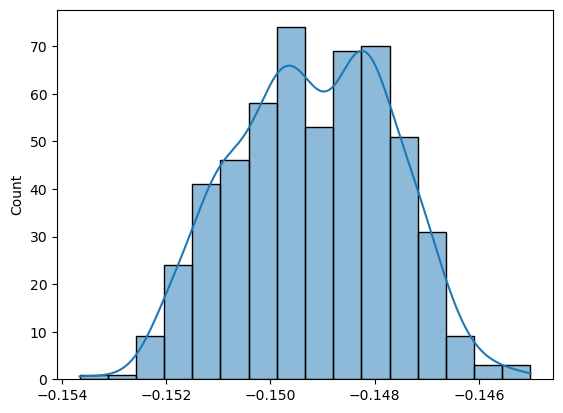

-0.001963234790189202 0.0009010837171795638


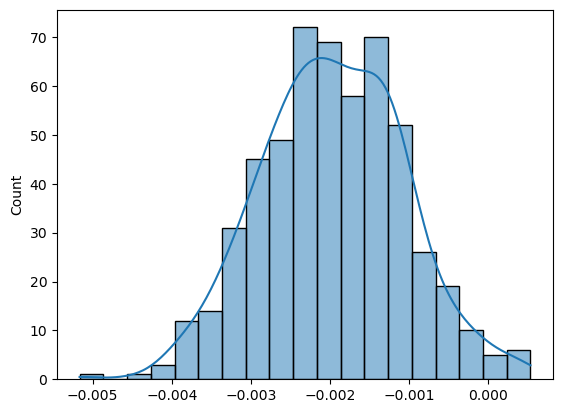

0.081106119859504 0.0009167600325959215


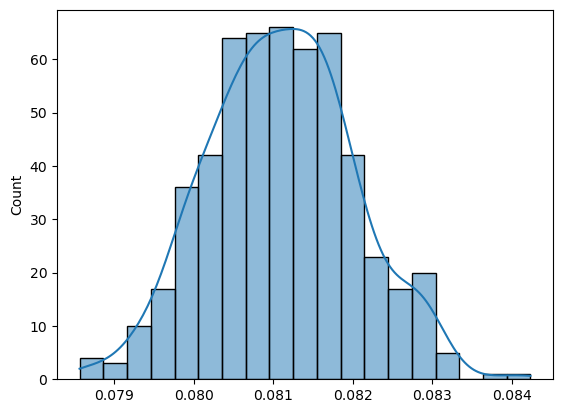

0.03409014183609416 0.0012666771260114445


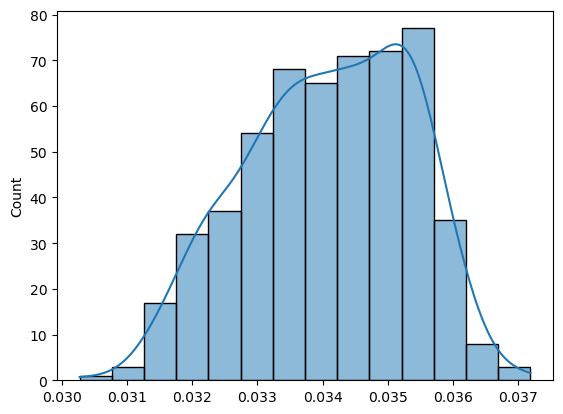

0.0834877393302777 0.0015666787948106337


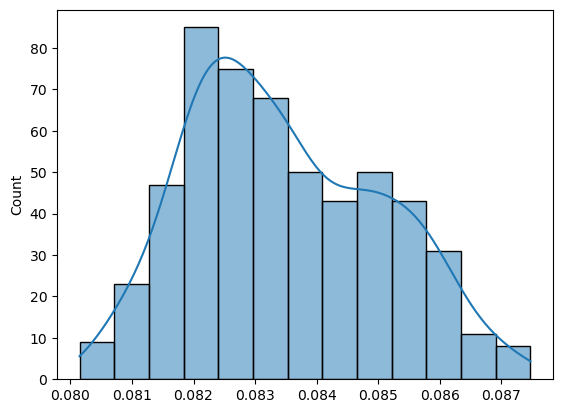

0.02695991272796254 0.000950178243549336


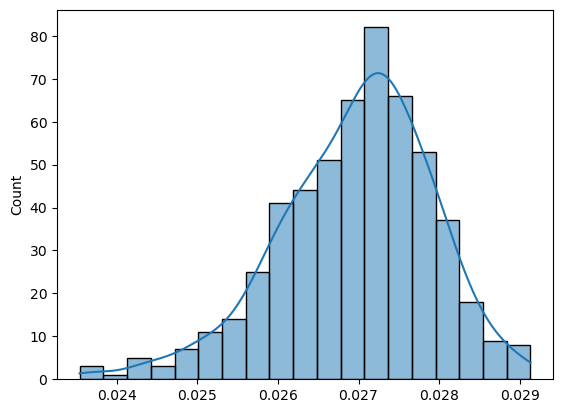

0.012542527855046327 0.0011641564208876268


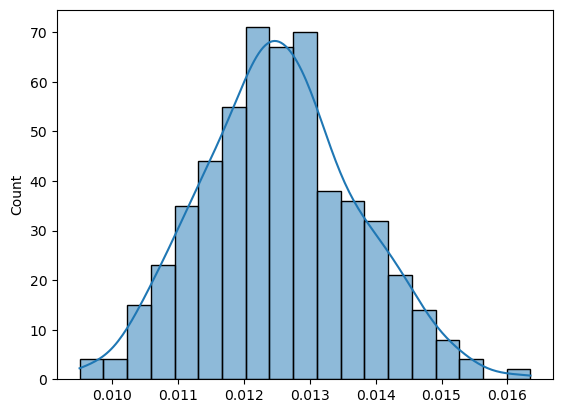

-0.04547218983893456 0.0022907637370549803


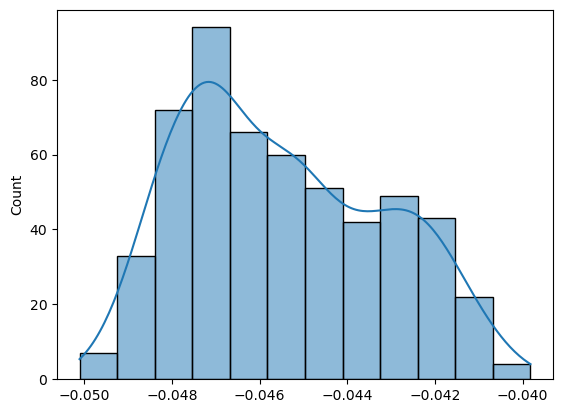

0.02991709333688405 0.0013515363852662978


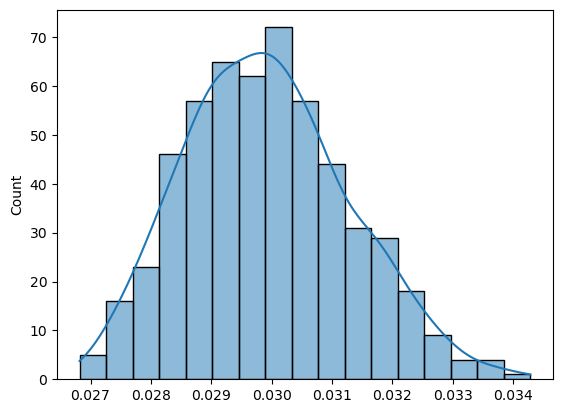

-0.013648930511696343 0.001202764264307693


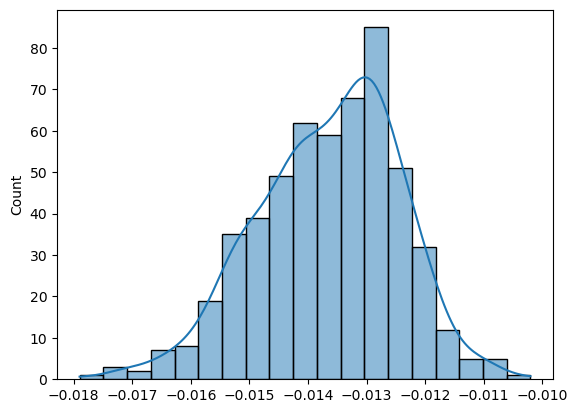

-0.00896861082676997 0.0007898962520695718


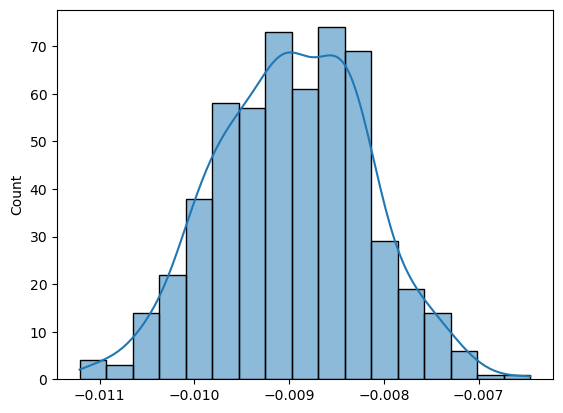

-0.07558753399065186 0.000899960138838817


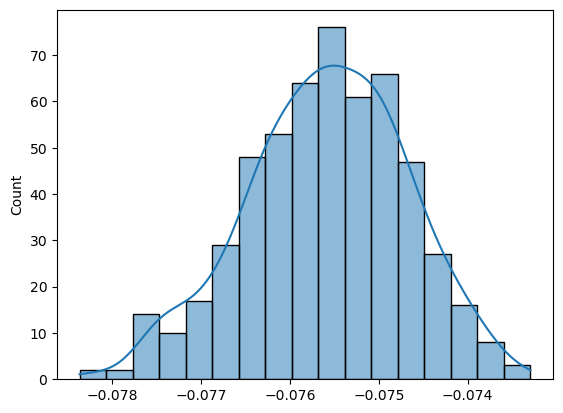

-0.008274705246996484 0.0006482252898577324


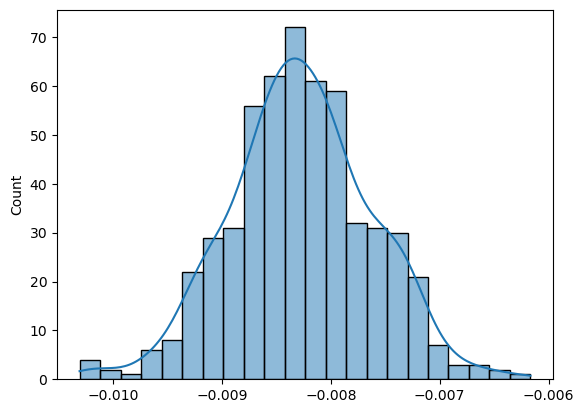

0.0114567578490652 0.0013126527576971254


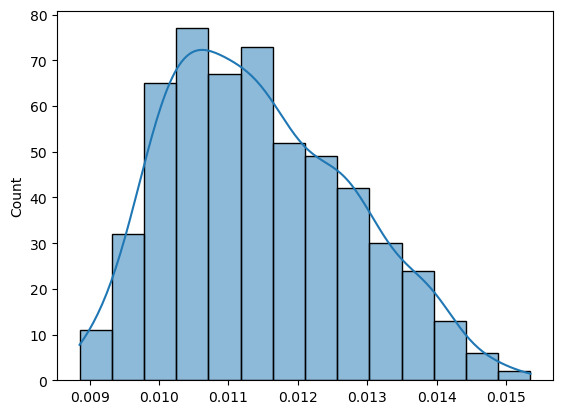

-0.007652300693828811 0.00117373665133027


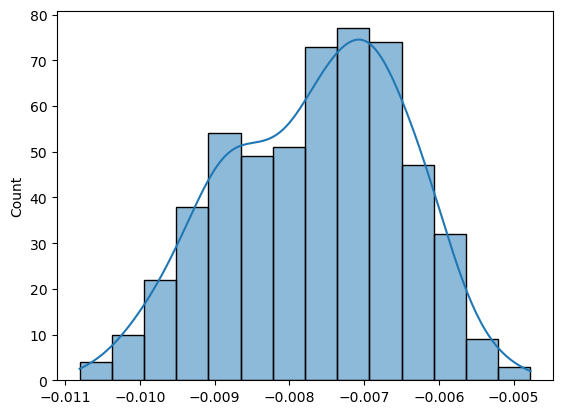

-0.004579447206190374 0.0011373670668303692


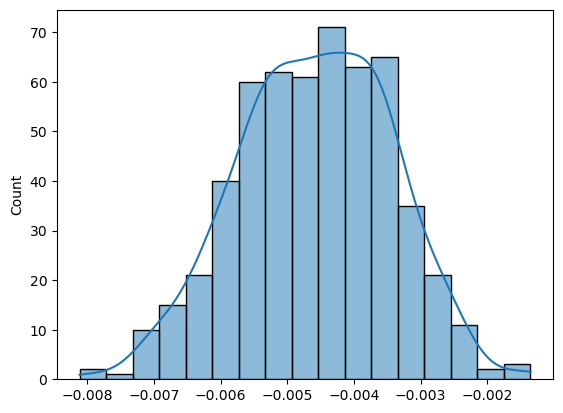

-0.004245909862220287 0.001020835412966037


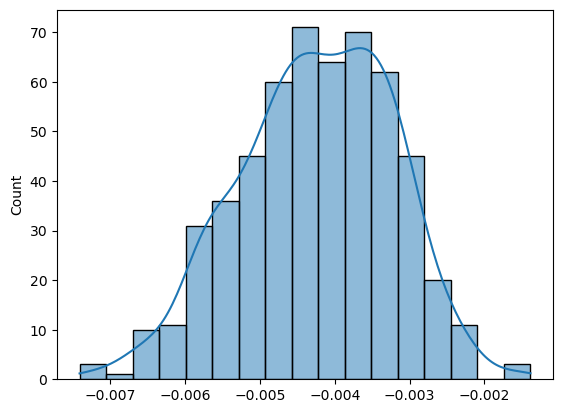

0.03861712604678797 0.0009420208568510189


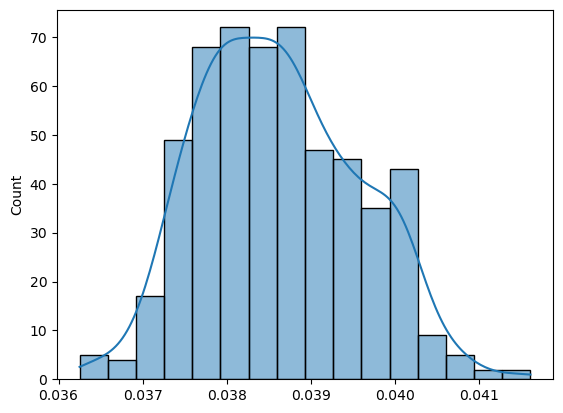

0.05818514370155378 0.0007597665843502381


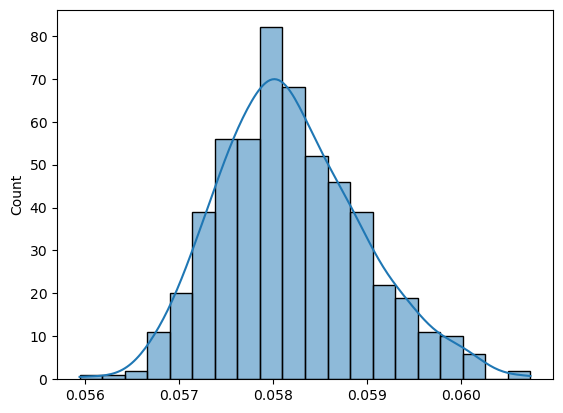

0.07658650330911025 0.0010788525942736096


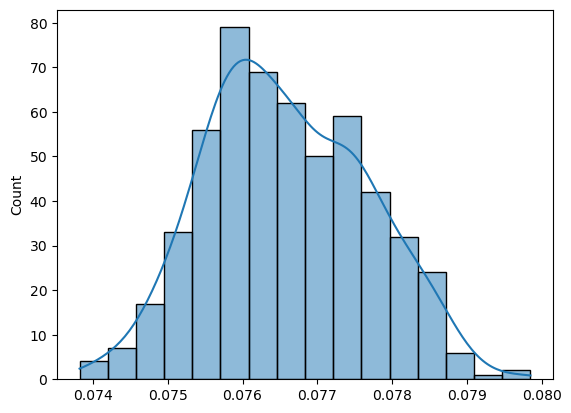

-0.06040569237719803 0.0009218275333111667


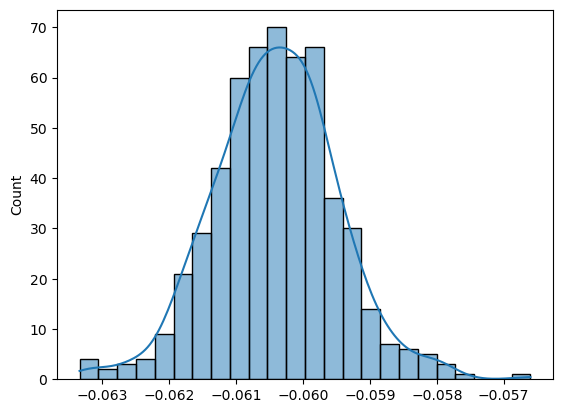

0.010754128425805719 0.0007906156444906747


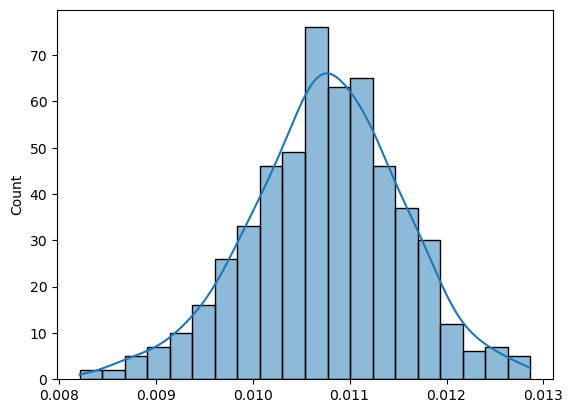

0.0340431187384201 0.0018107892992121563


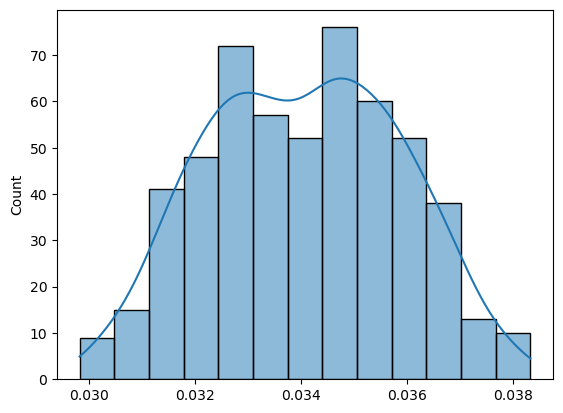

0.004586858917147772 0.0007307897754199811


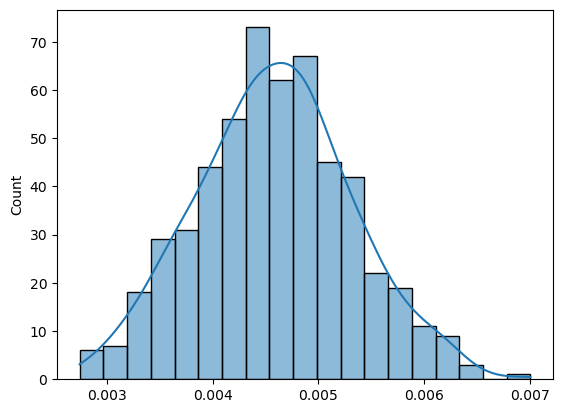

-0.0791389181194604 0.0010588010113324932


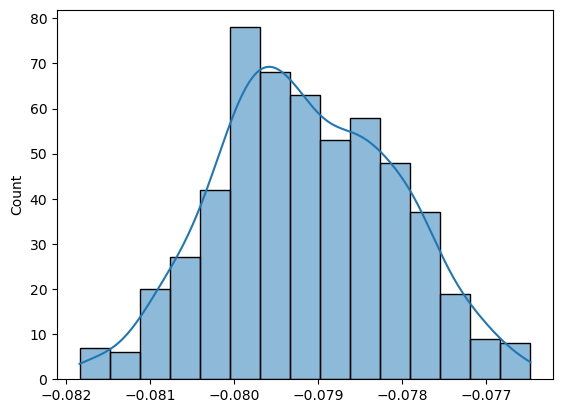

-0.08217595996503232 0.0007549228749238137


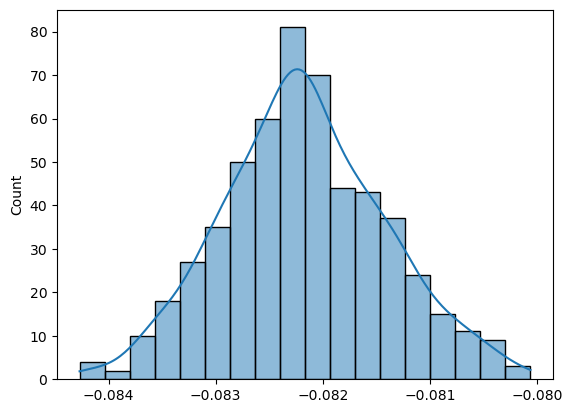

-0.04036975732934189 0.0010252769932676238


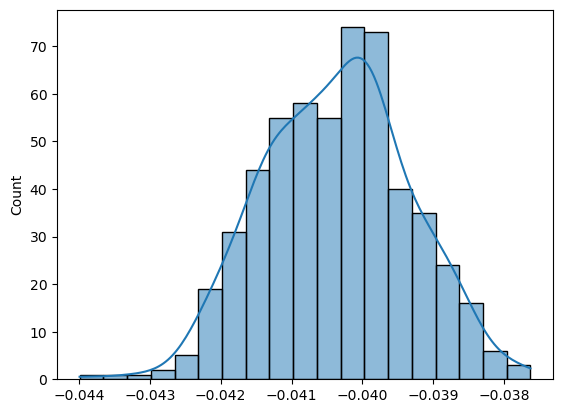

-0.03258176218944689 0.0008003615205873922


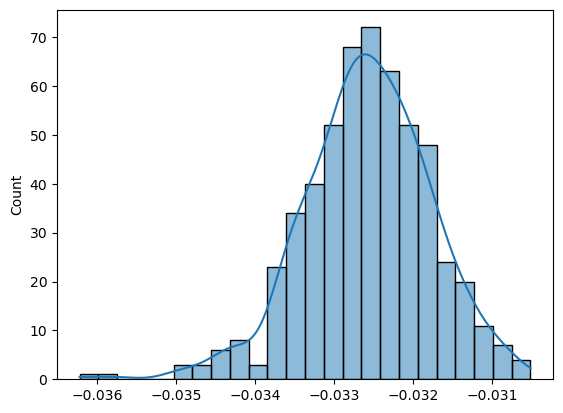

-0.01814140210144263 0.0011456060995492267


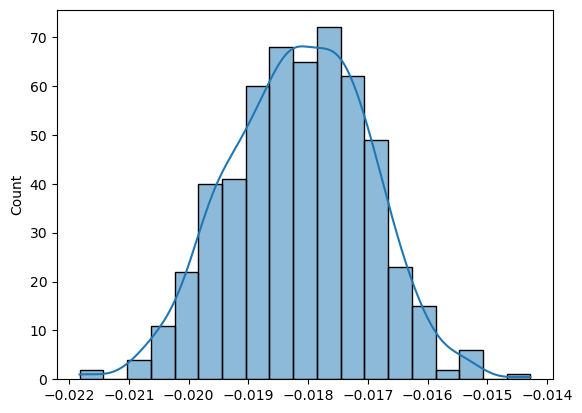

0.06083885935678886 0.0015170436390912168


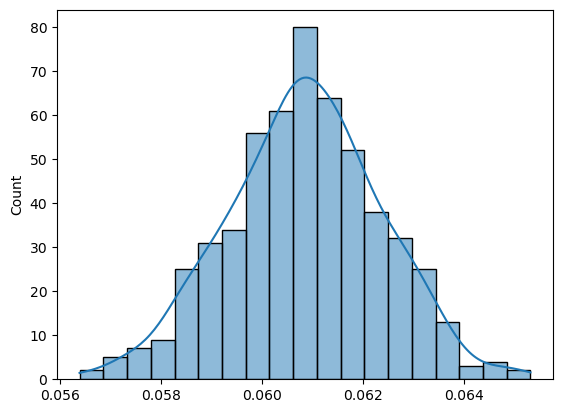

-0.009382308801656681 0.00208150569160513


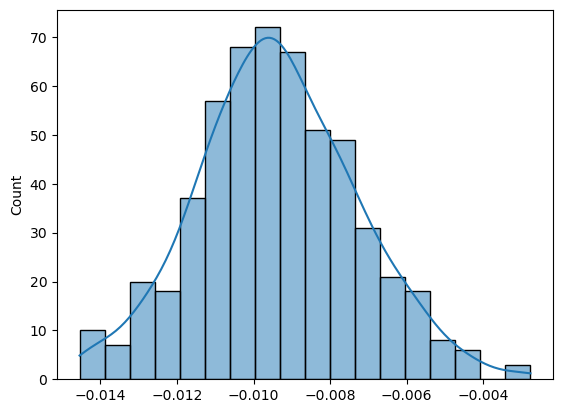

-0.009378827026913124 0.0012367734618166117


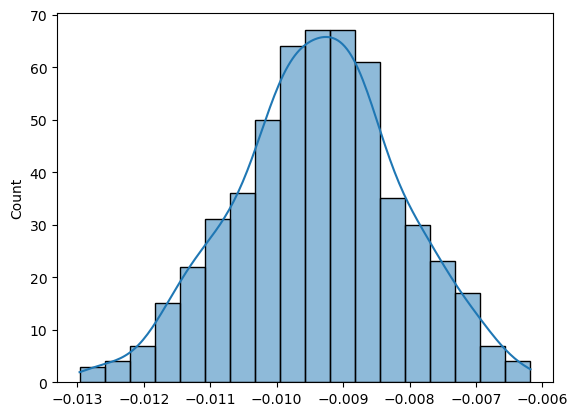

0.04014759140284681 0.0010517314821747179


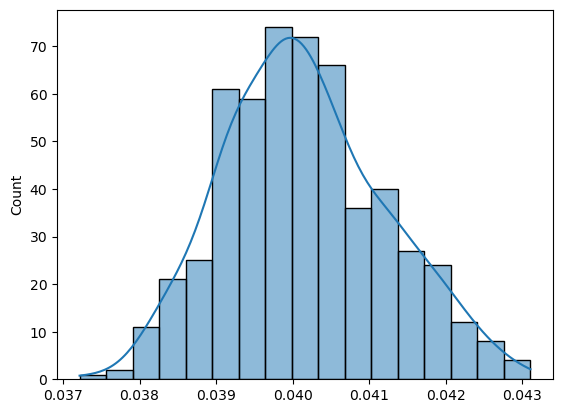

-0.022265292515439662 0.0013367448466290834


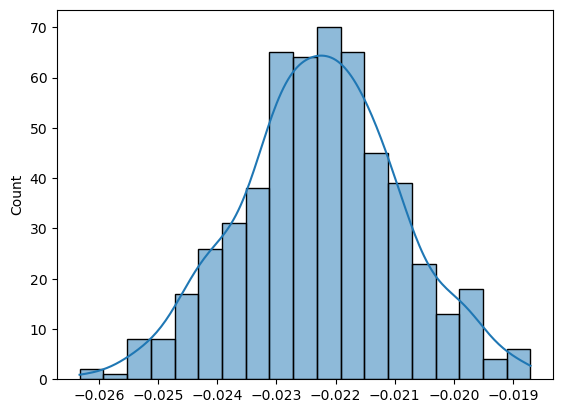

0.05010233962870654 0.0012158437992184287


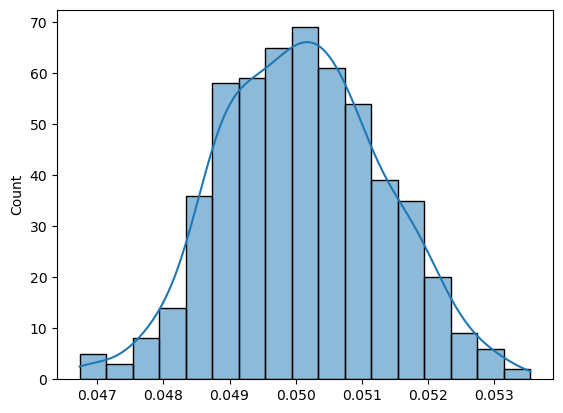

-0.08987188310418999 0.0015568937210721882


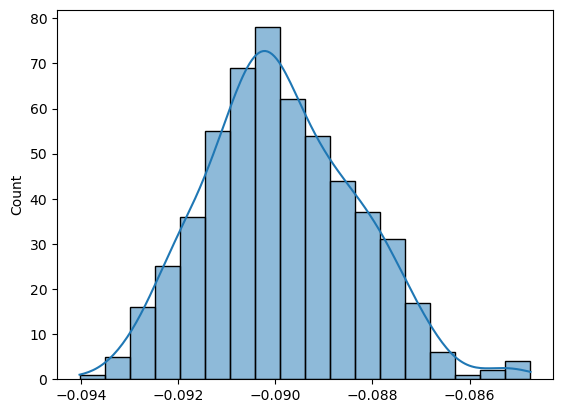

-0.062232385717099103 0.0009079409873903099


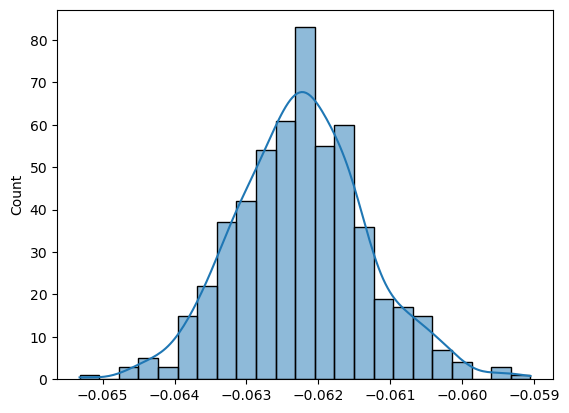

0.07058385190164626 0.0011055489501393006


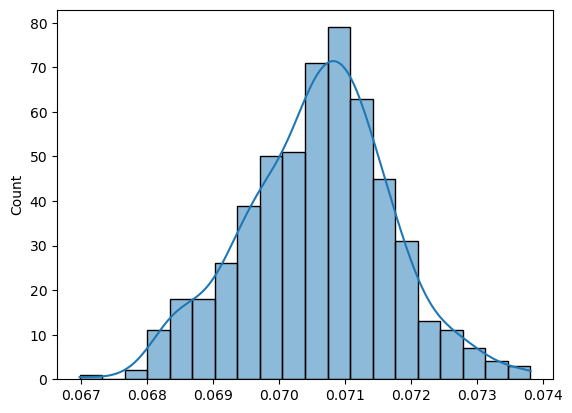

0.05477032507212342 0.0011990177809039612


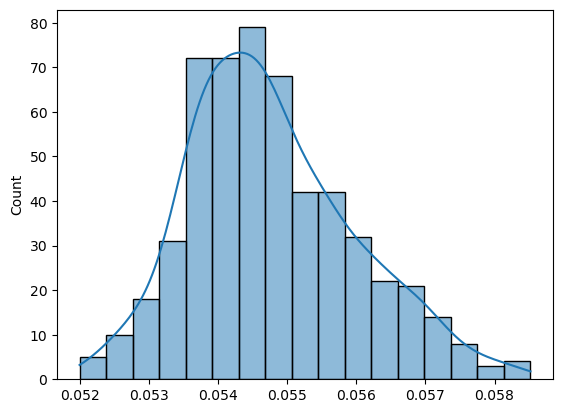

0.01999348693597602 0.0010701052868149164


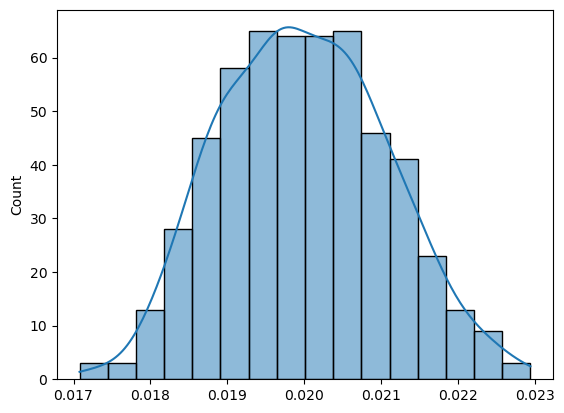

0.08618850464045892 0.001127825051990131


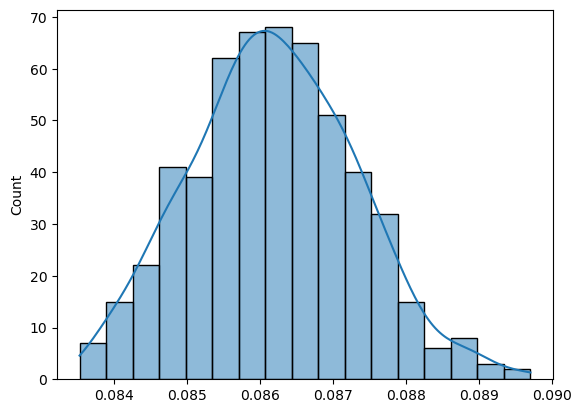

-0.08261182992058784 0.001289031542601443


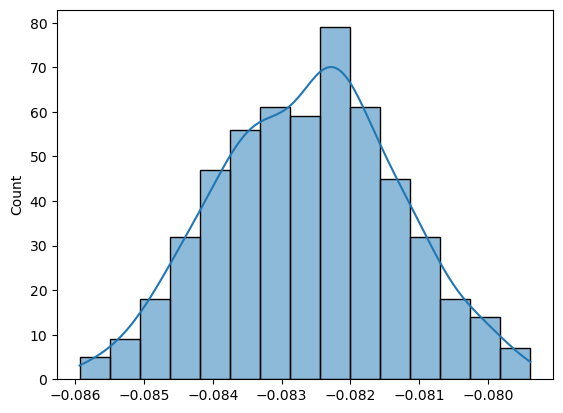

0.019400853008498364 0.000879653316635127


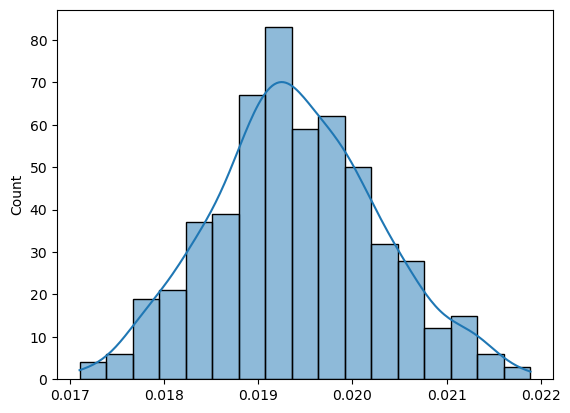

-0.04545527140903209 0.001239152446234548


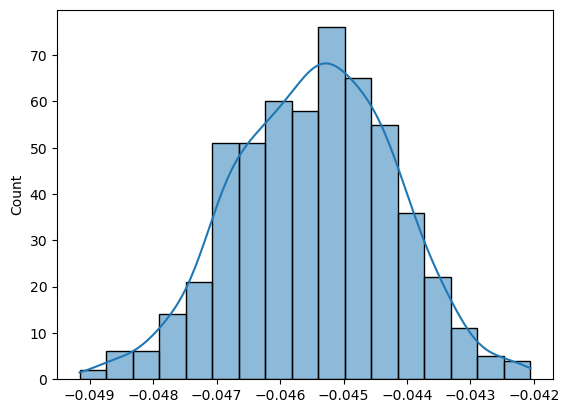

0.028192553621190247 0.001304621564666416


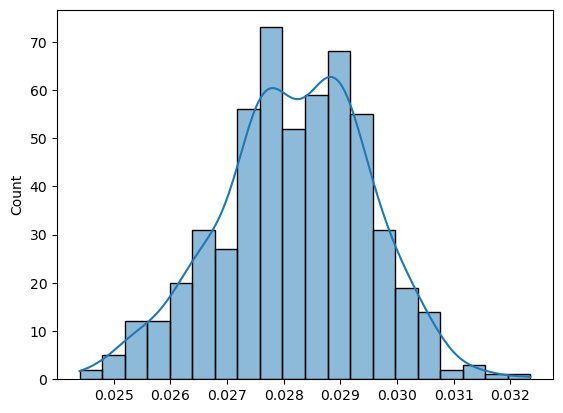

-0.09587863801153544 0.0012294177910887741


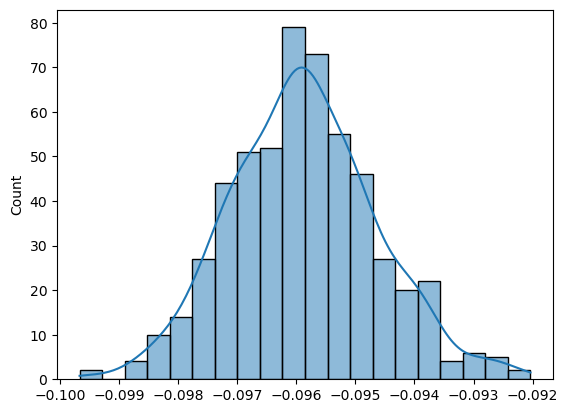

0.0639906160903899 0.0012579611561205485


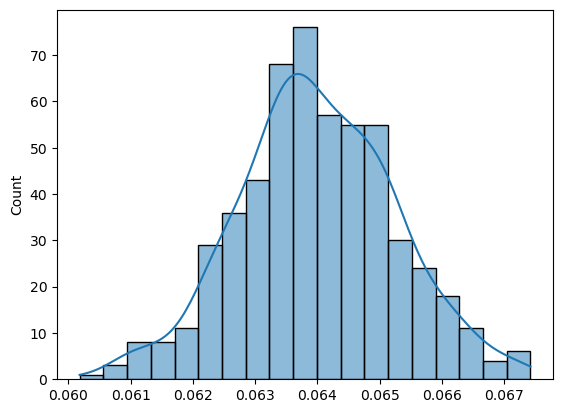

-0.1460445312230846 0.0012587650679940622


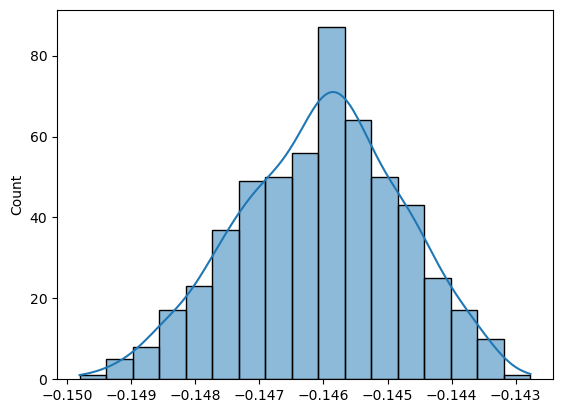

0.049052947730813895 0.001091364807981185


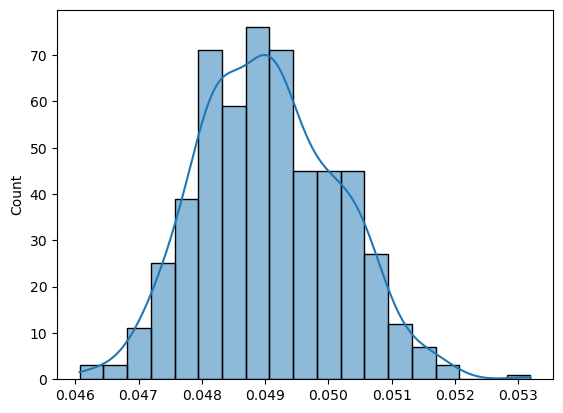

0.05080134971118764 0.001173973599649348


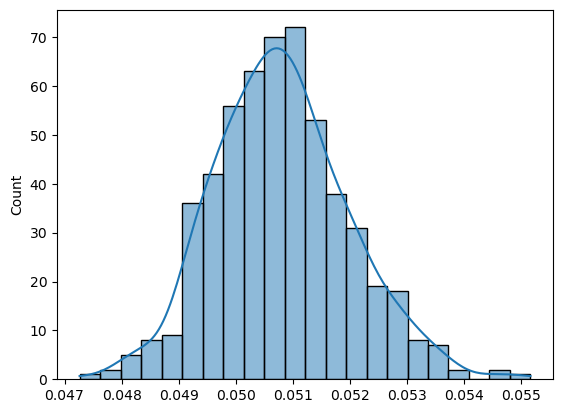

-0.049643142680546634 0.0017305358538288586


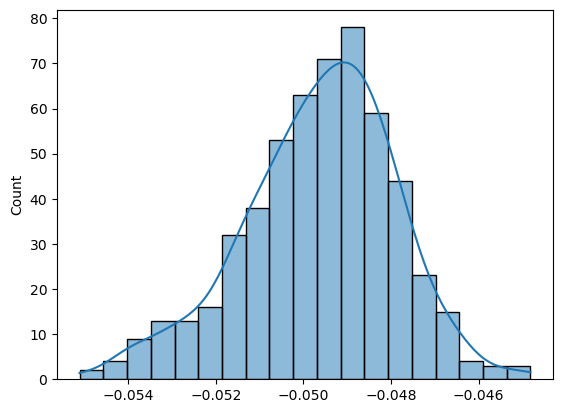

0.0808317466719594 0.0011528299837962536


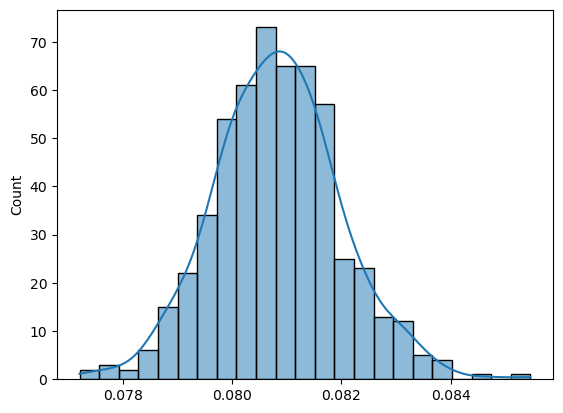

0.055172639993288676 0.0013764911076600927


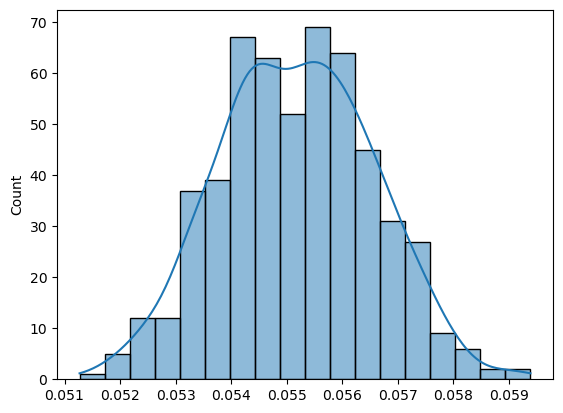

0.0879100509687682 0.0010837560322481336


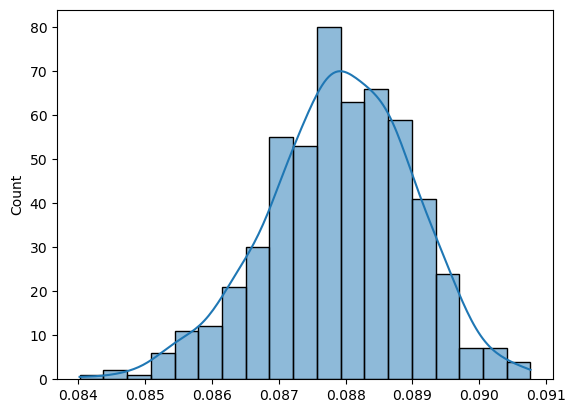

-0.0018608495106399196 0.0013469780318518185


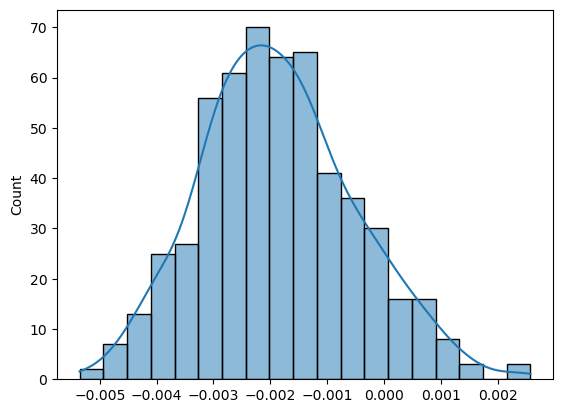

-0.02210557822680056 0.0010836727346103384


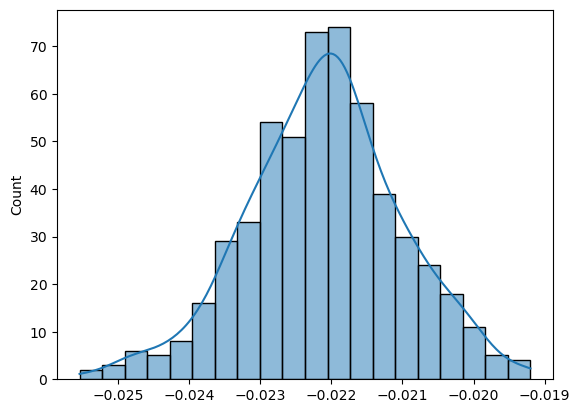

-0.030452219398887776 0.00168944726496825


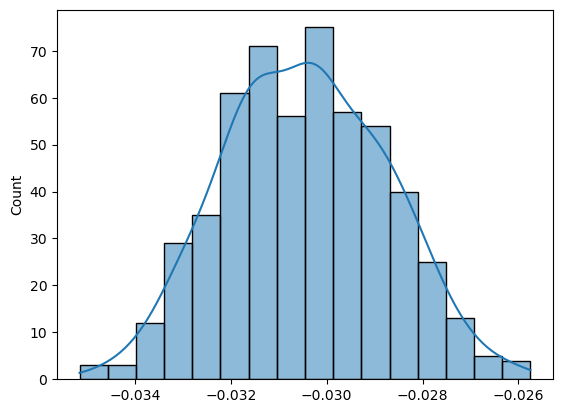

0.040105869146286895 0.0012862320054412239


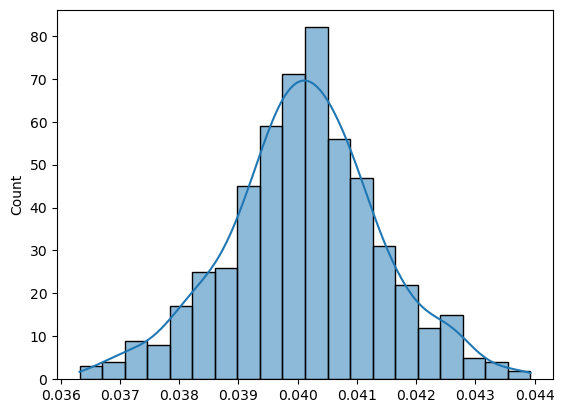

-0.03575290292227027 0.0015296733312671943


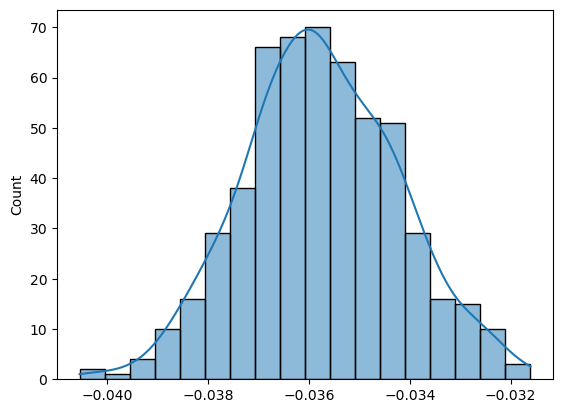

0.038707798240538244 0.0013720508501209455


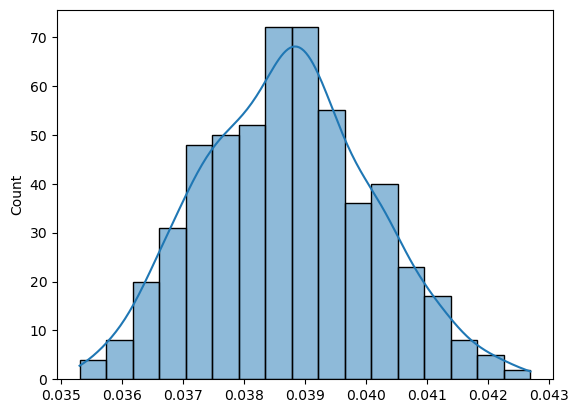

0.02813602628230939 0.0017812182641835695


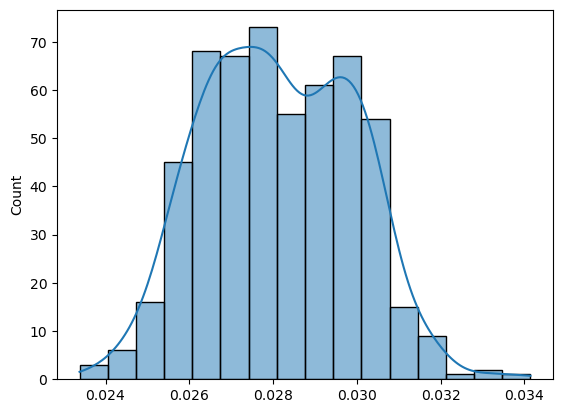

0.022969916929417113 0.0010114425064664102


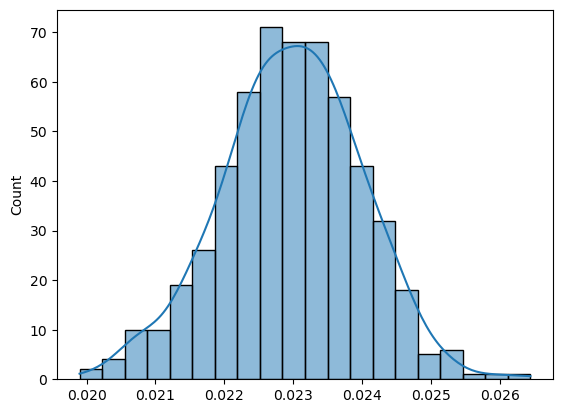

-0.01695788423247759 0.0010792699083805076


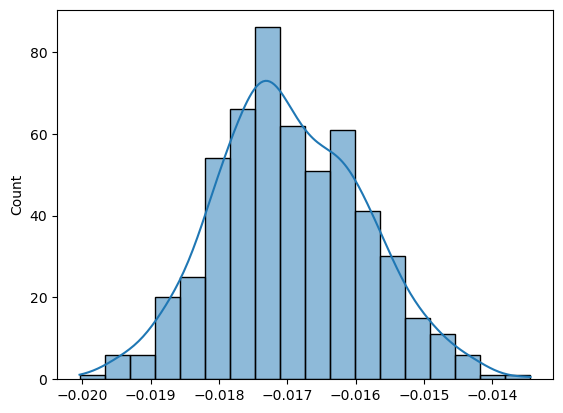

-0.043213616054964765 0.001073483671326194


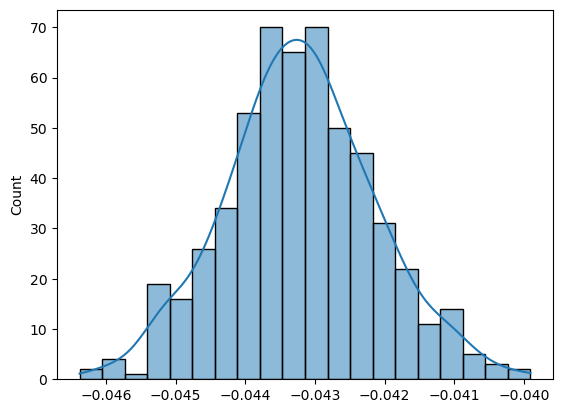

0.060179304688290775 0.0011840481076560545


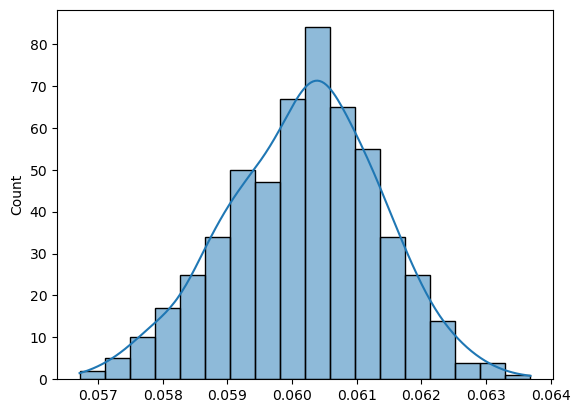

0.0058794667100461806 0.00103554637354207


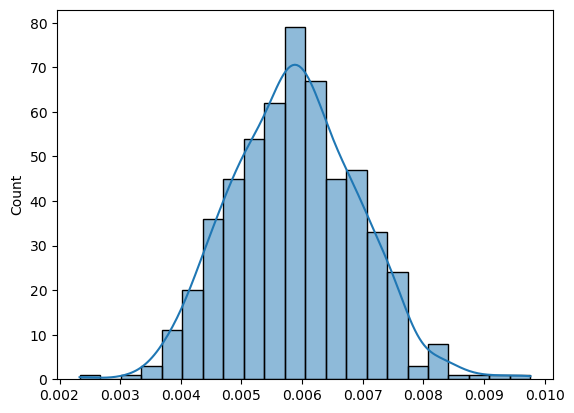

0.05324287254287832 0.0011678344737030455


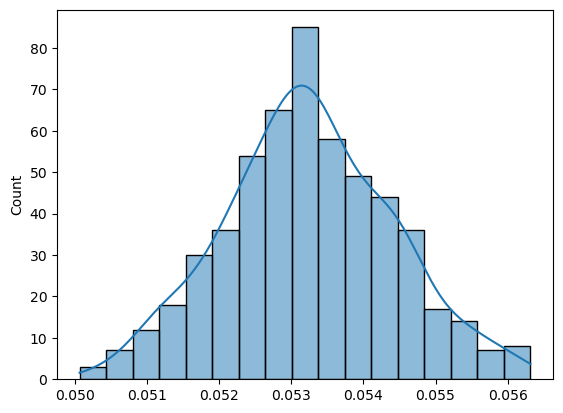

0.05590146331332665 0.0015945332549836837


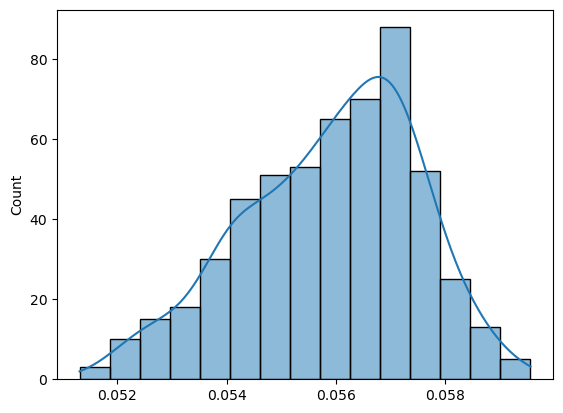

-0.021342164217657368 0.000858654758313503


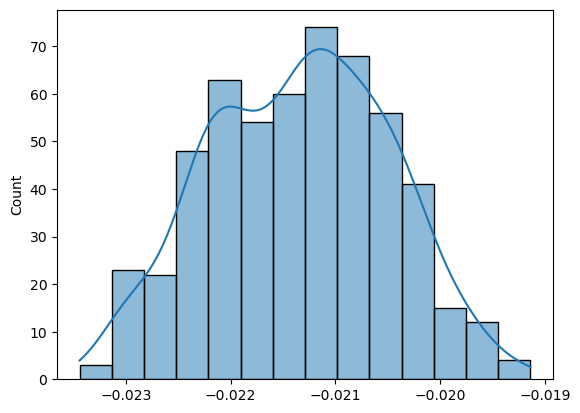

-0.0439911817250221 0.001018750325731386


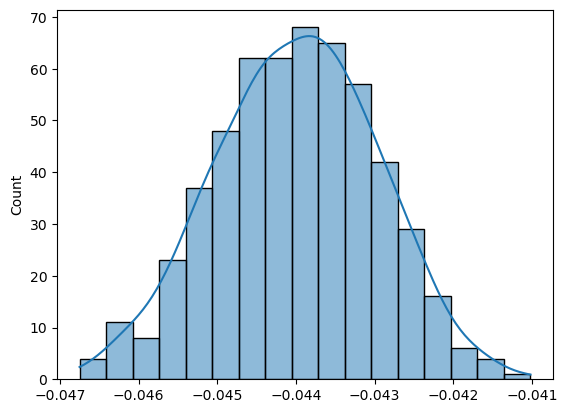

-0.05992826789919404 0.001143795860916454


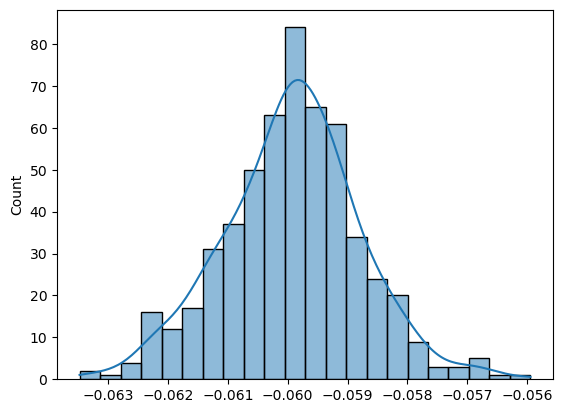

-0.0084911884163707 0.0010883912247437336


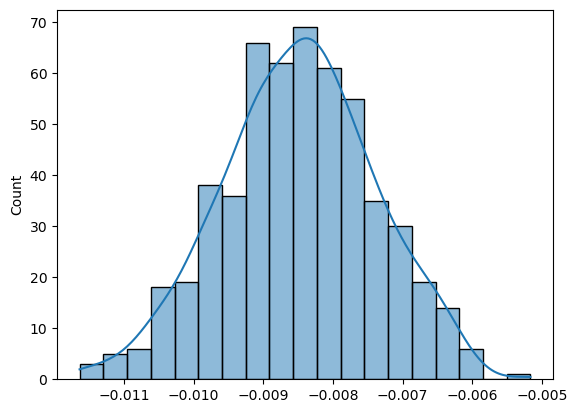

0.07177265470034509 0.0016382988806169223


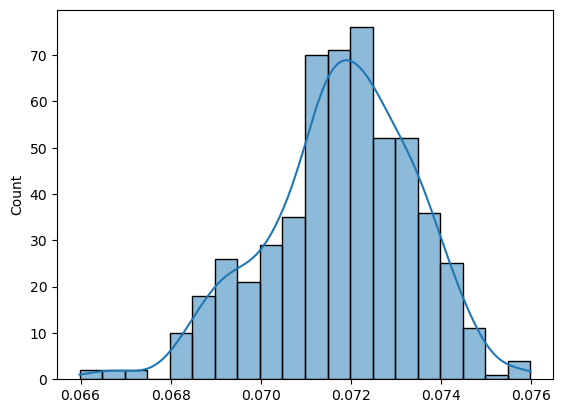

0.035807982142019884 0.0012521222870474733


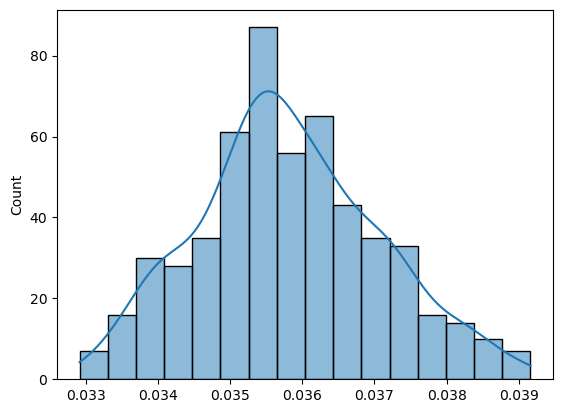

0.020198571483705803 0.000972192460936848


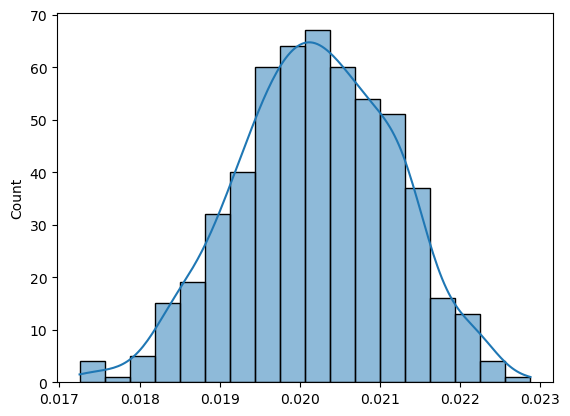

-0.007661467635897751 0.0010053396129981174


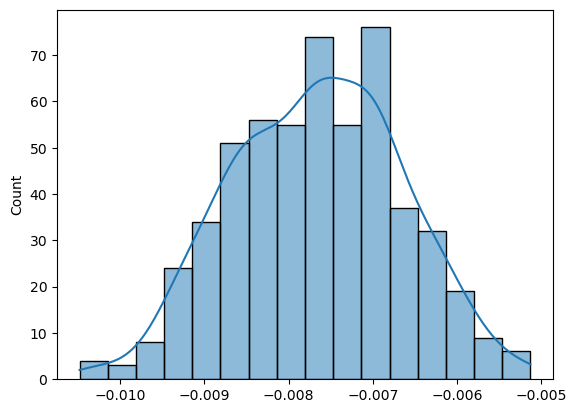

-0.06037898973645865 0.0014170348706896922


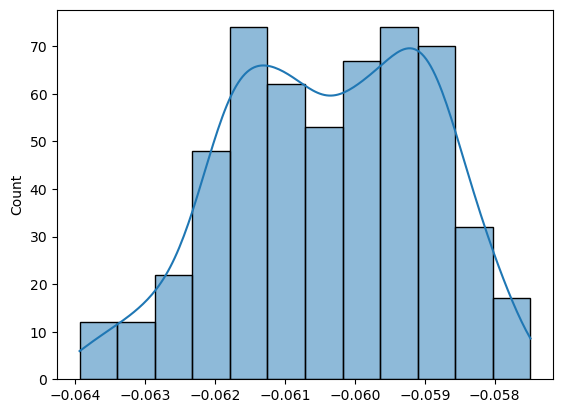

0.04459964619815679 0.0009233433639642848


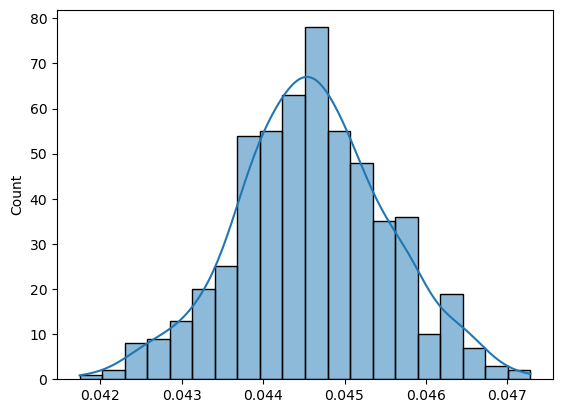

0.03581273940633674 0.001265539043272698


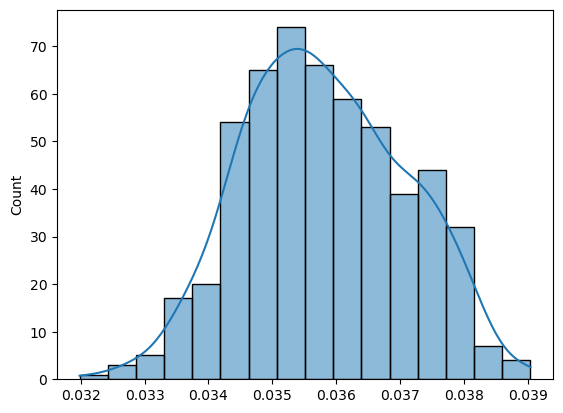

-0.014965257893829275 0.0010669912585405993


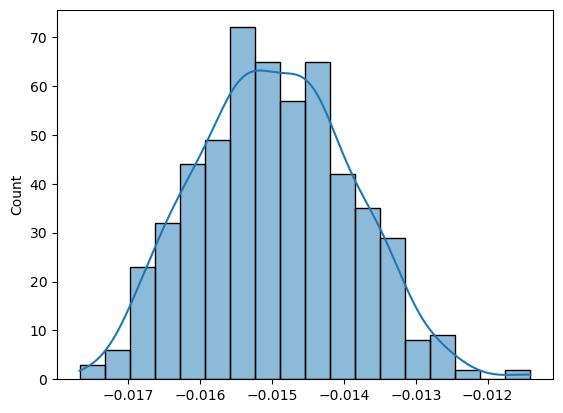

0.07136232792837185 0.0014427301782311778


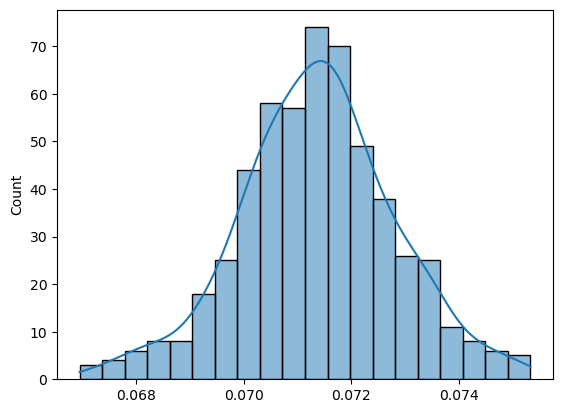

0.06032188087839009 0.002006300073203783


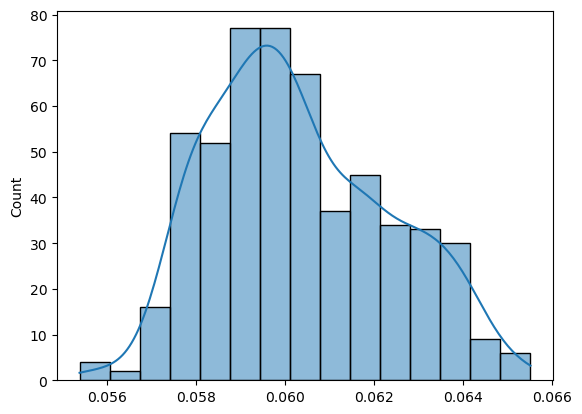

-0.02865113078189489 0.0012016751792367911


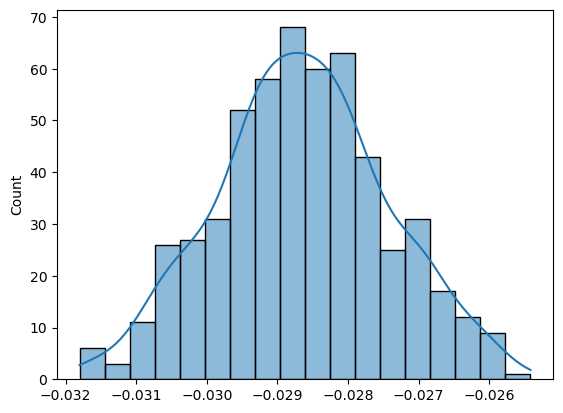

-0.0035849802441934456 0.0008762186877978486


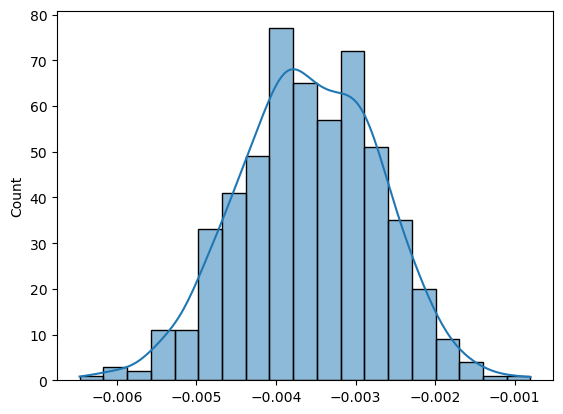

0.00056648137421788 0.0013091057728350807


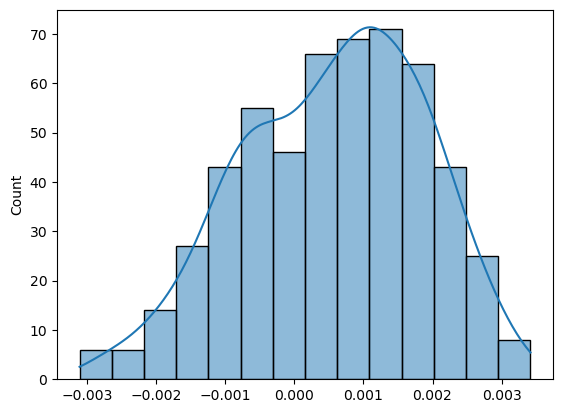

0.025351457551643114 0.0012739539206265945


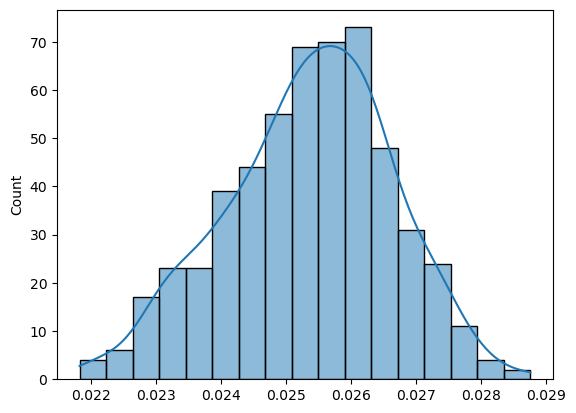

-0.03109818986148795 0.0010092199082047098


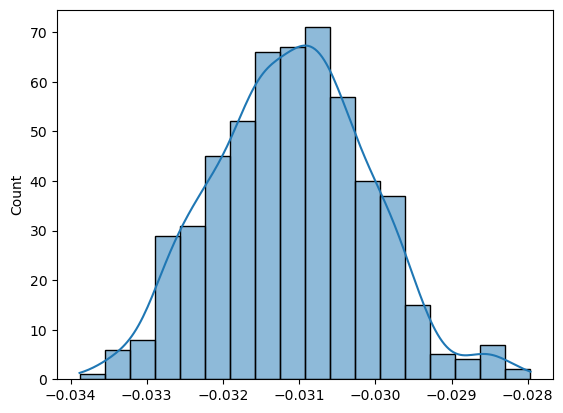

-0.030954083383193113 0.0013707236362184756


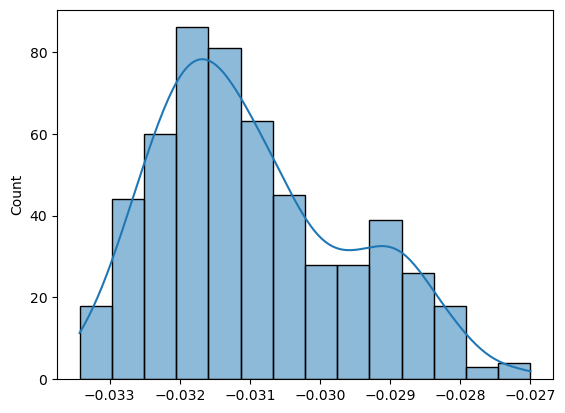

0.0046180100171632965 0.0010315609327630013


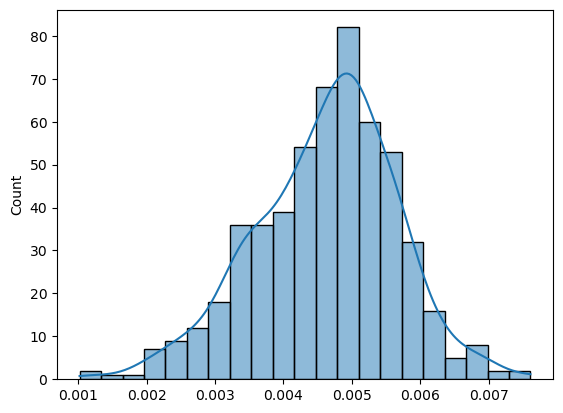

-0.03126372140360581 0.0013774297450161494


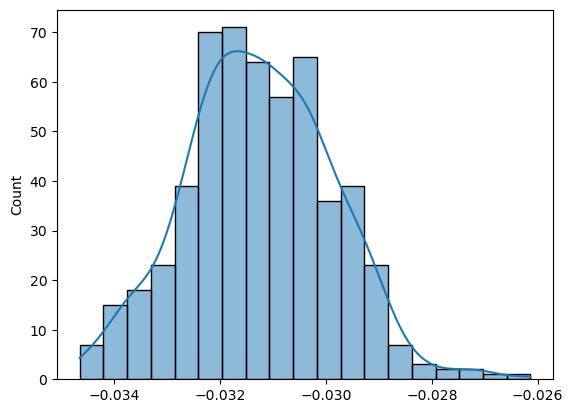

0.034025118368957365 0.0015169665351295236


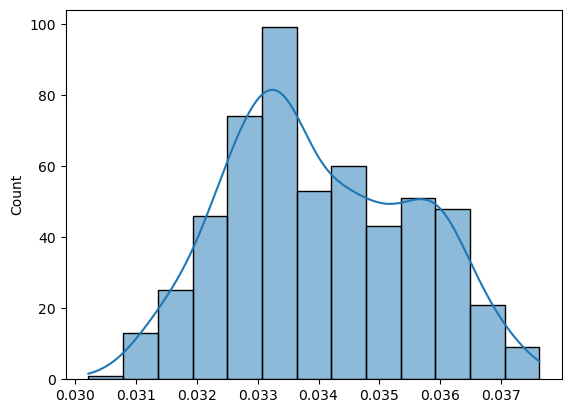

0.0515694962762996 0.0014880261332796431


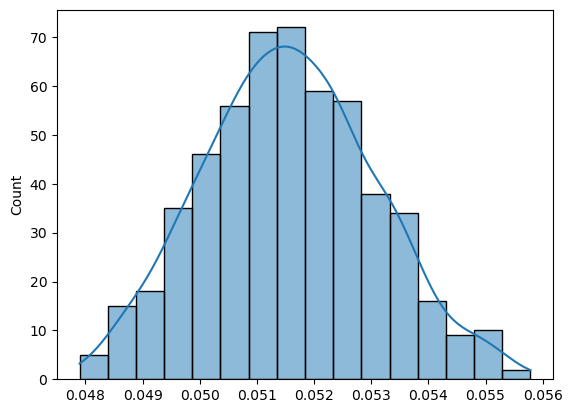

0.0088726455503543 0.0009863024448468537


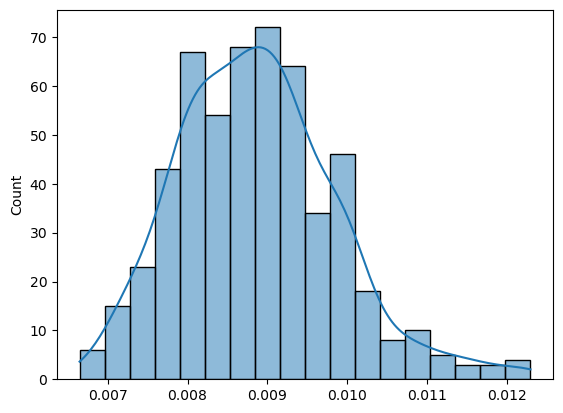

In [48]:
for dim in range(96):
    mu, sigma = norm.fit(mus[:,dim])
    print(mu, sigma)
    sns.histplot(mus[:,dim], kde=True)
    plt.show()


In [49]:
import scipy.stats as stats

In [52]:
def plot_qq(data, title='Q-Q Plot'):
    plt.figure(figsize=(10, 6))
    stats.probplot(data, dist='norm', plot=plt)
    plt.title(title)
    plt.show()

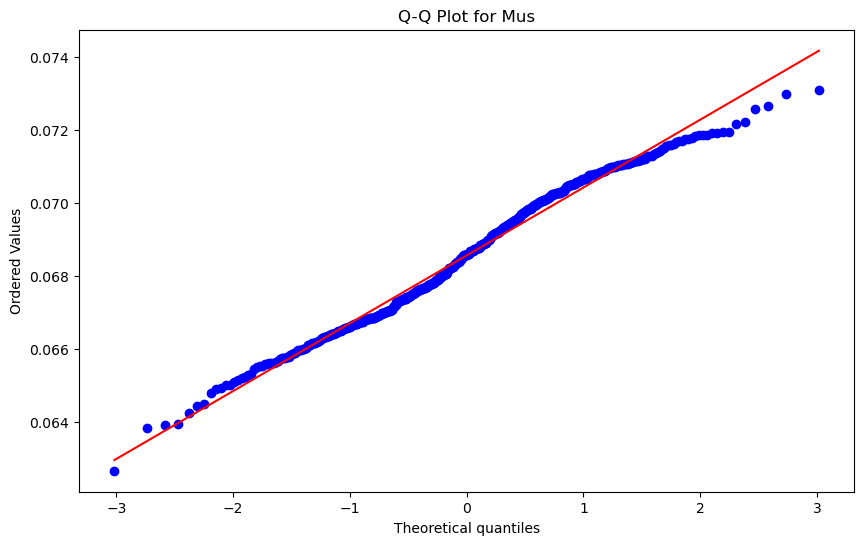

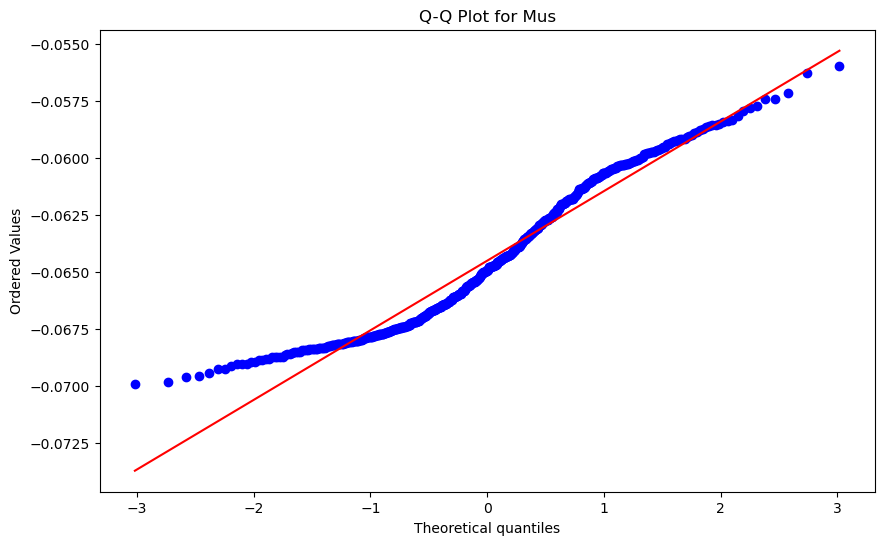

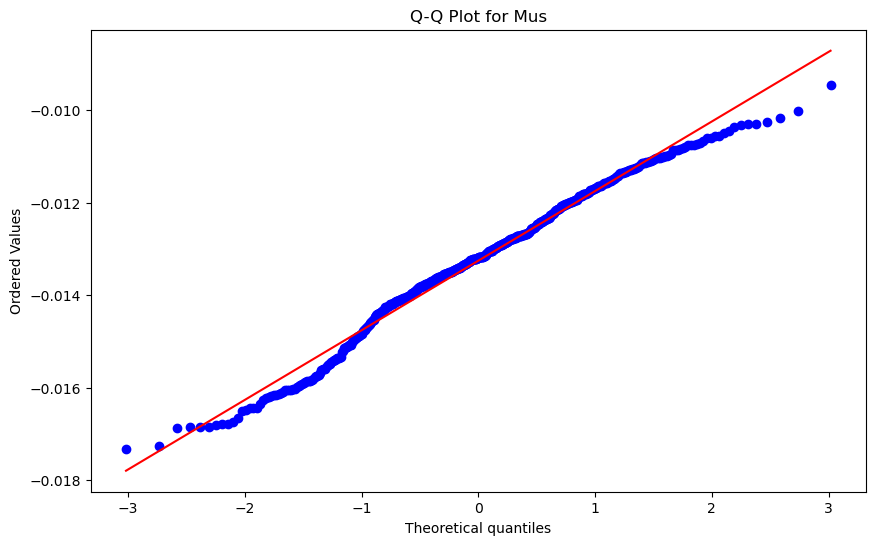

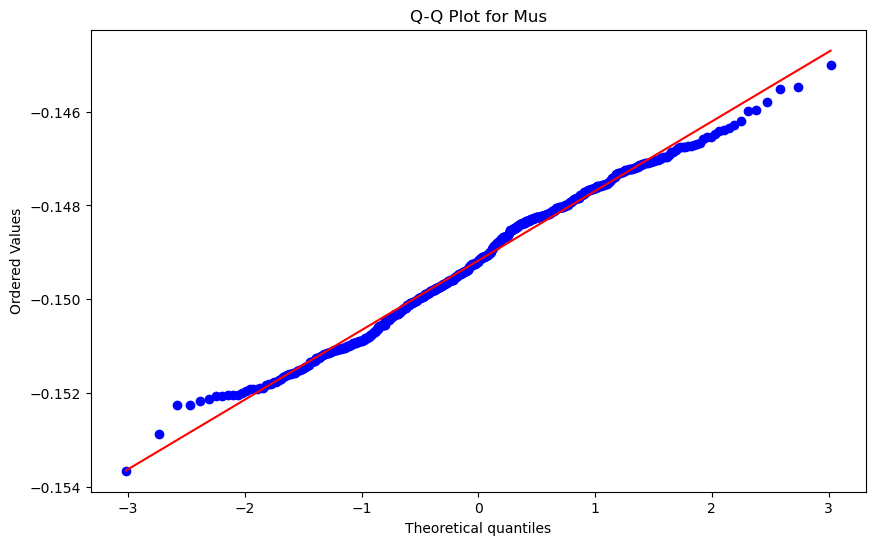

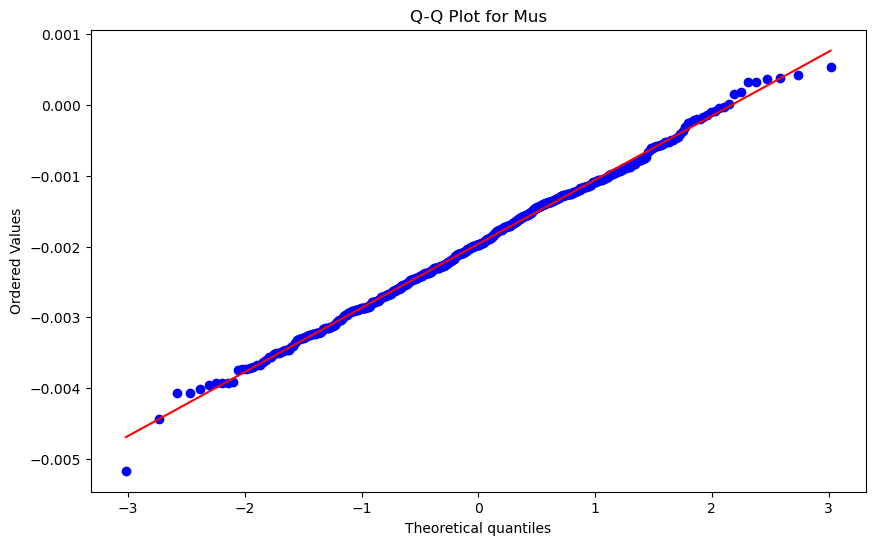

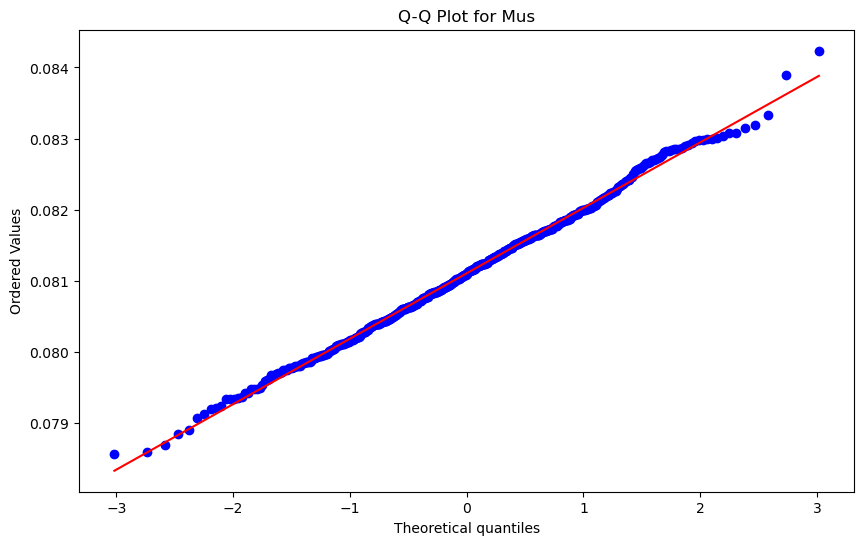

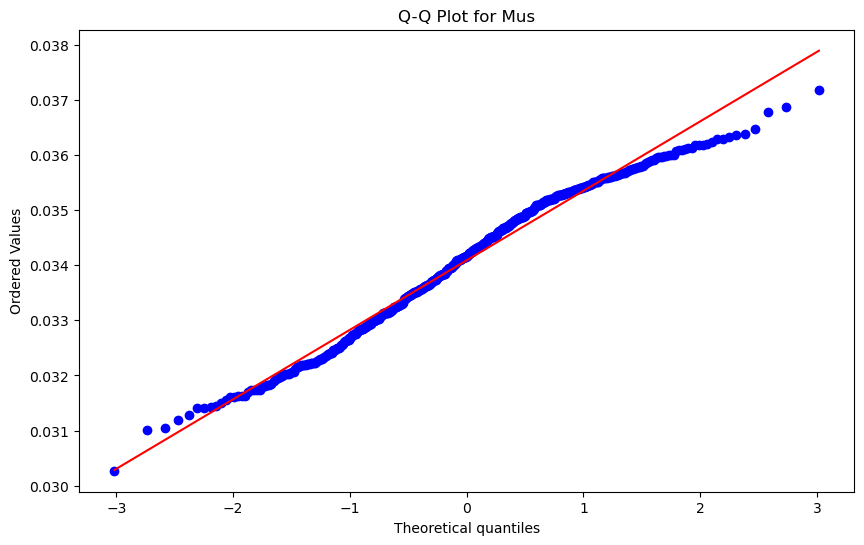

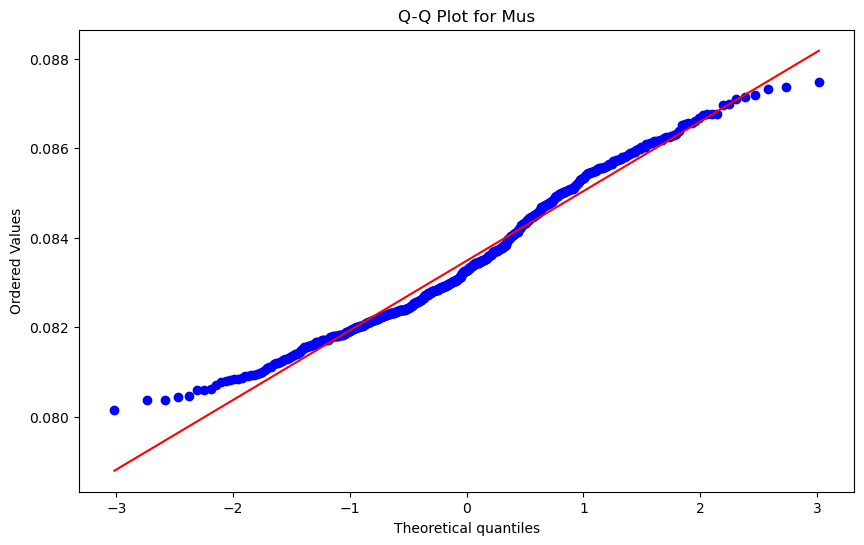

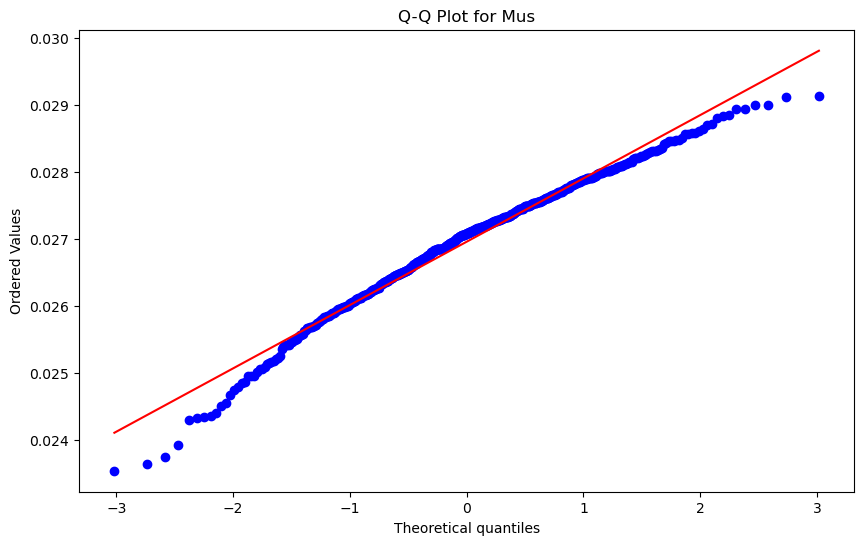

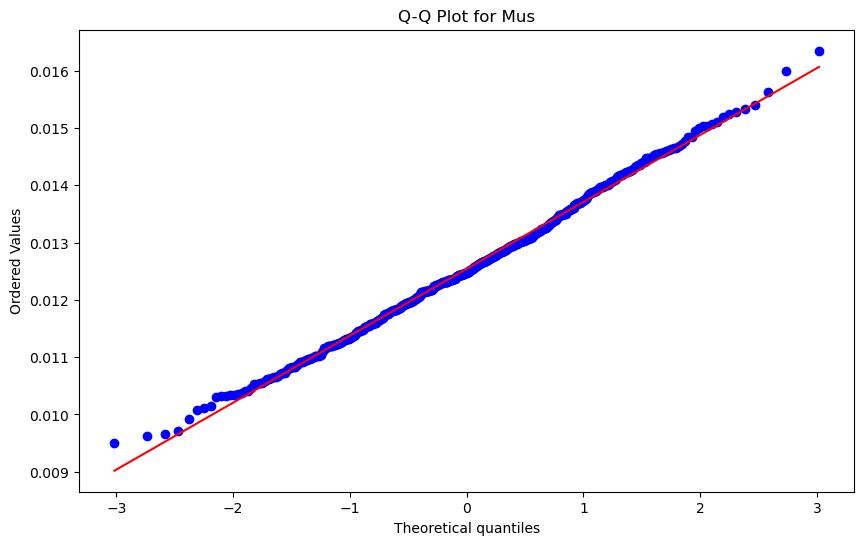

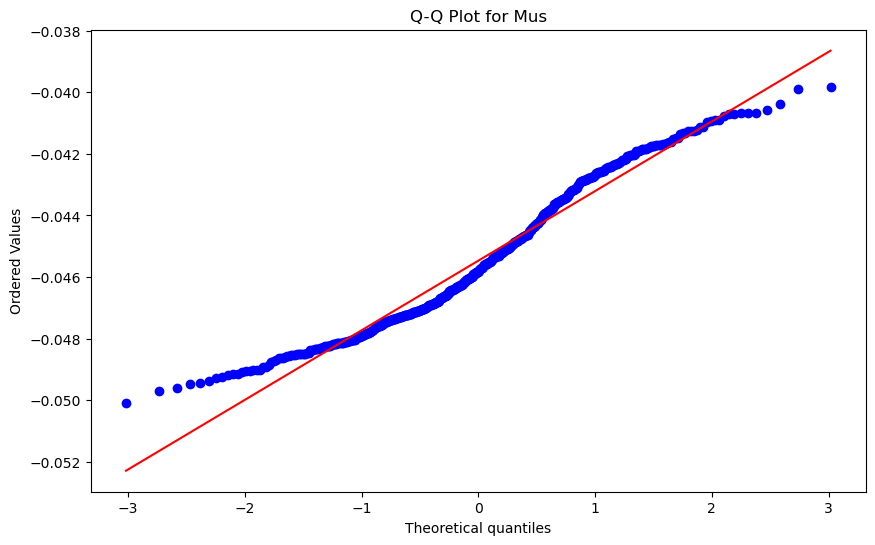

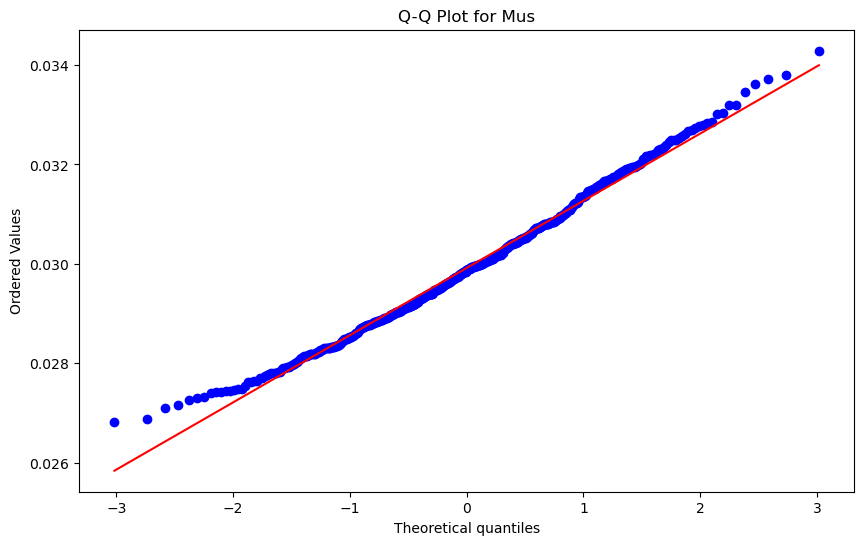

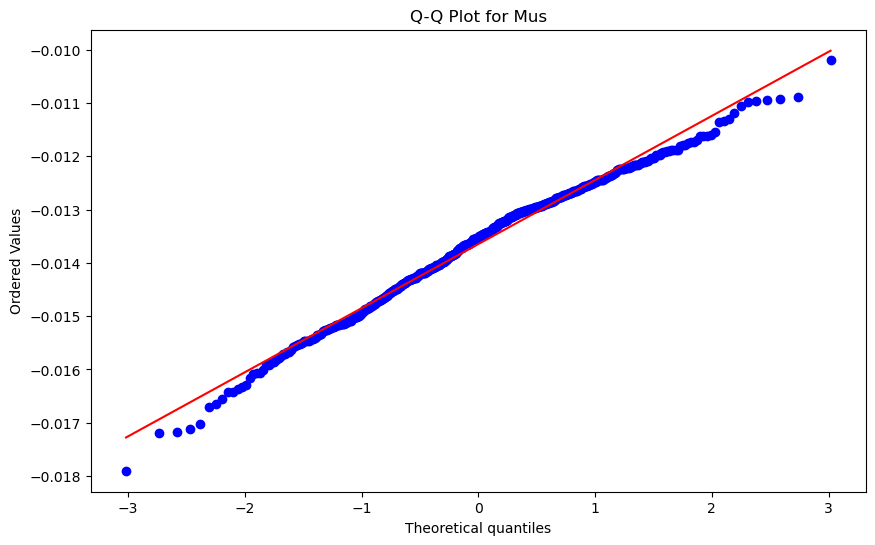

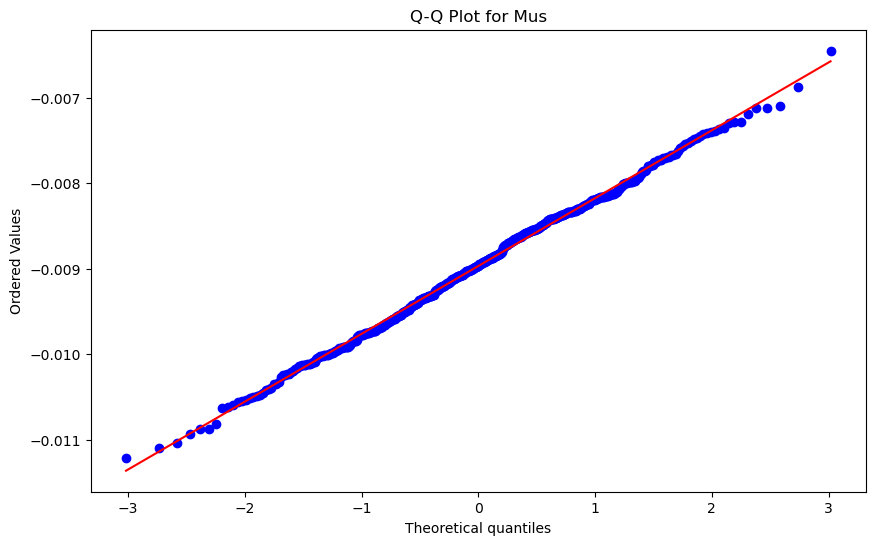

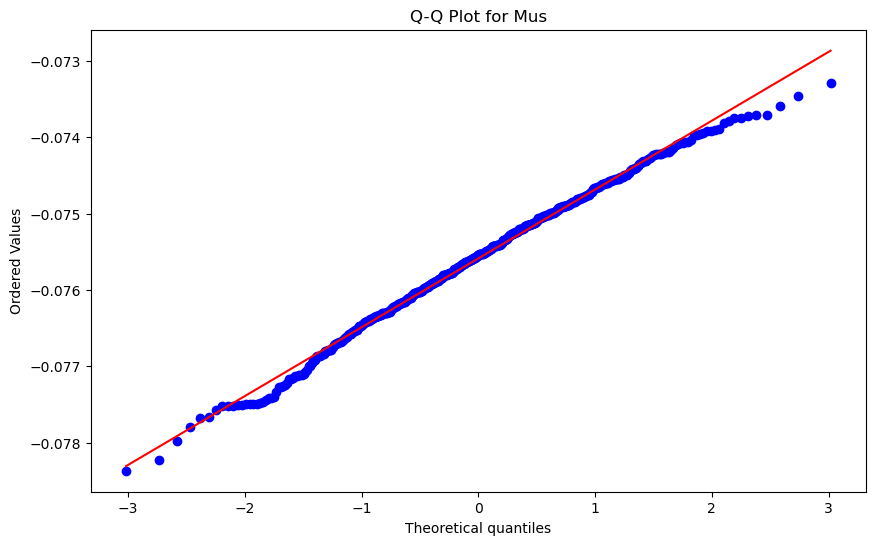

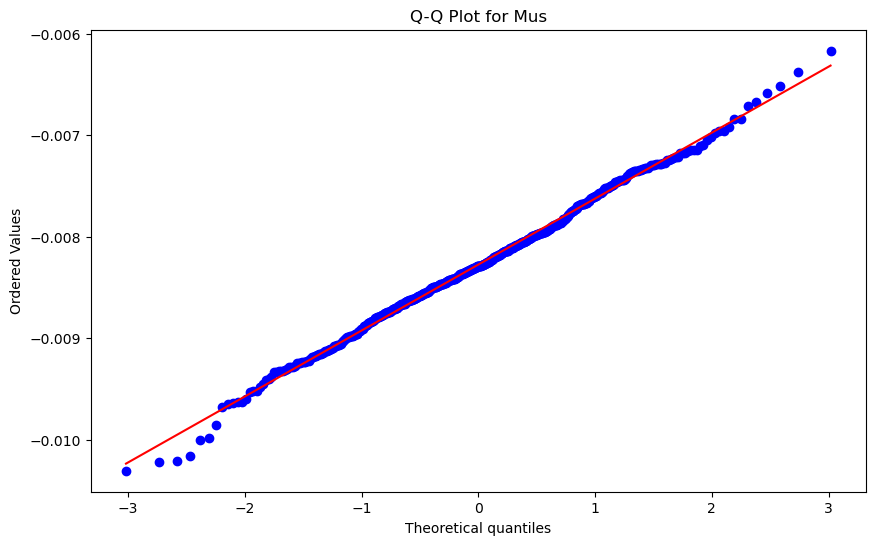

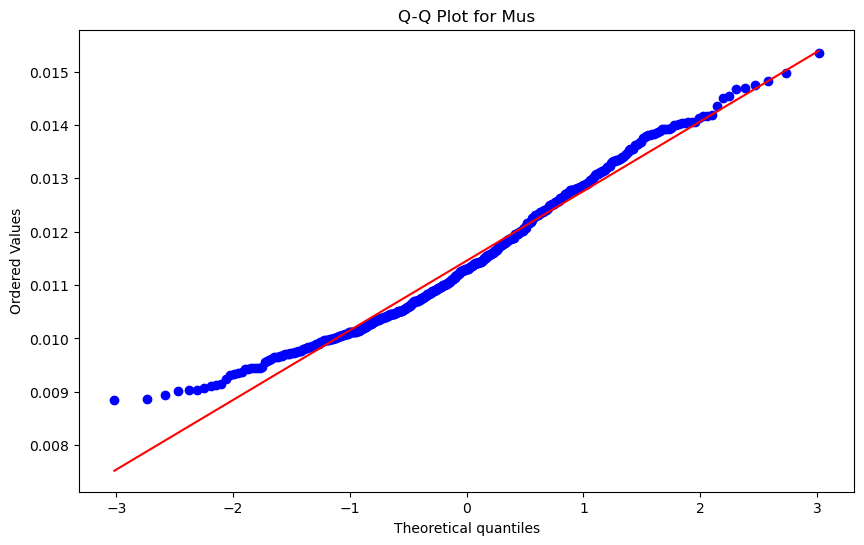

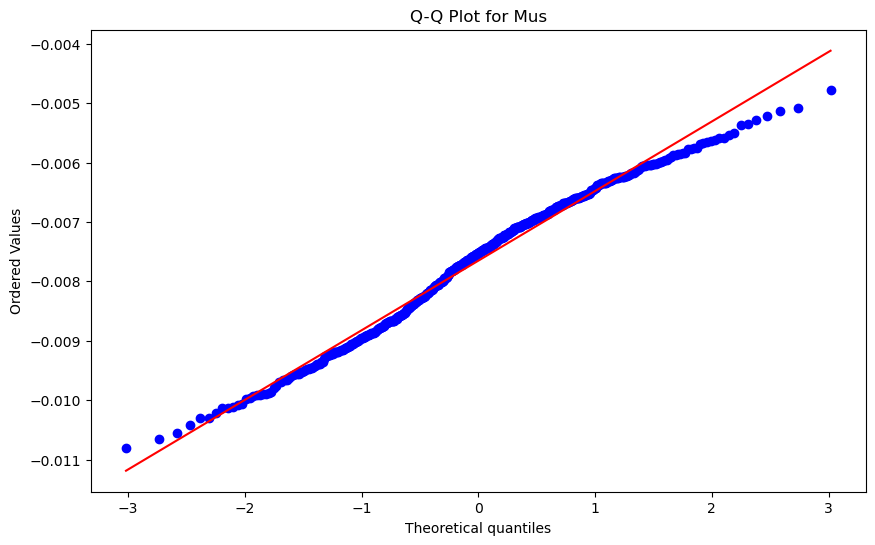

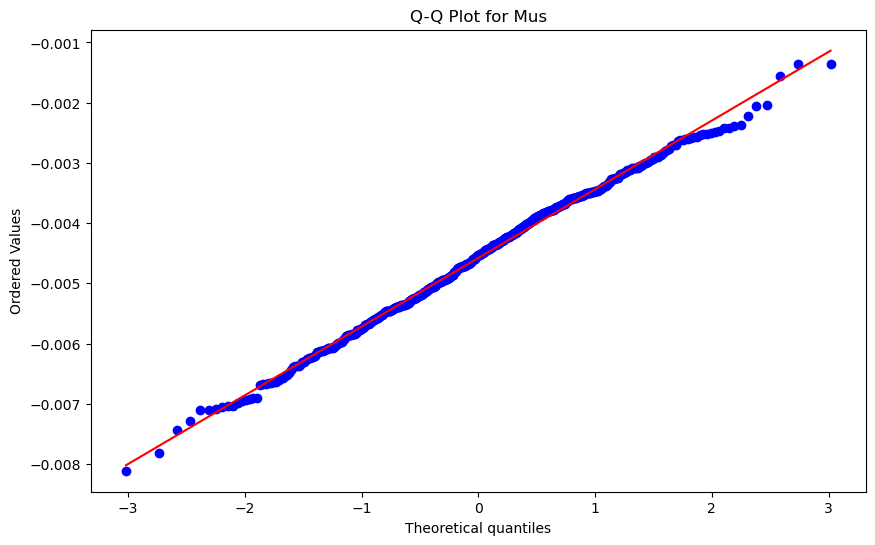

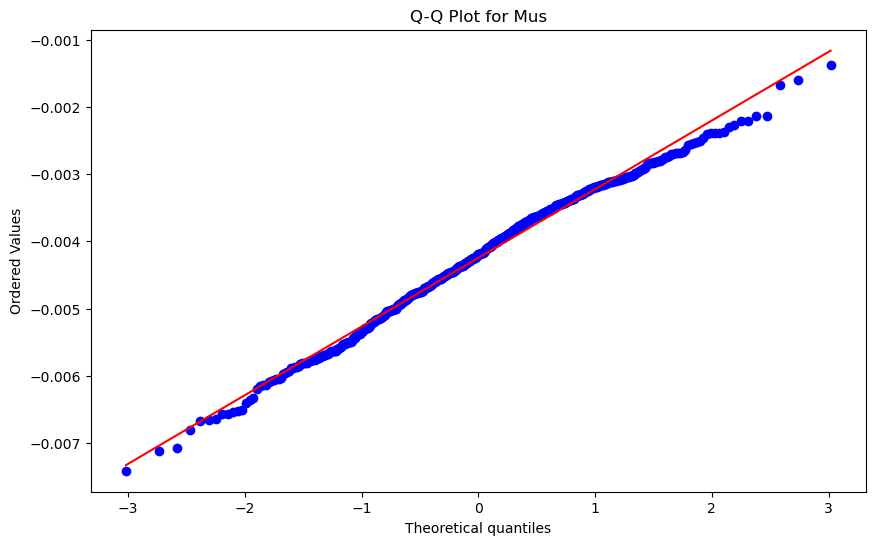

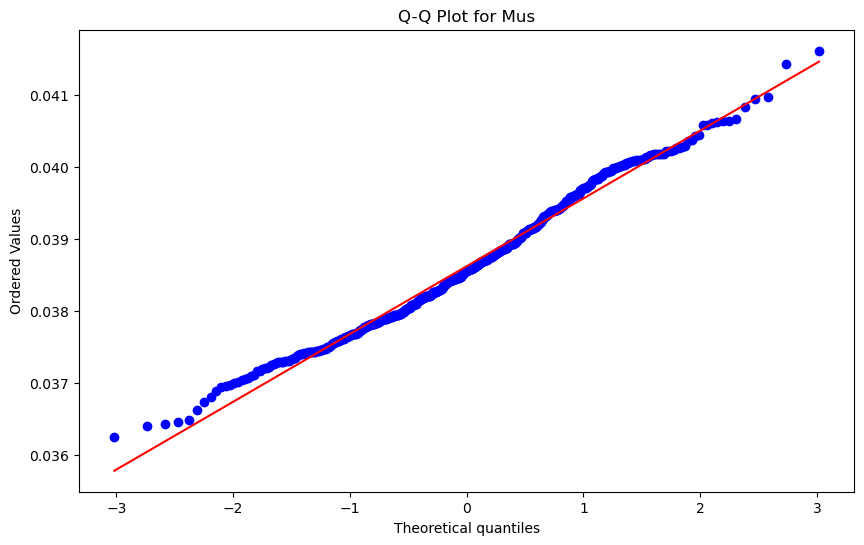

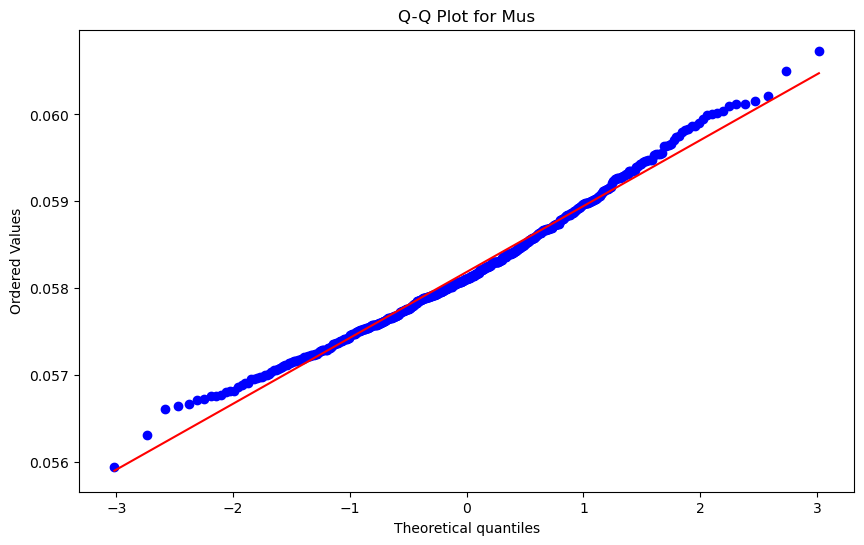

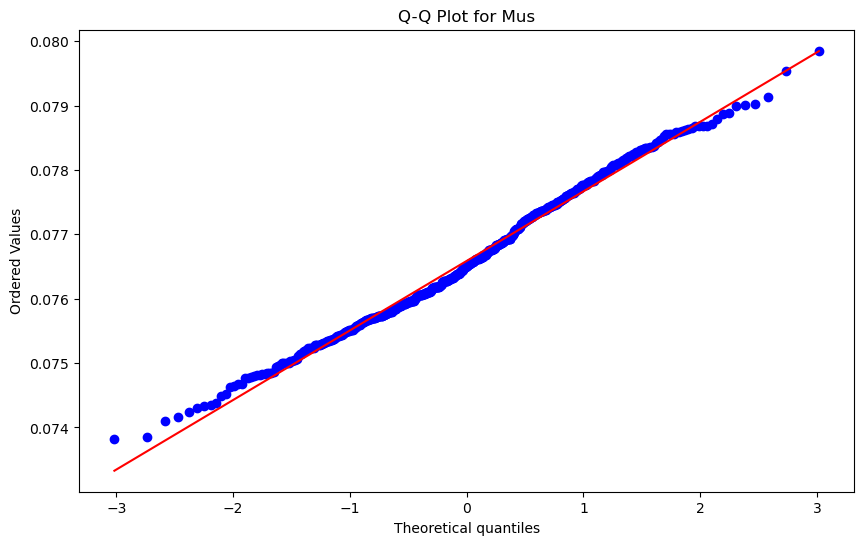

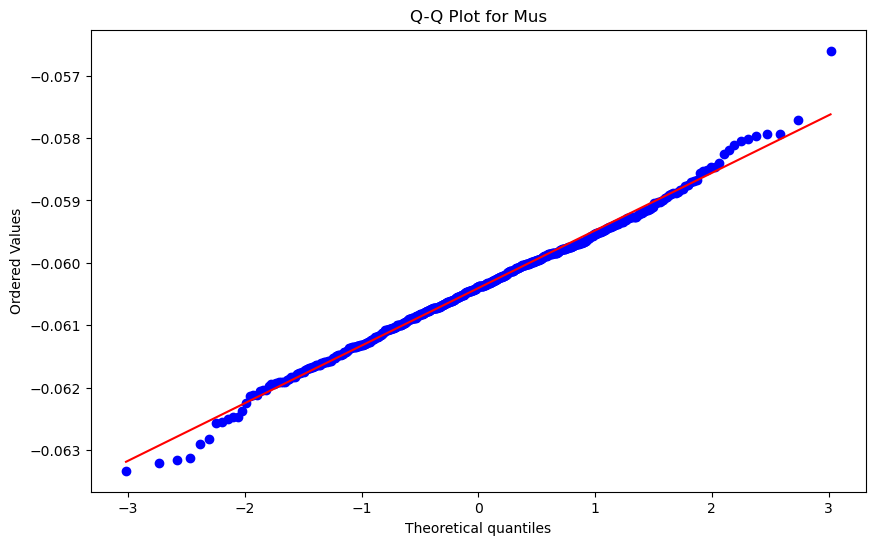

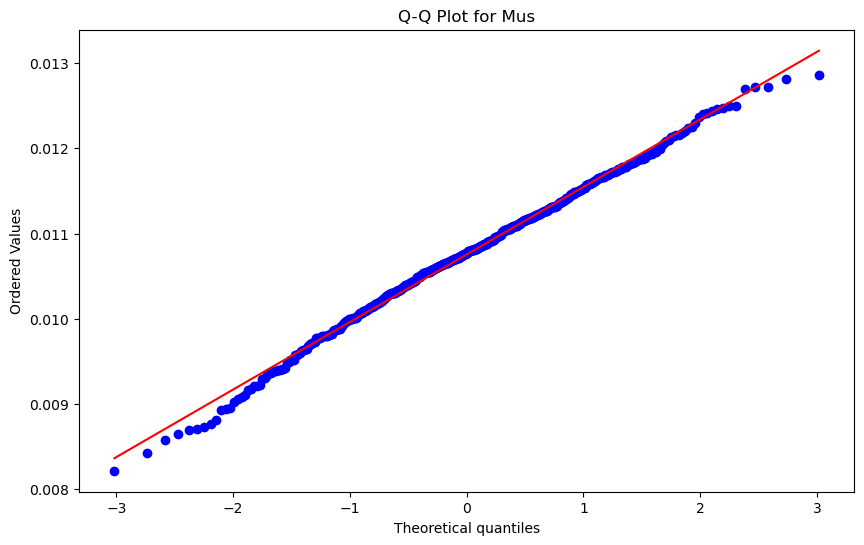

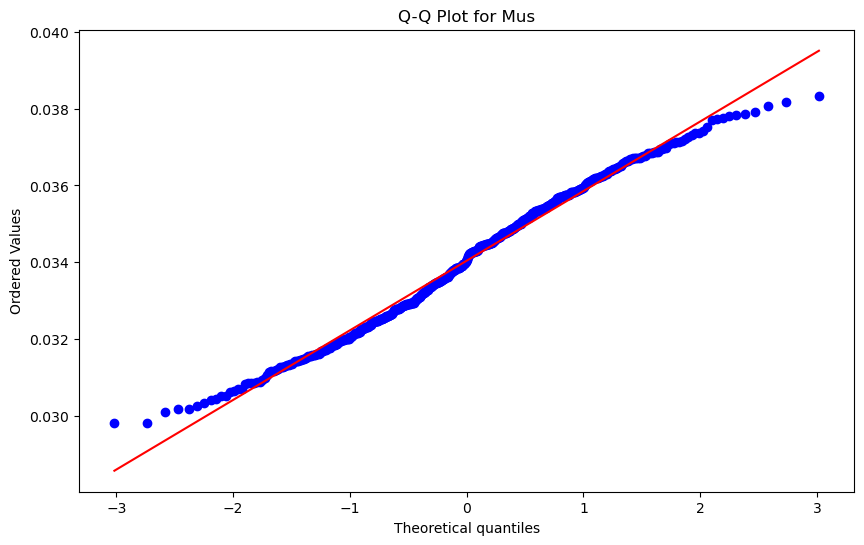

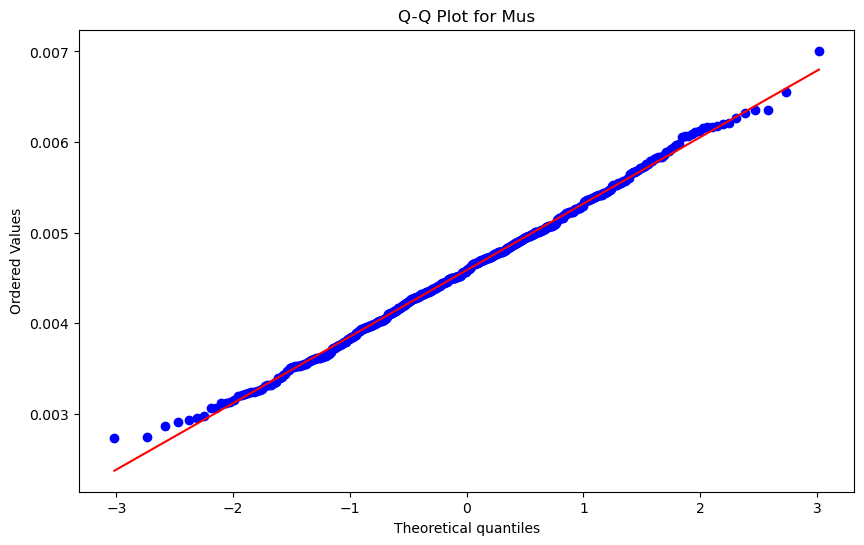

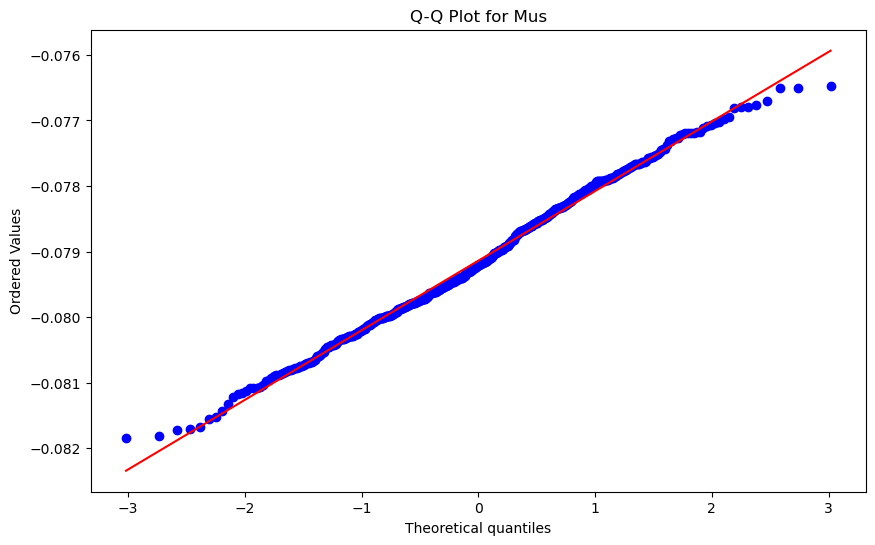

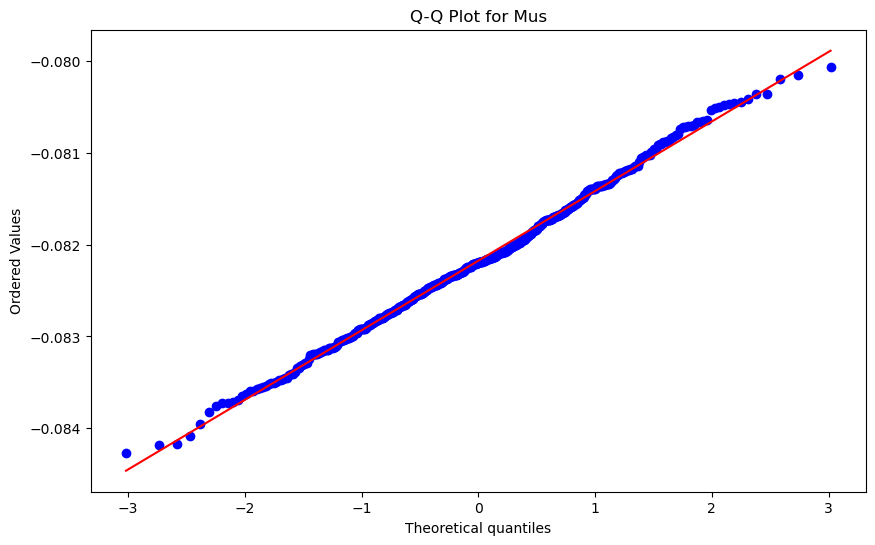

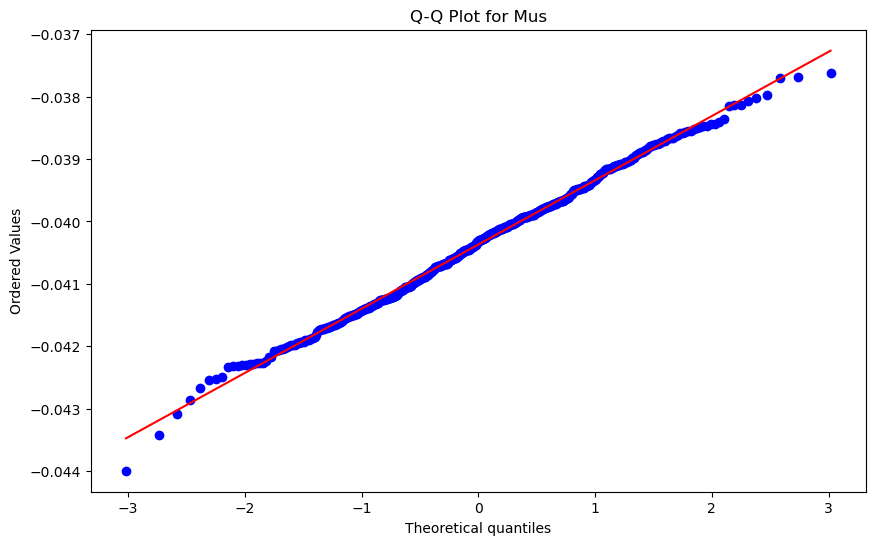

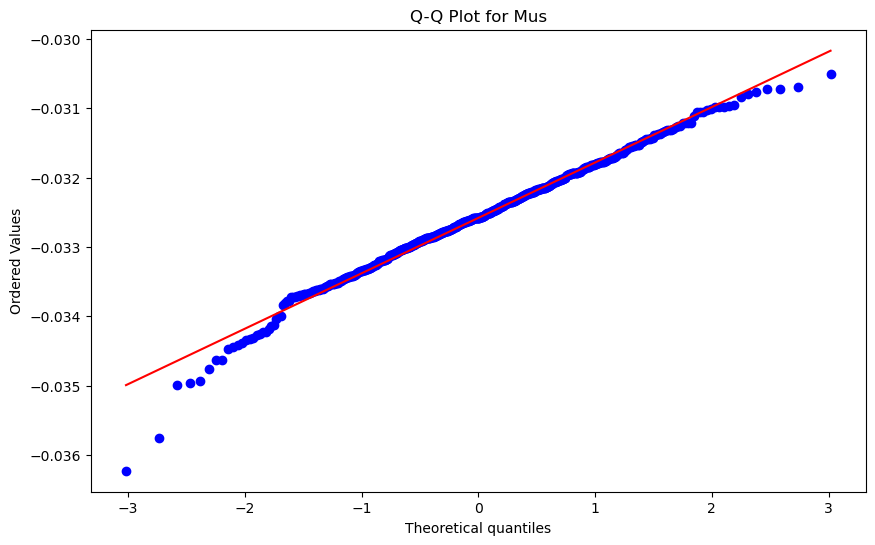

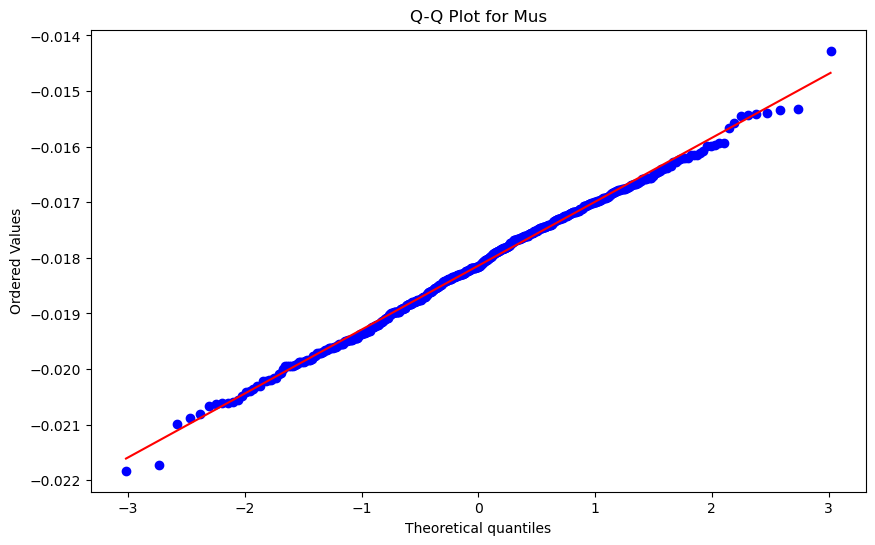

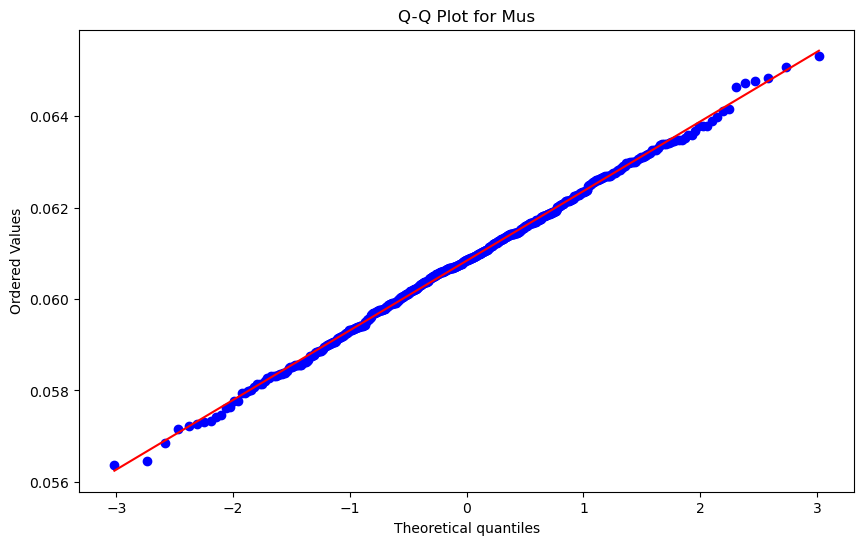

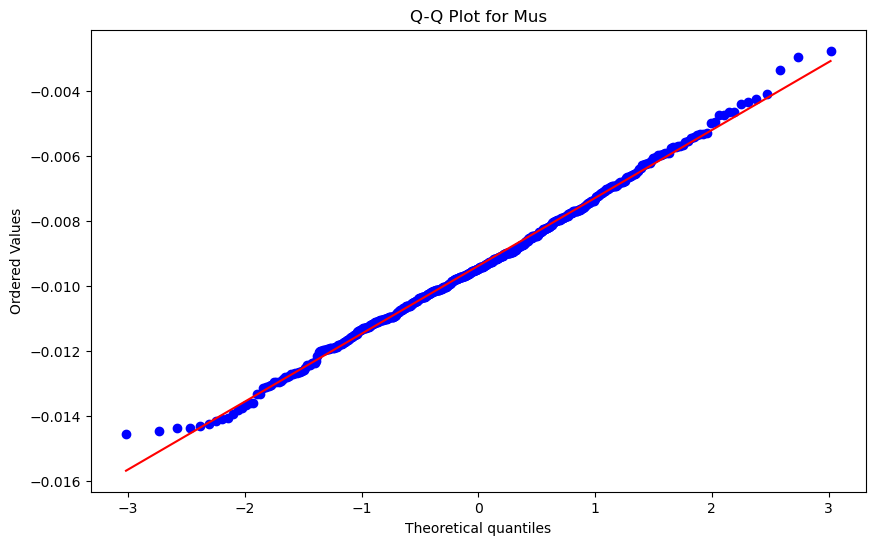

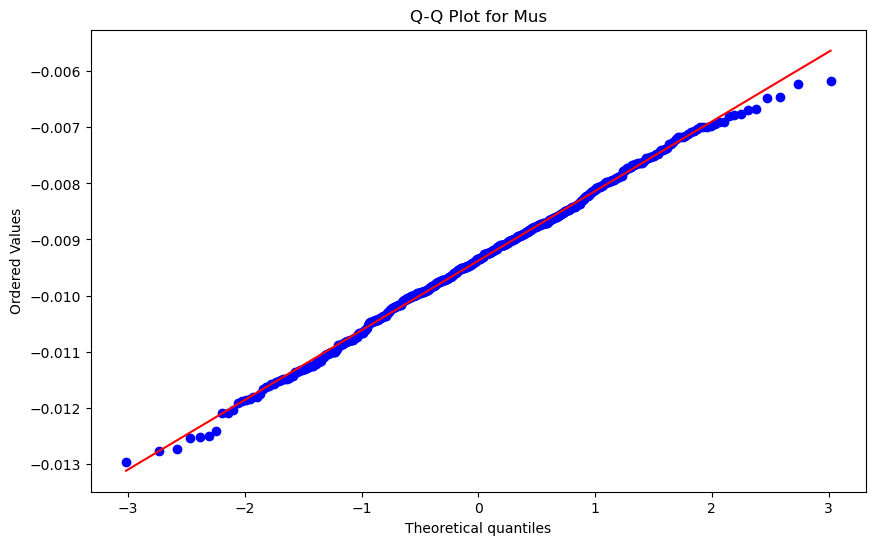

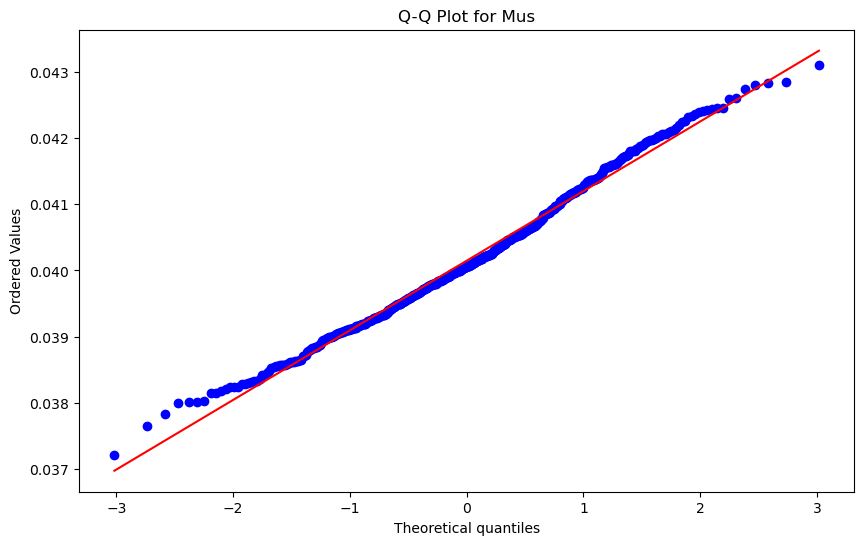

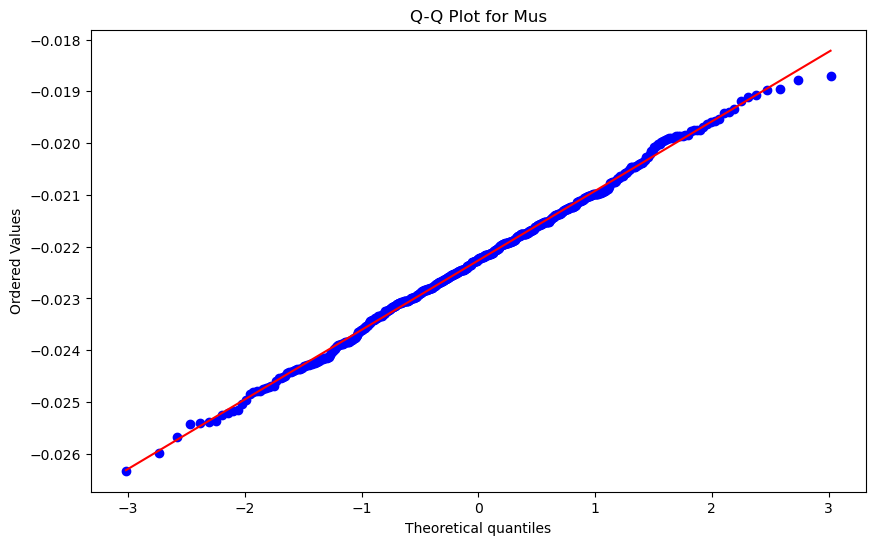

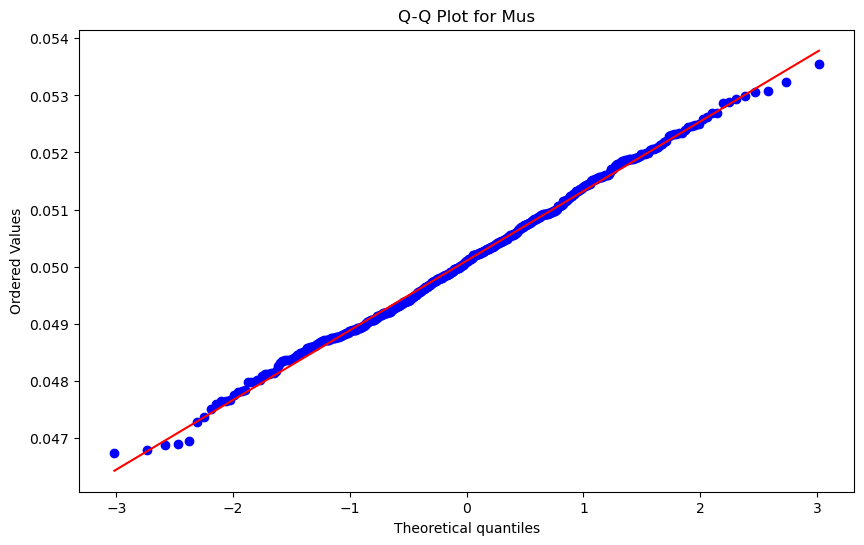

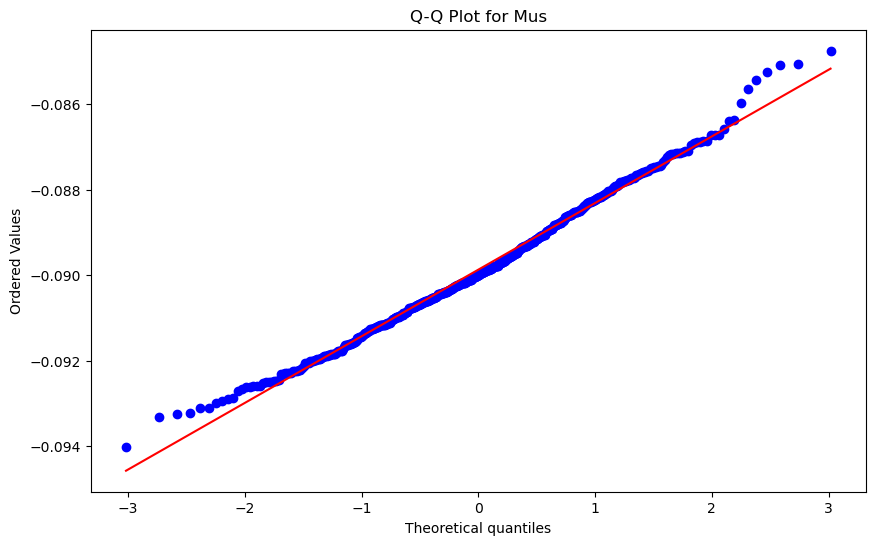

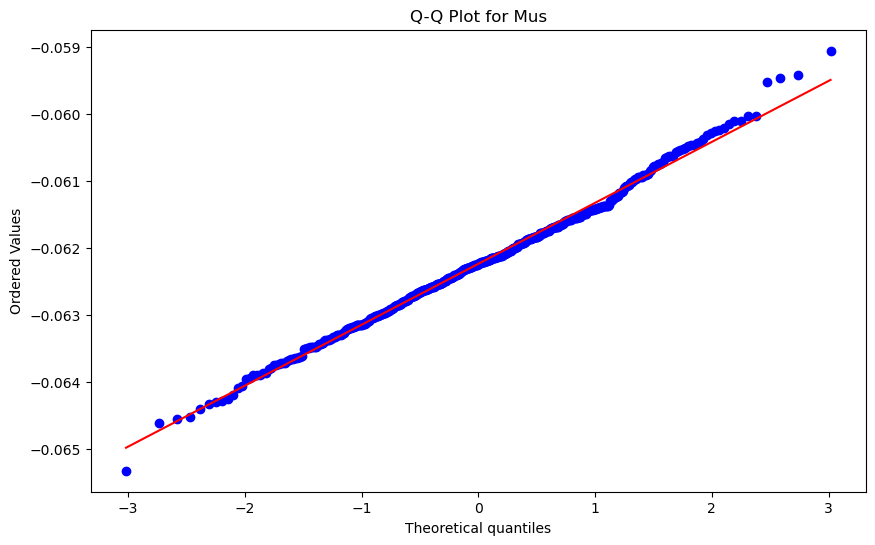

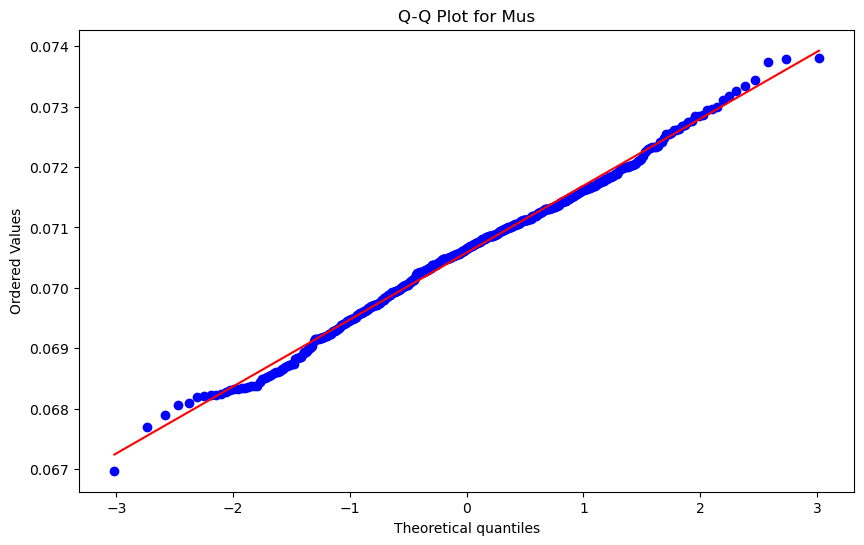

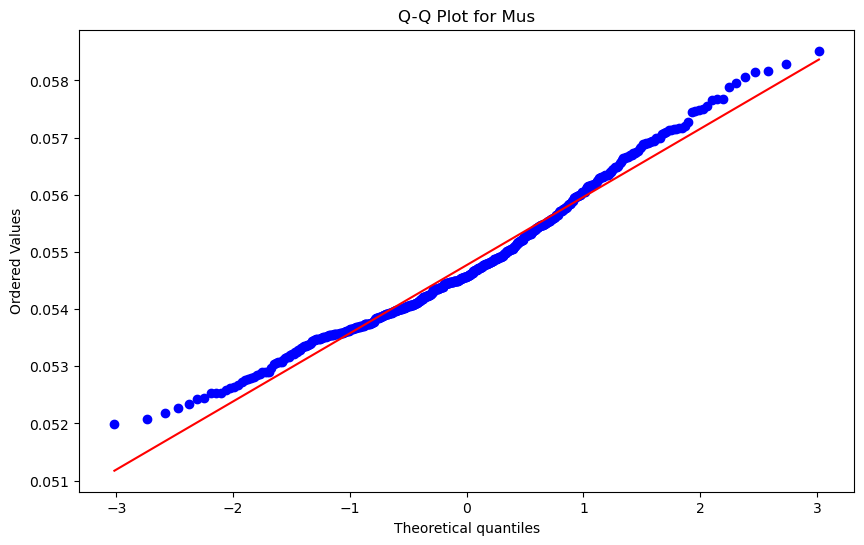

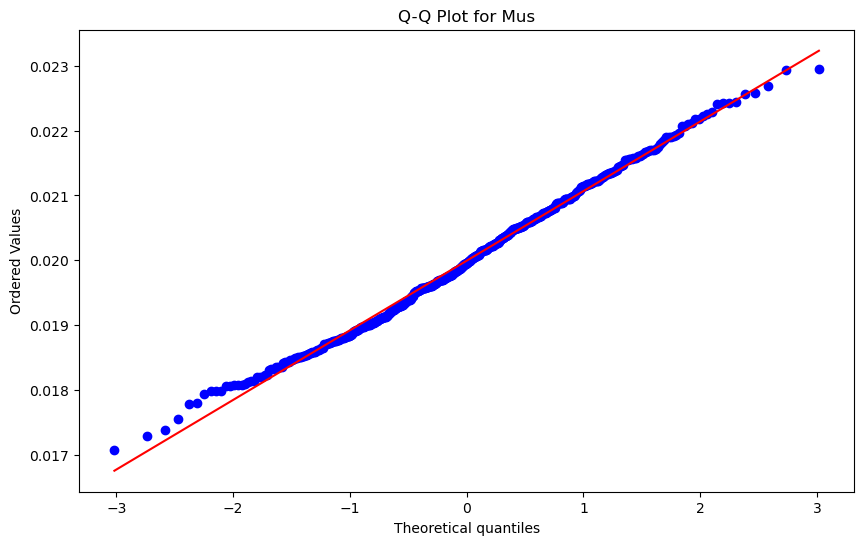

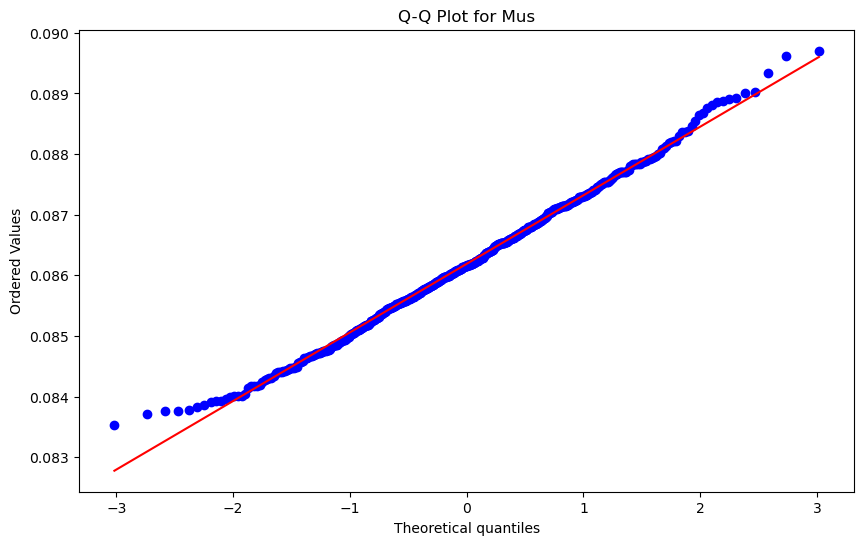

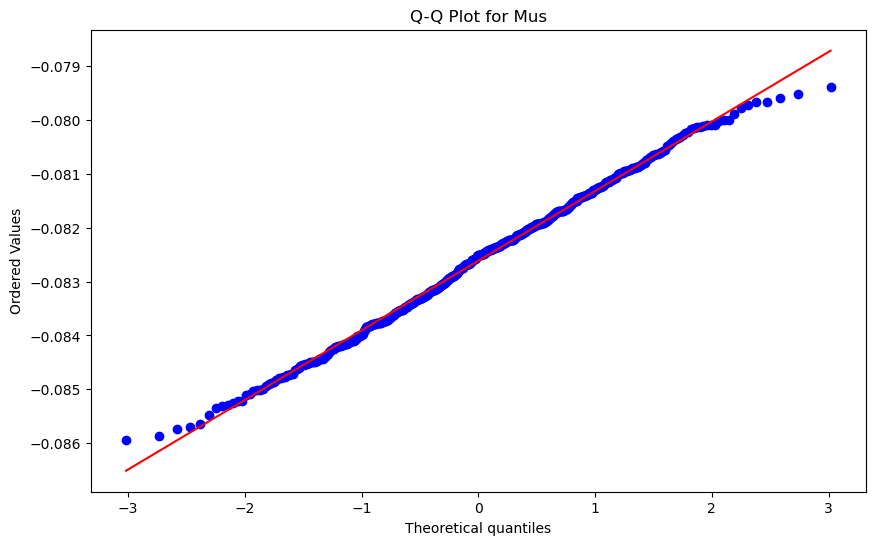

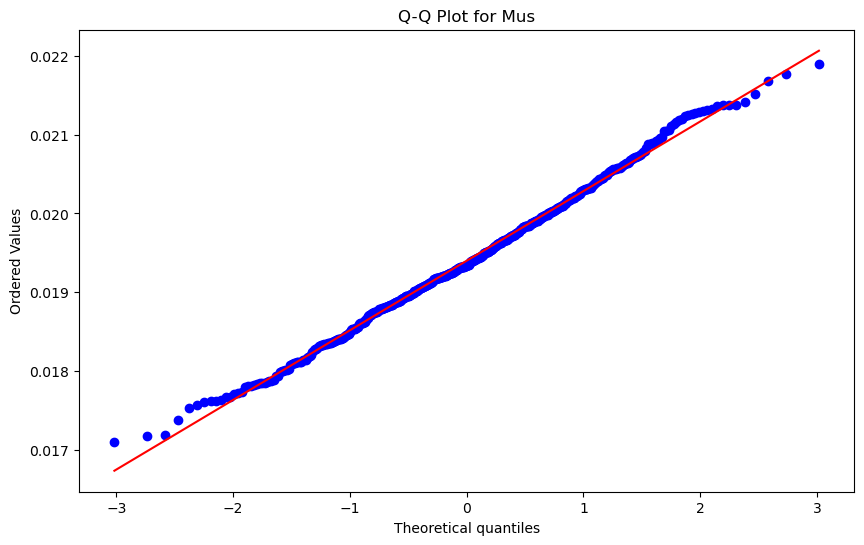

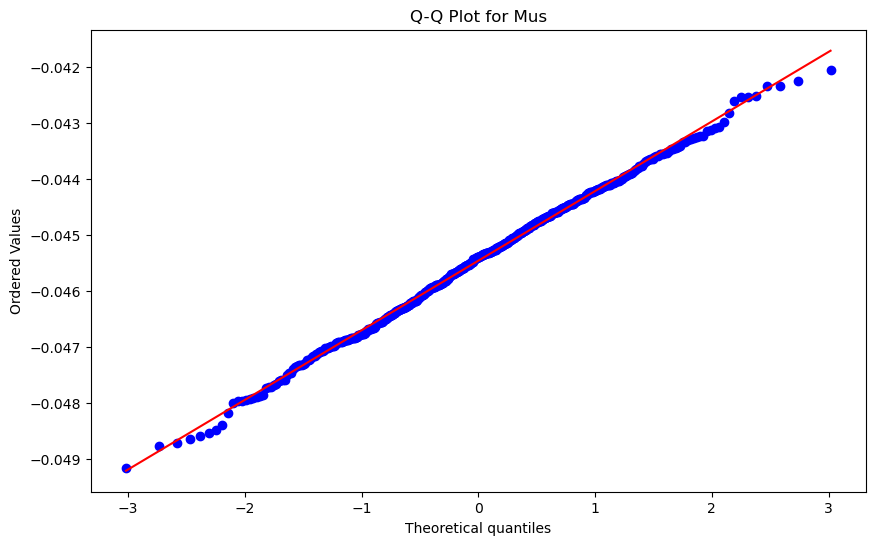

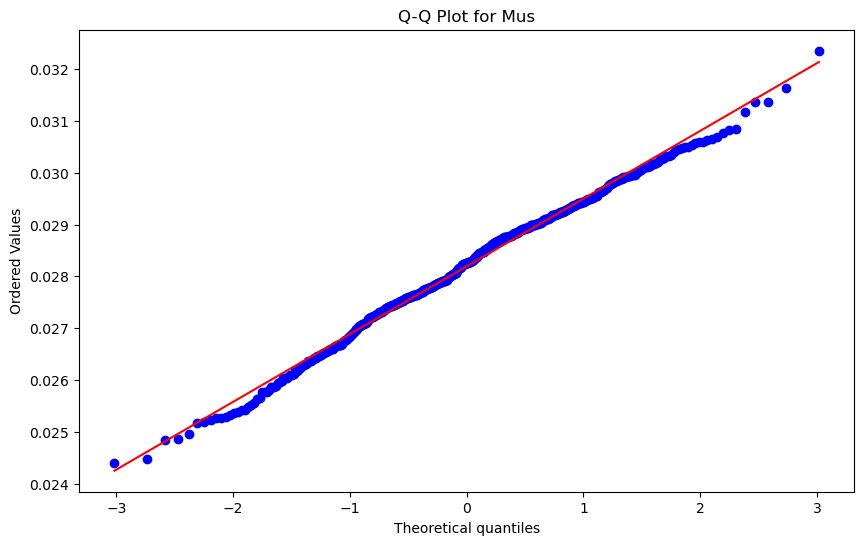

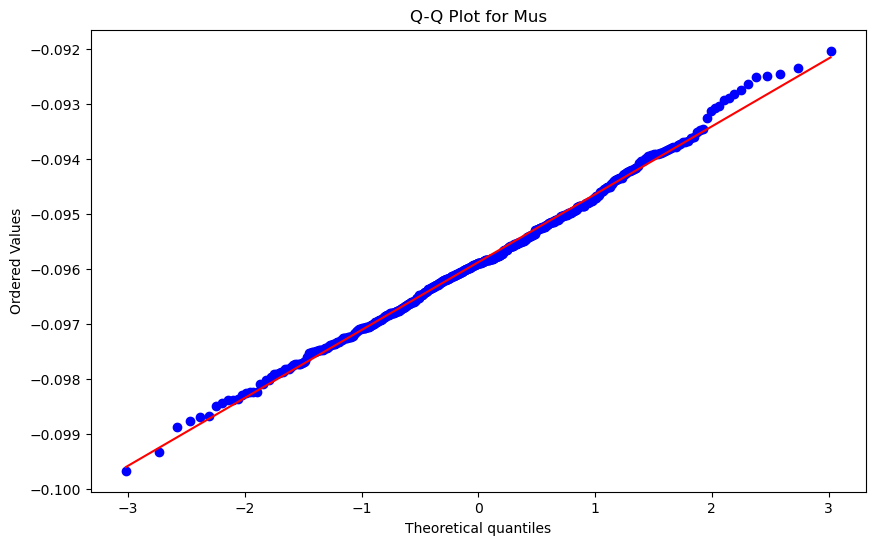

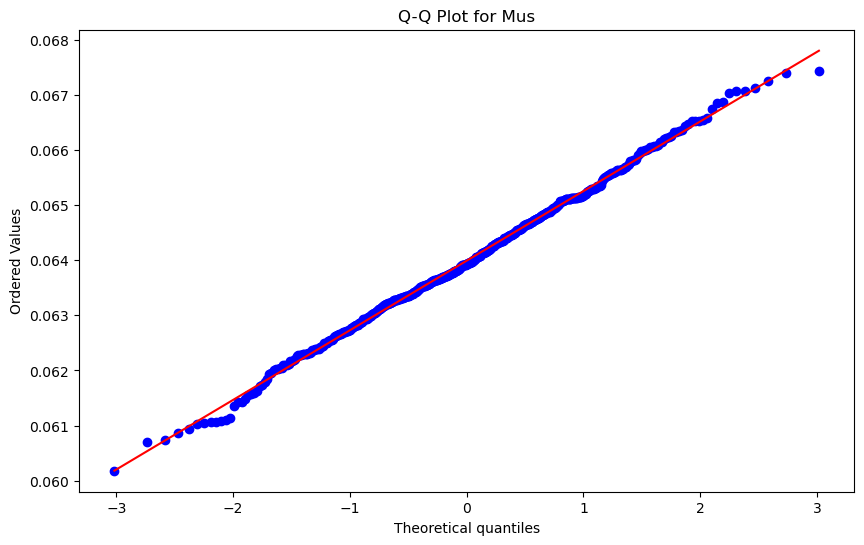

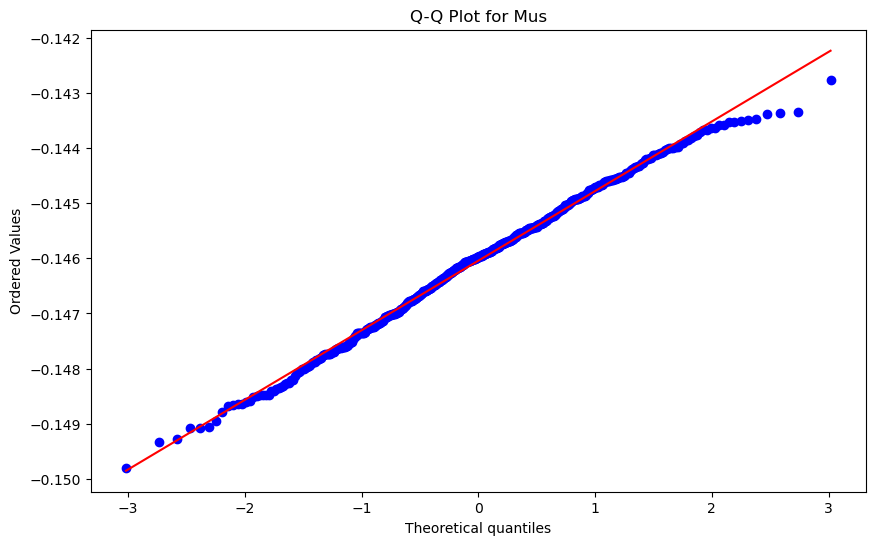

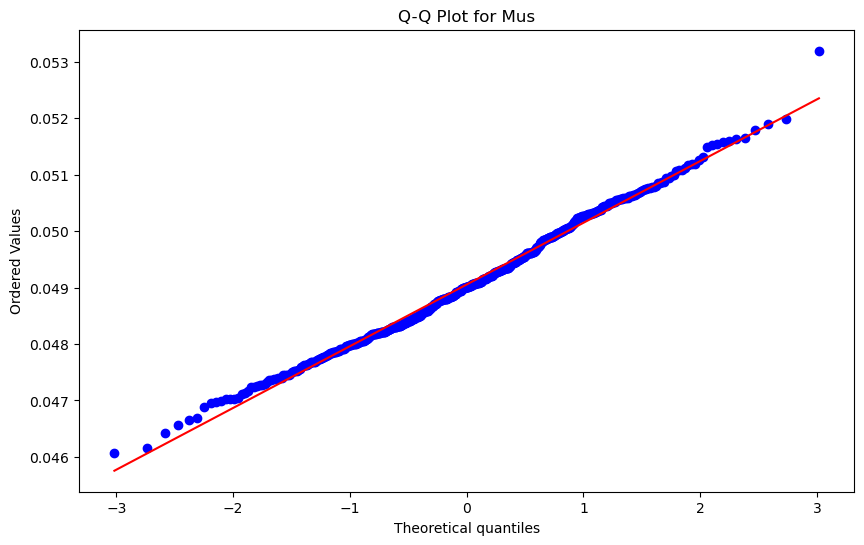

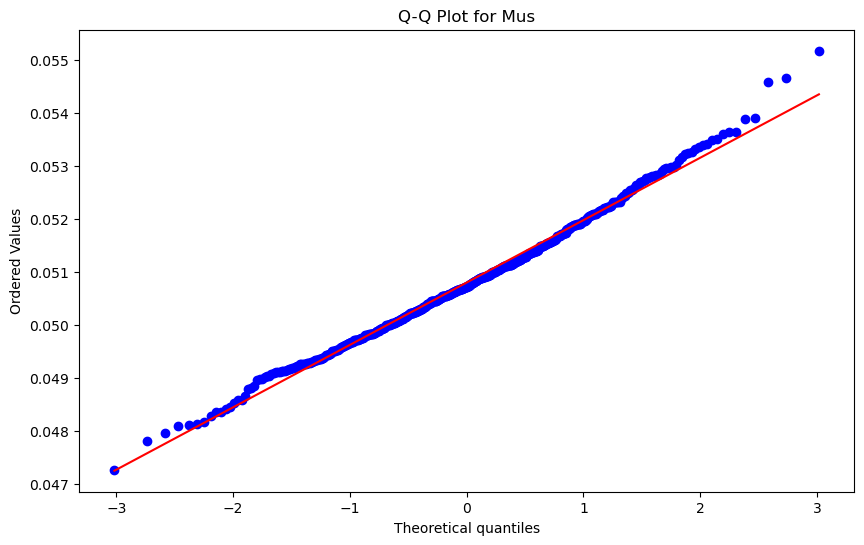

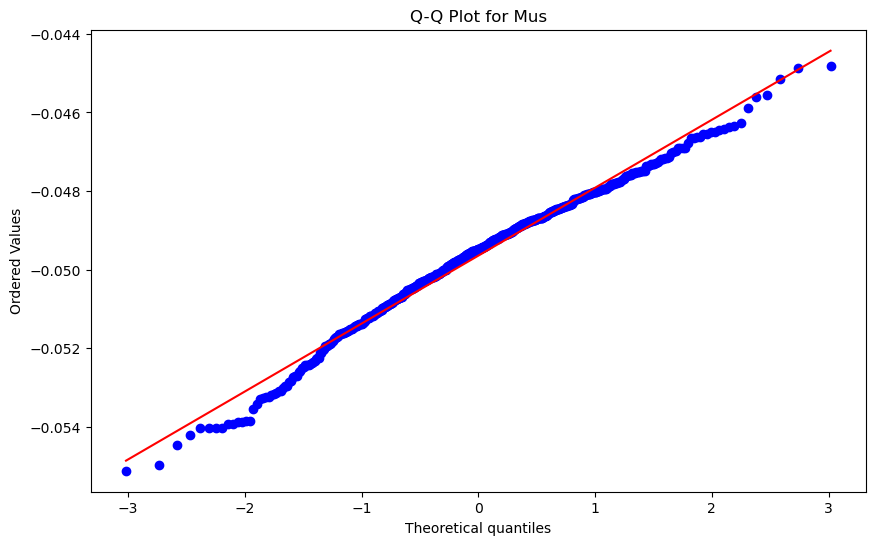

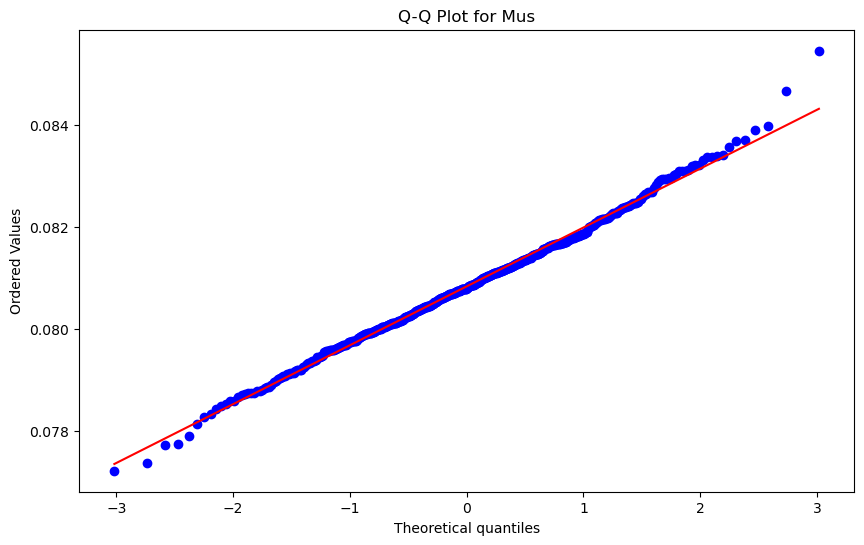

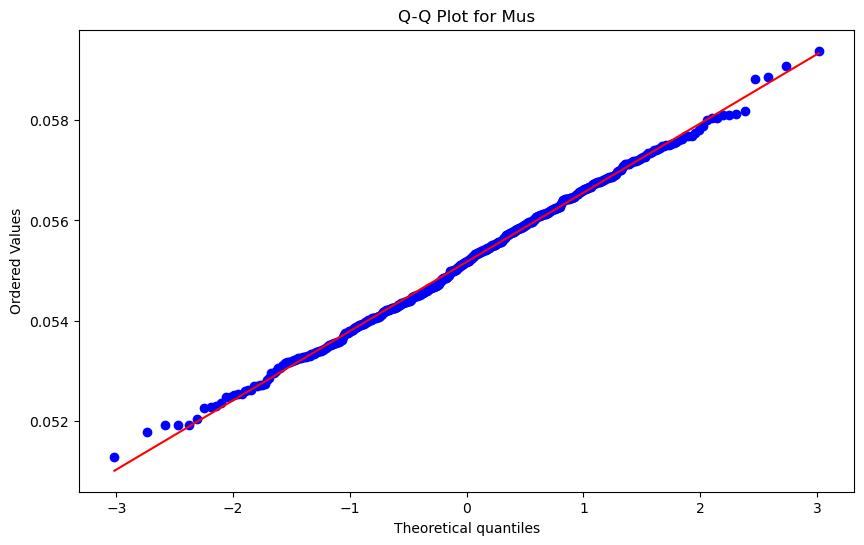

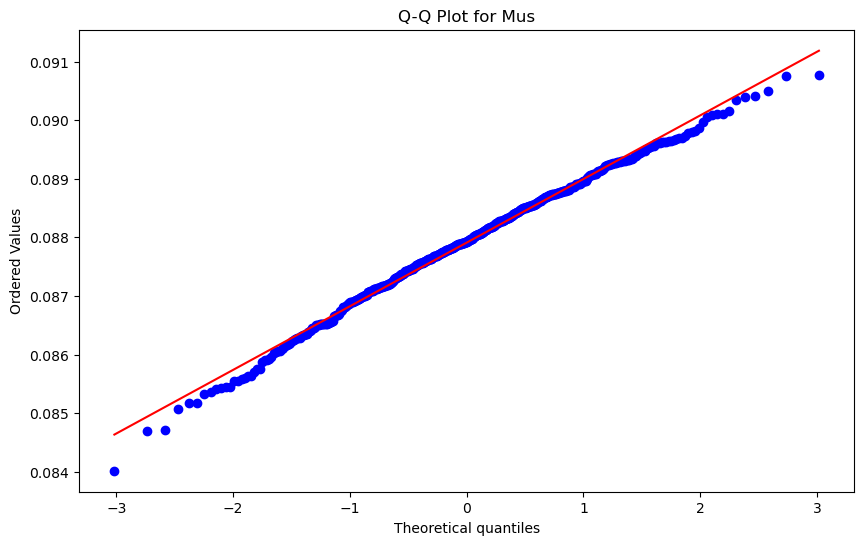

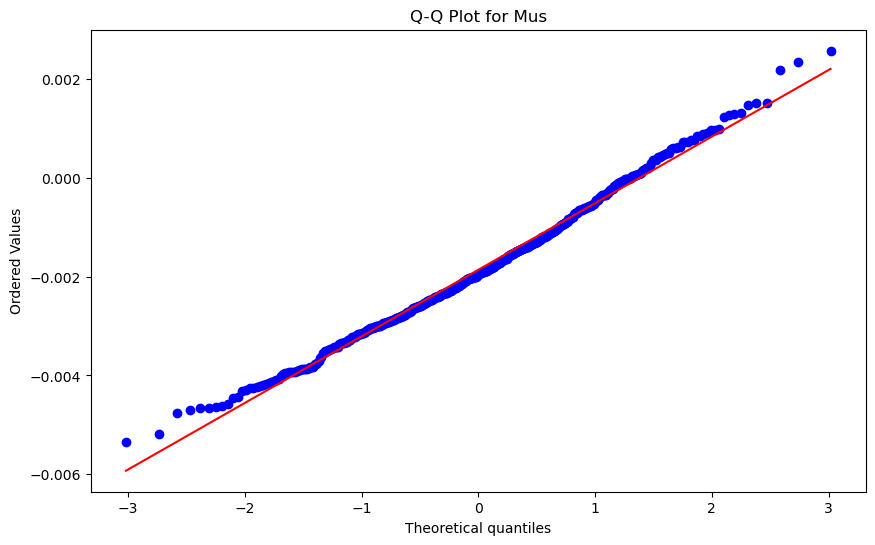

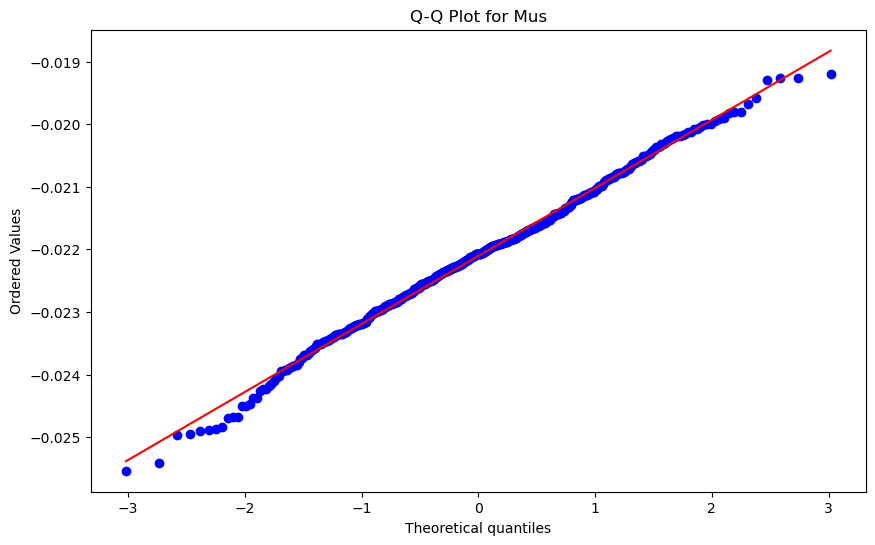

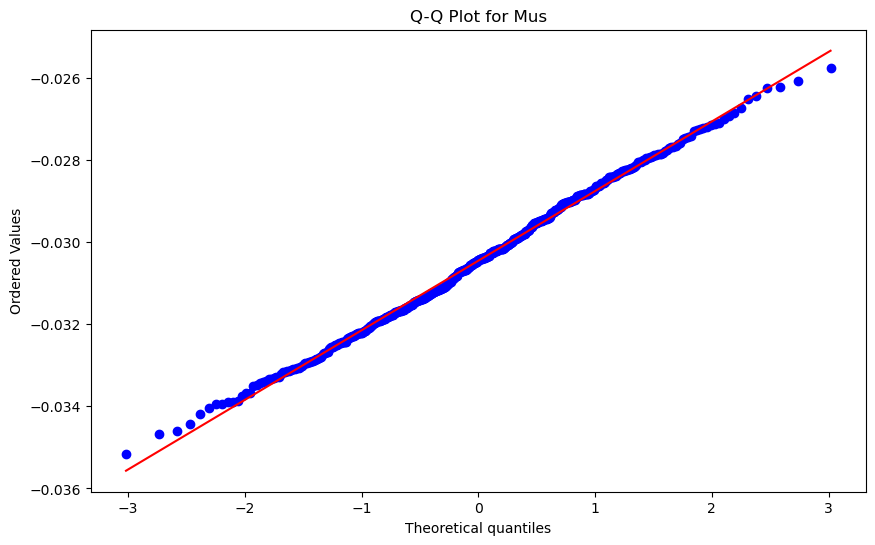

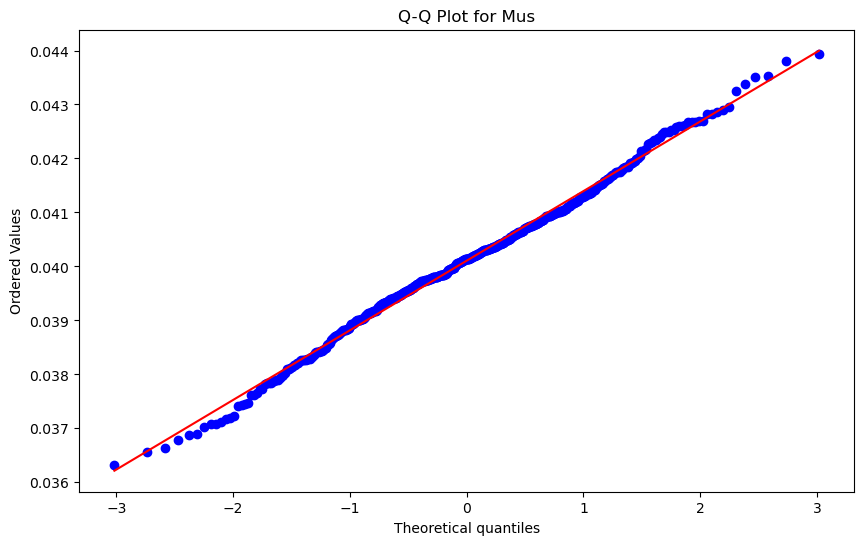

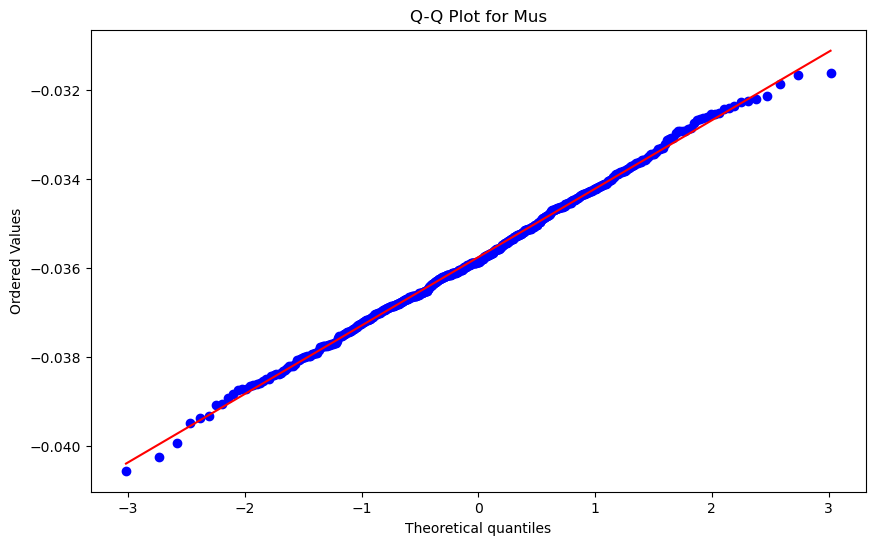

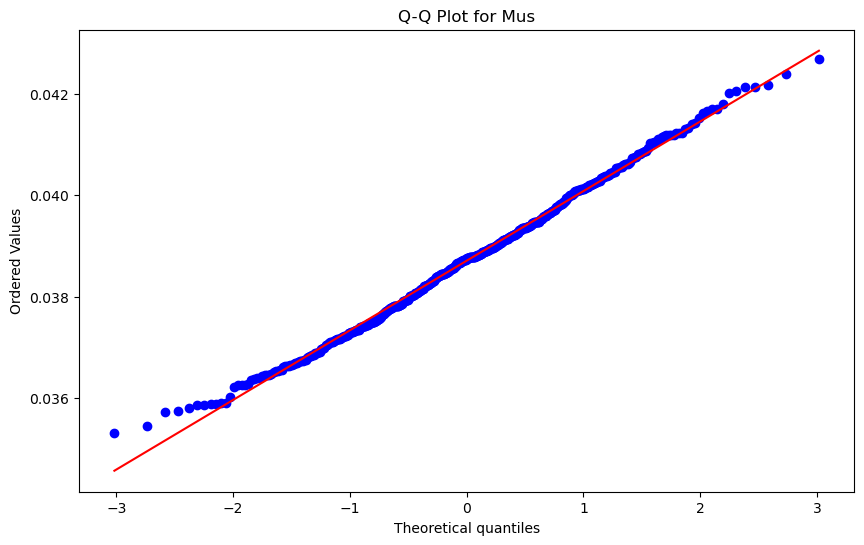

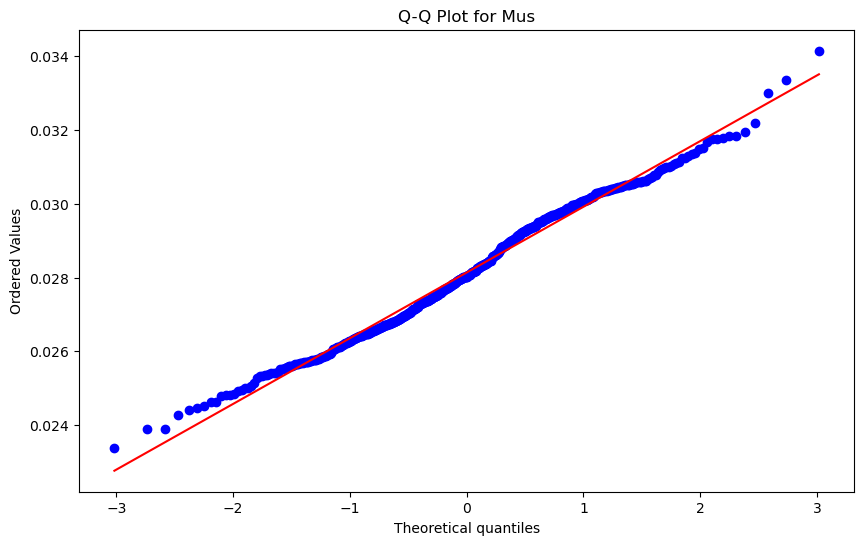

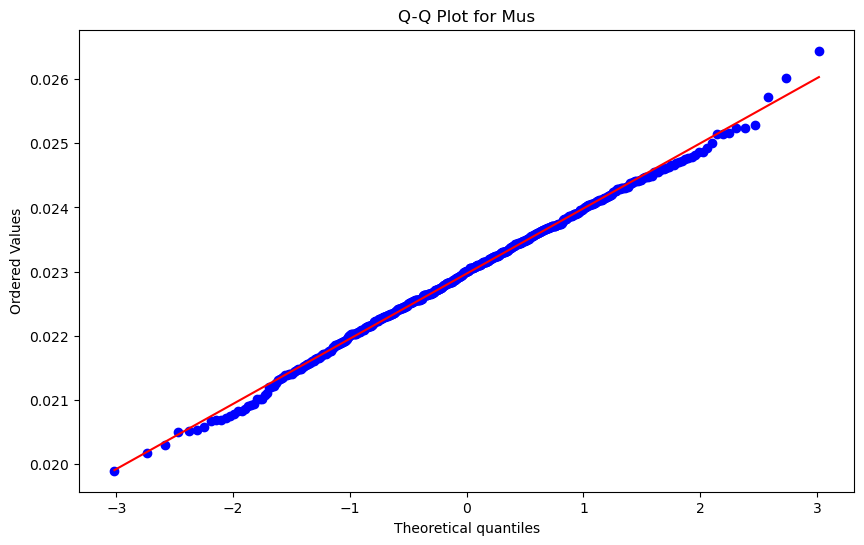

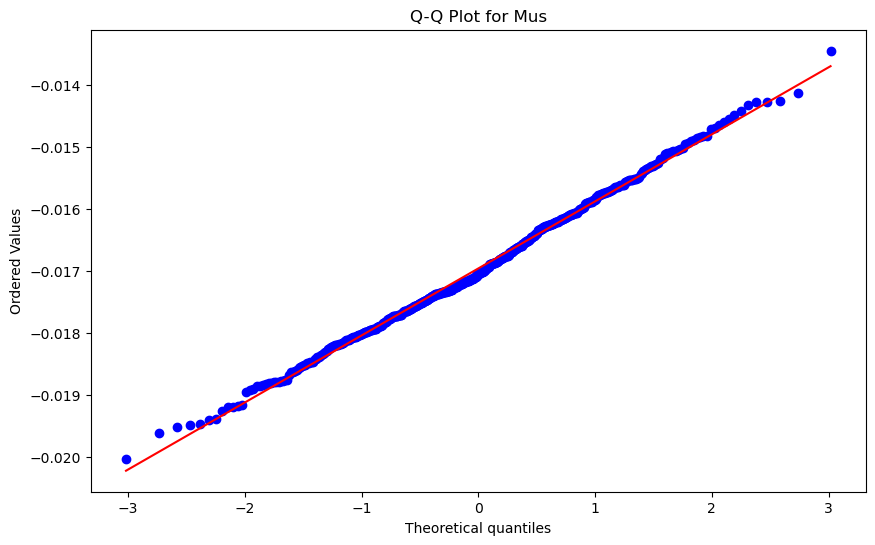

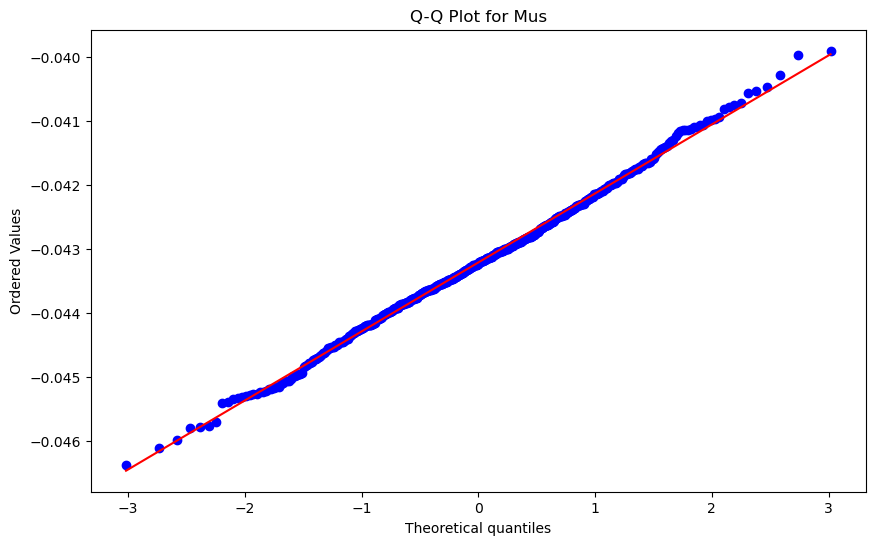

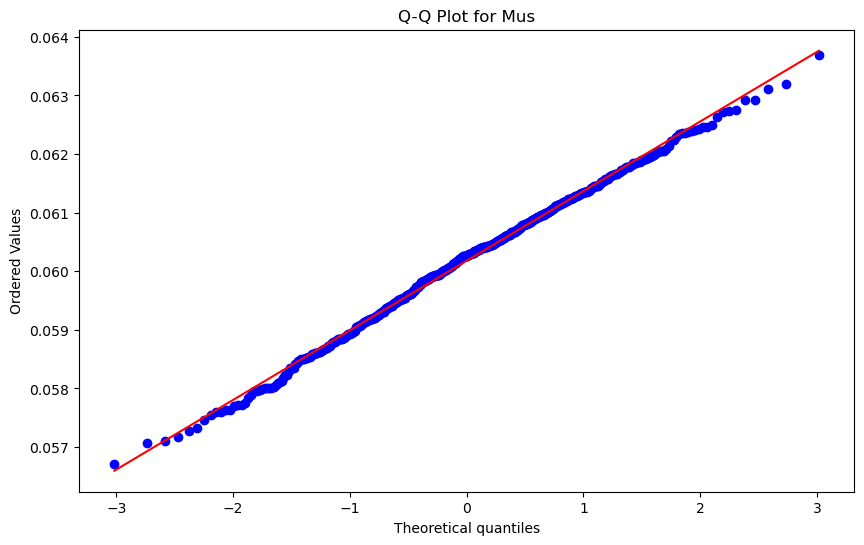

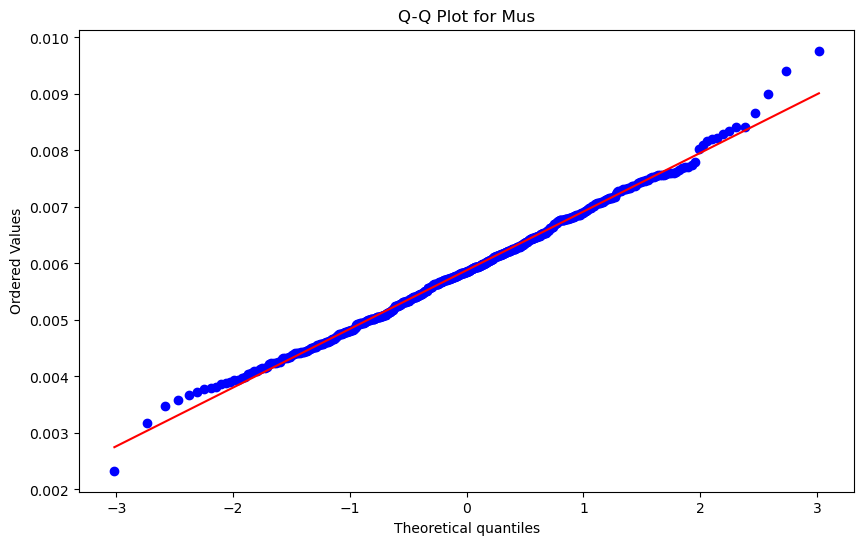

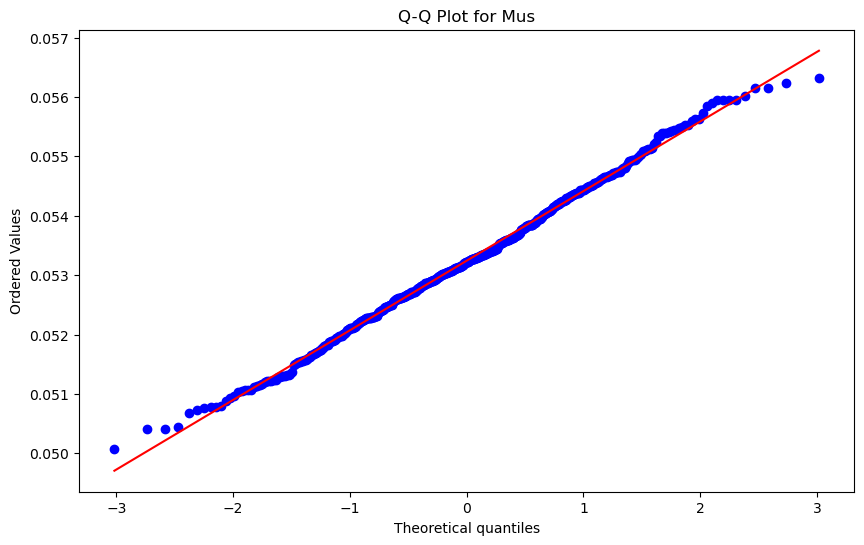

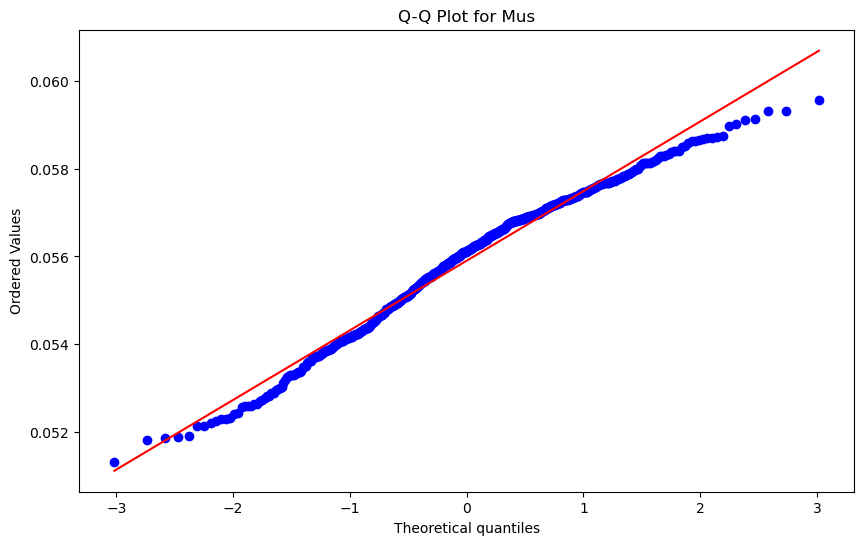

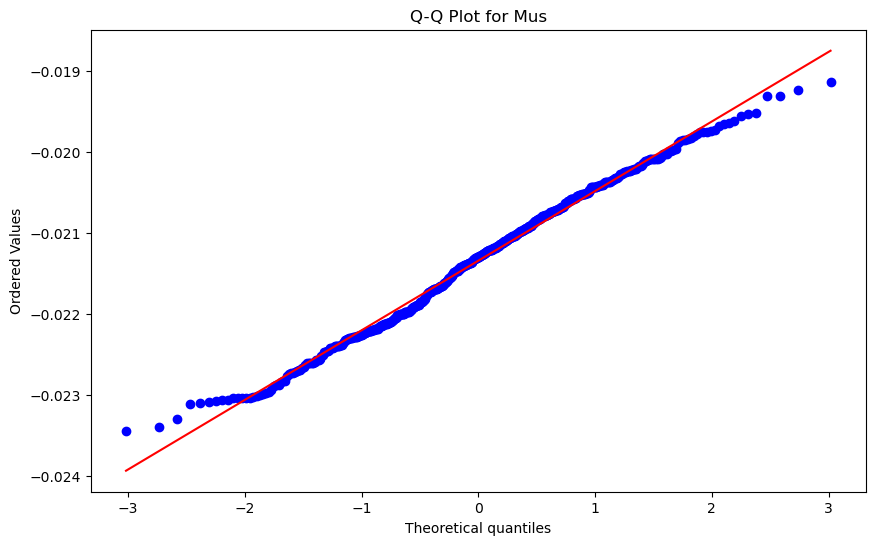

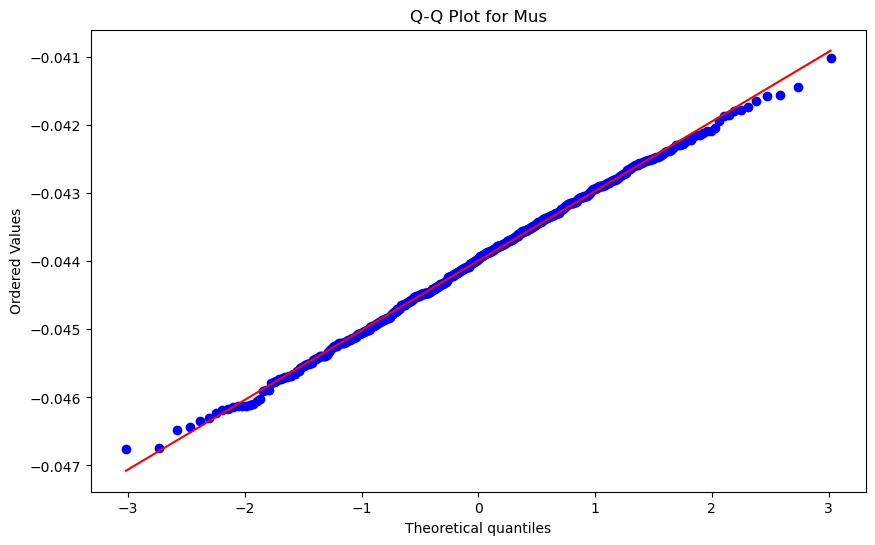

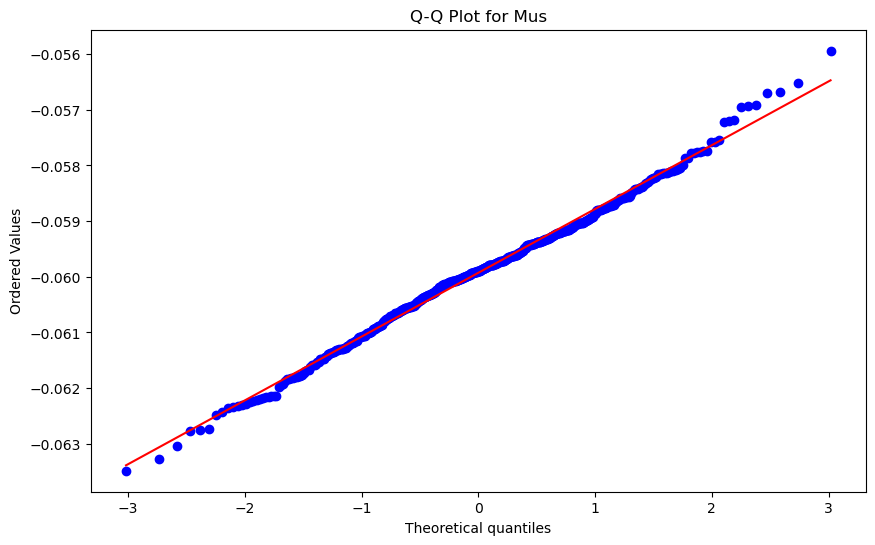

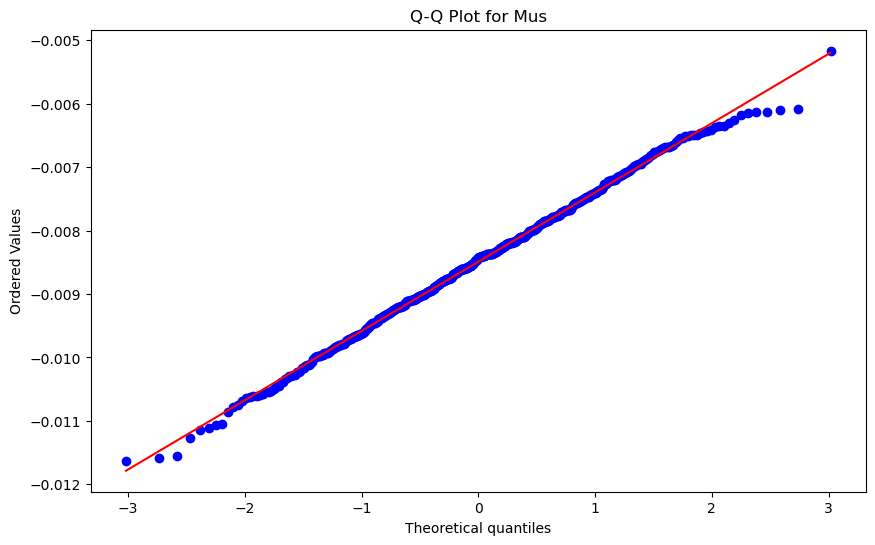

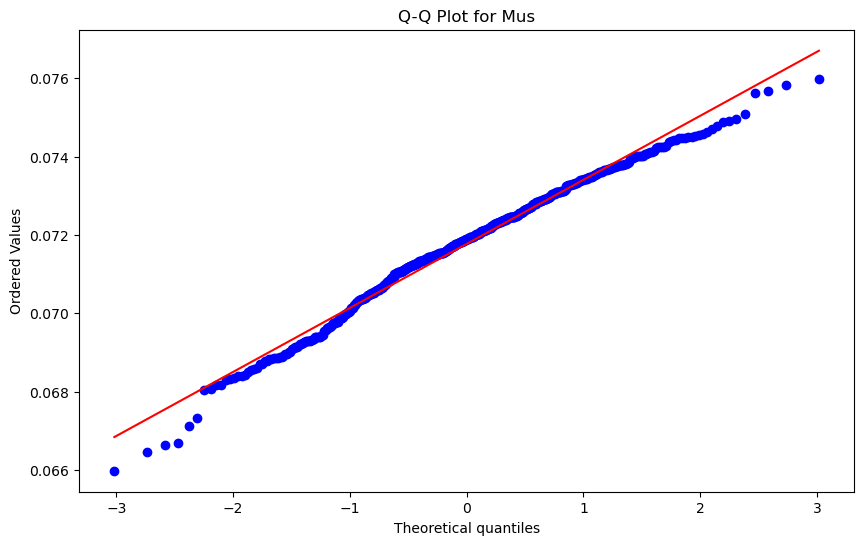

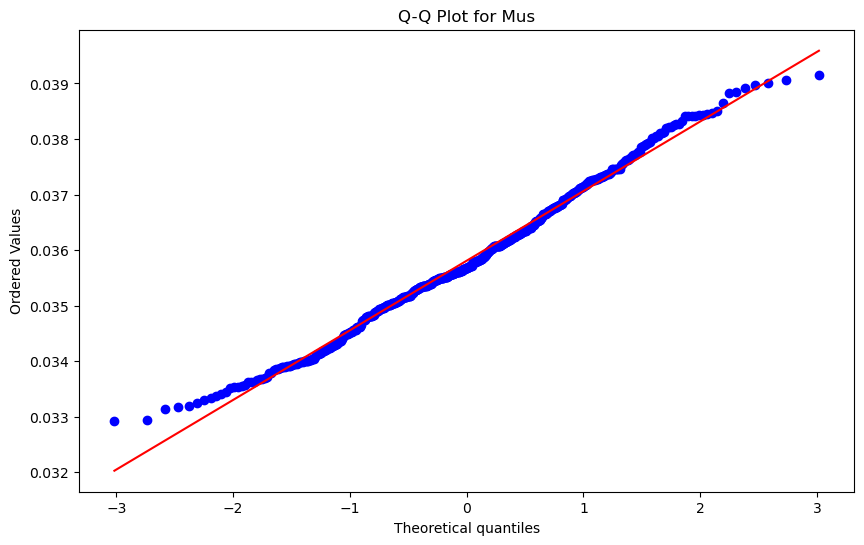

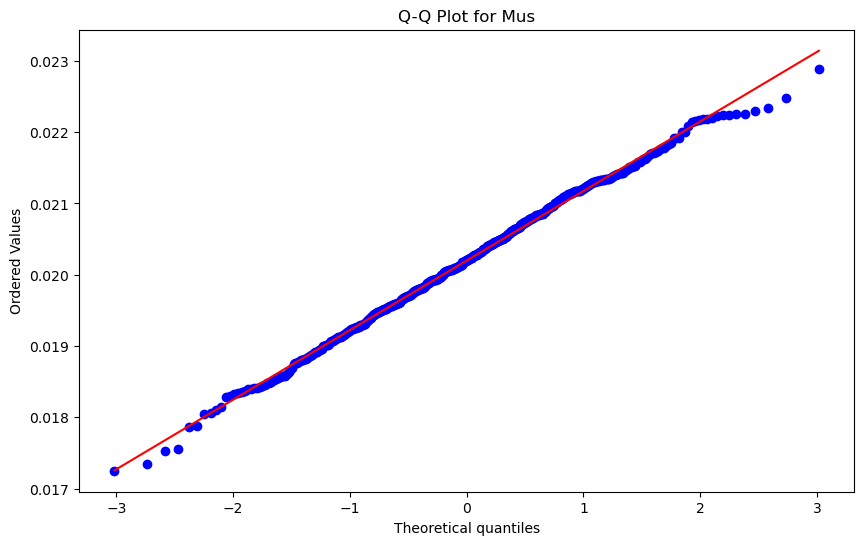

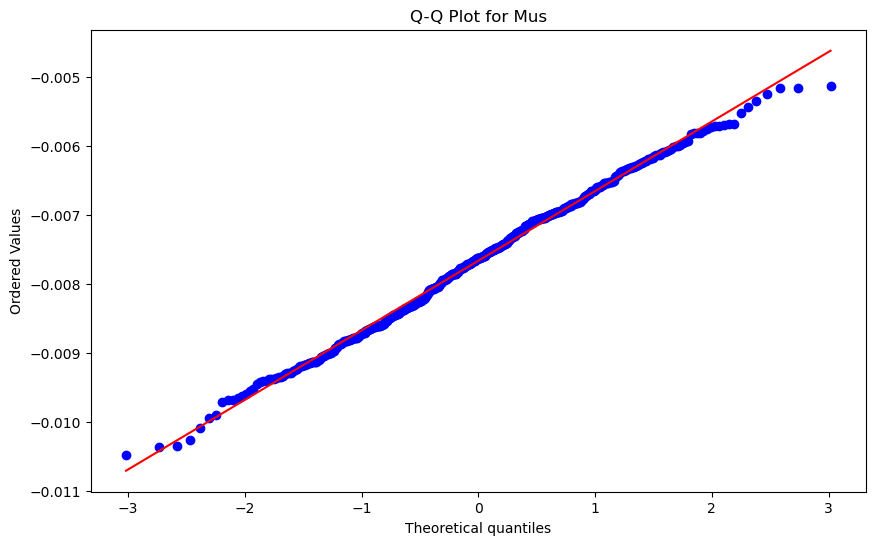

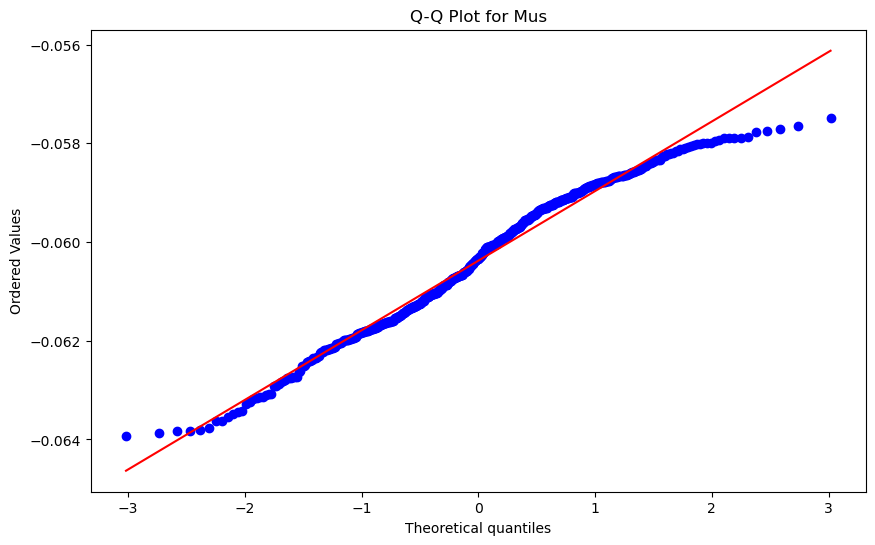

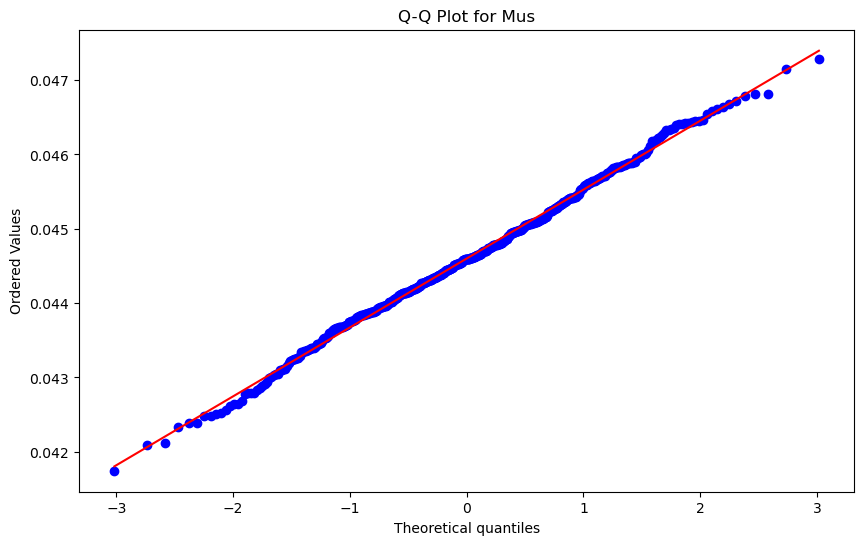

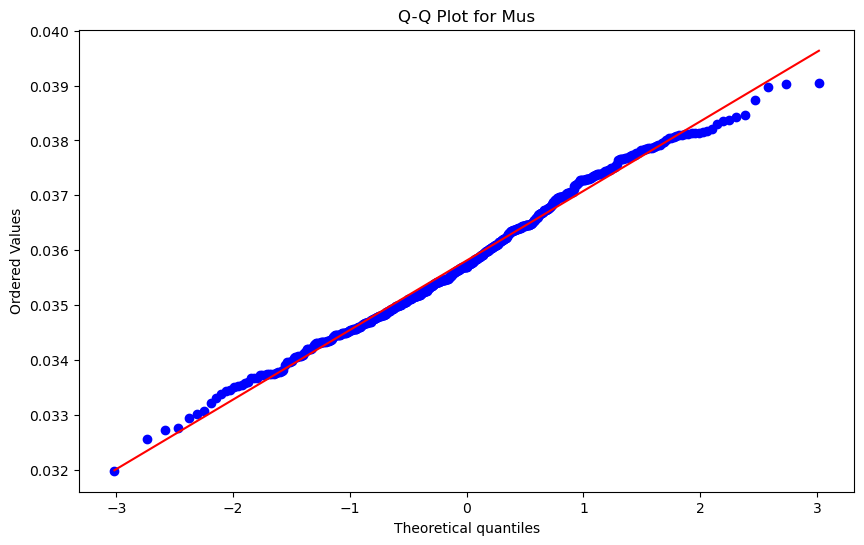

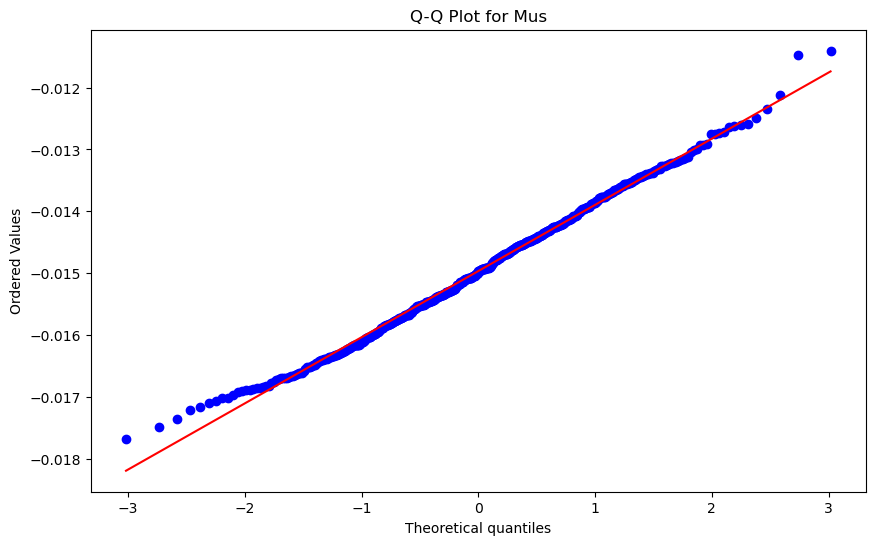

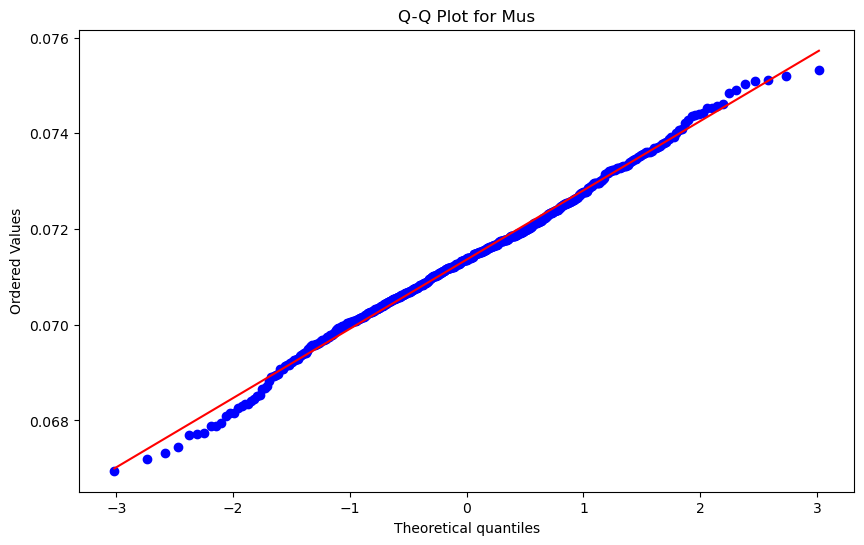

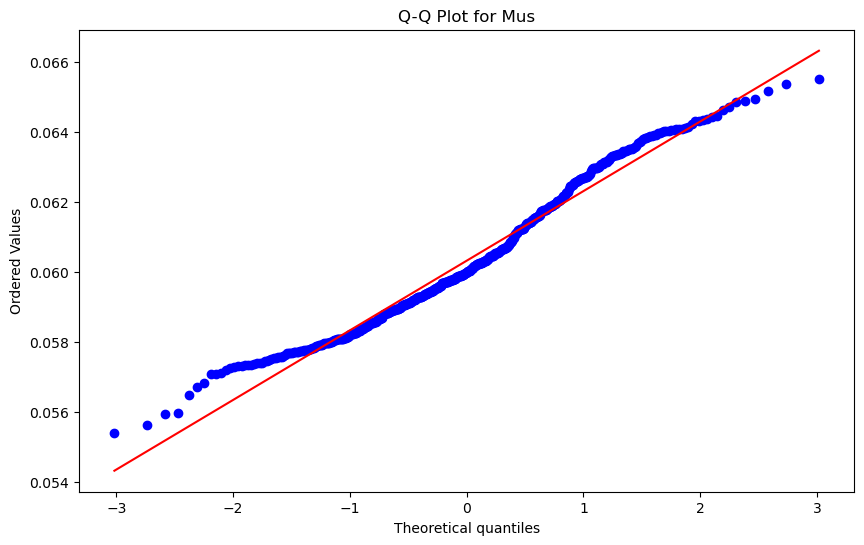

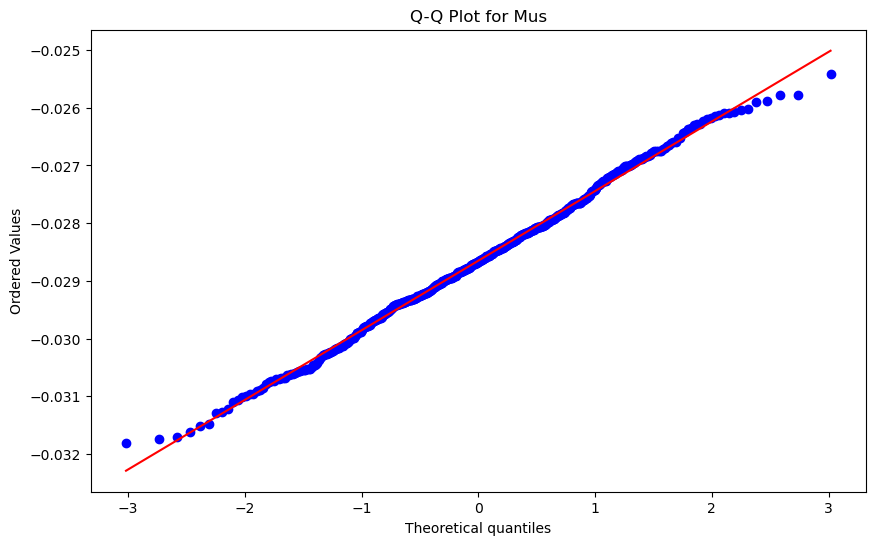

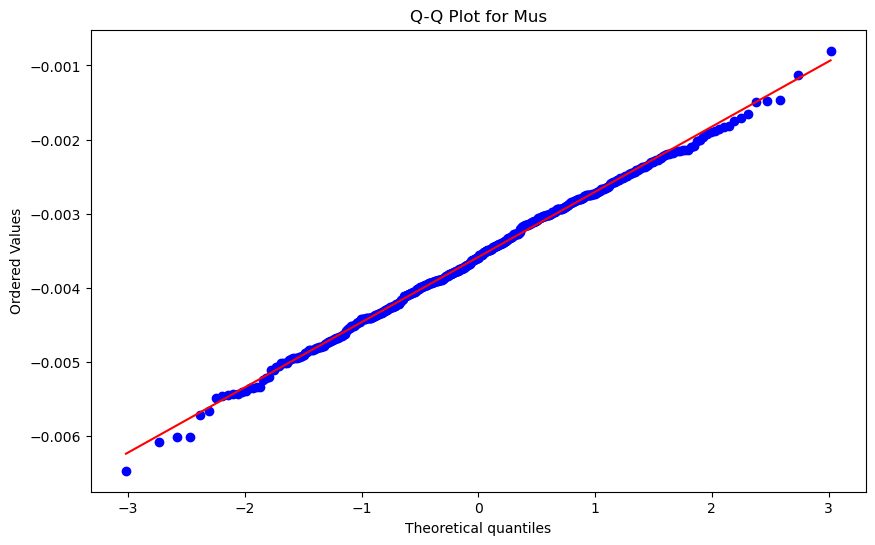

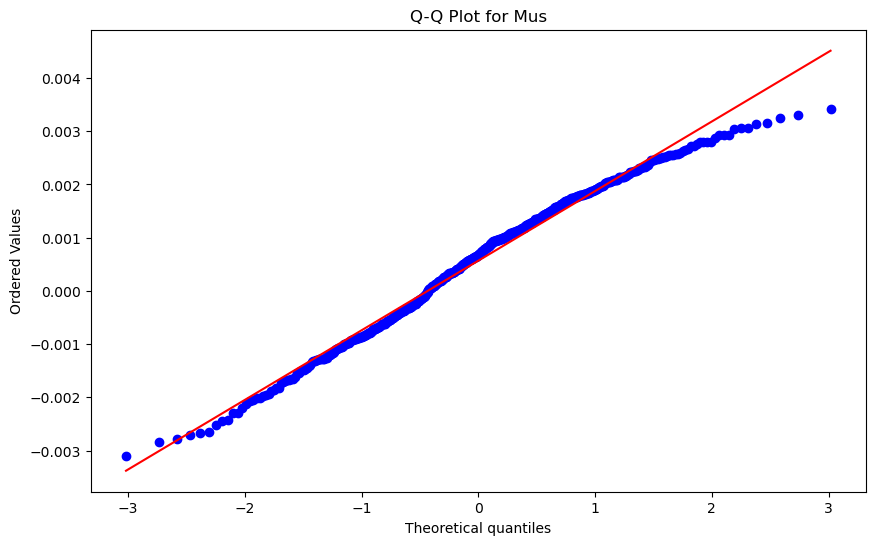

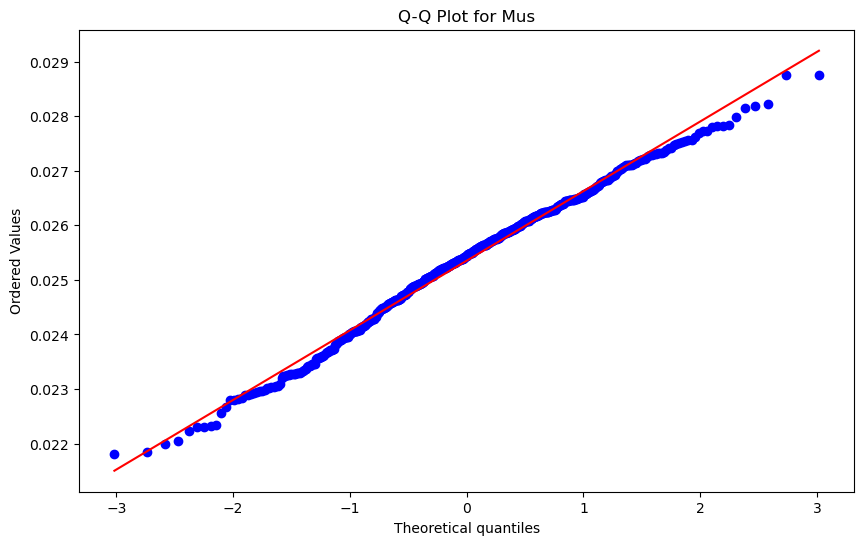

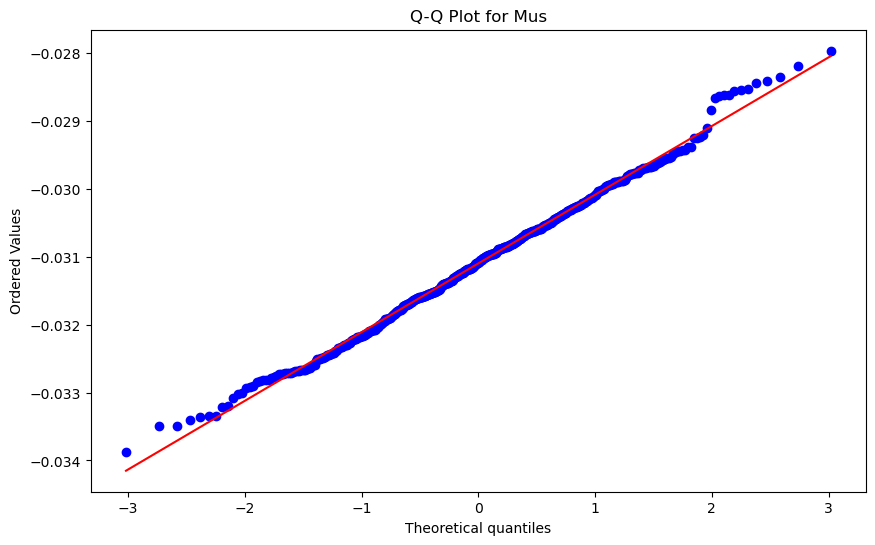

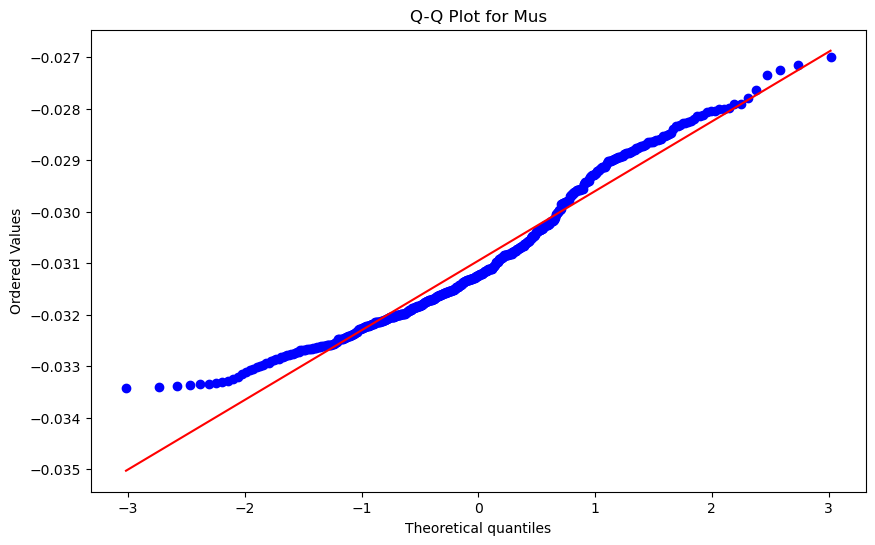

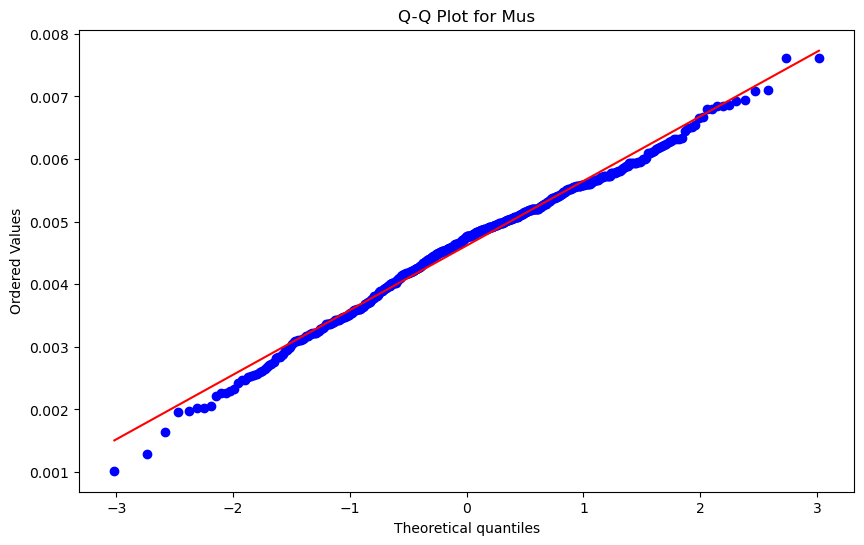

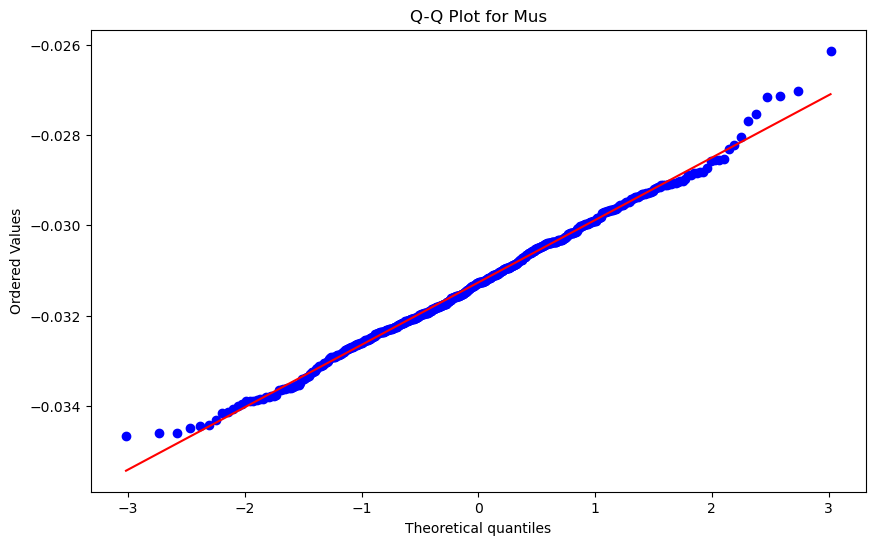

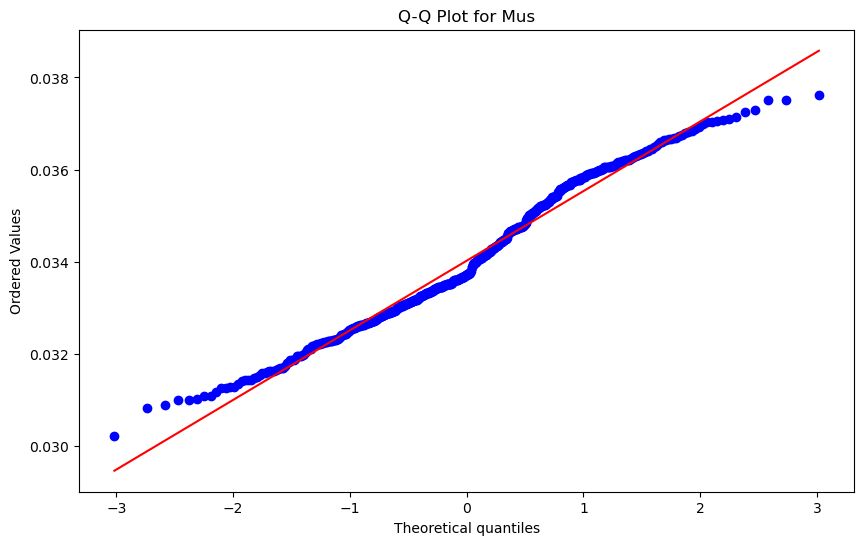

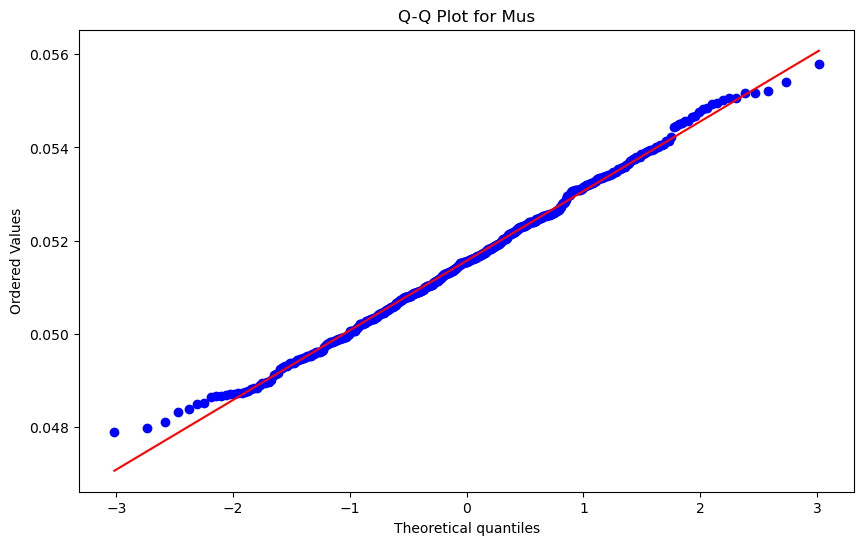

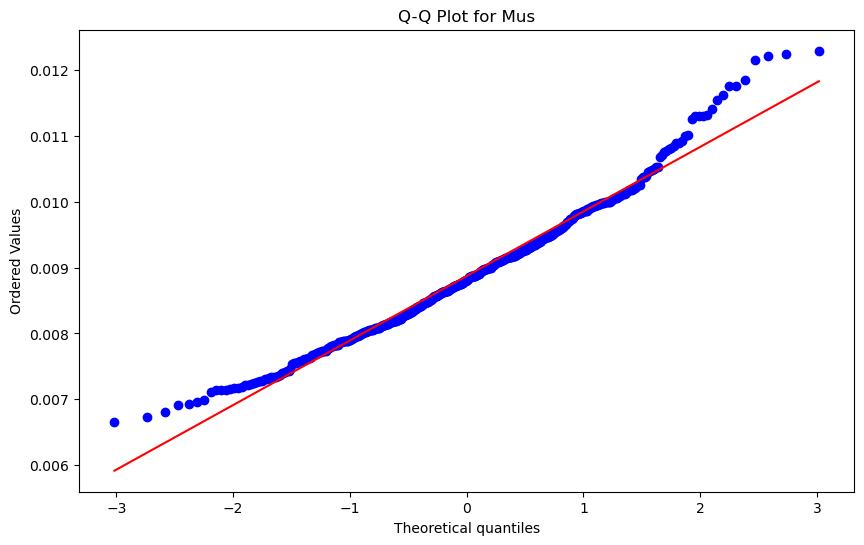

In [54]:
for dim in range(96):
    plot_qq(mus[:,dim], title='Q-Q Plot for Mus')


In [57]:
from scipy.stats import shapiro
normal = 0
for dim in range(96):
    stat, p_value = shapiro(mus[:,dim])
    if p_value > 0.05:
        normal += 1
print("# of normal distributions ",normal)
print("# of not normal distributions ",96-normal)

# of normal distributions  53
# of not normal distributions  43


In [59]:
from scipy.stats import anderson
normal = 0
not_normal = 0
for dim in range(96):
    result = anderson(mus[:,dim], dist='norm')
    if result.statistic < result.critical_values[2]:
        normal += 1
    else:
        not_normal += 1
# Anderson-Darling test
print("# of normal distributions ",normal)
print("# of not normal distributions ",not_normal)

# of normal distributions  53
# of not normal distributions  43


In [68]:
from scipy.stats import norm, entropy
# List of distributions to check
distributions = ['norm', 'expon', 'lognorm']

# Store KLD values
kld_values = {}

# Compute KLD for each distribution
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    kld_values[dist_name] = []
    for i in range(96):
        params = dist.fit(mus[:,i])
        hist, bin_edges = np.histogram(mus[:,i], bins=100, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        fitted_pdf = dist.pdf(bin_centers, *params)
        kld = entropy(hist, fitted_pdf)
        kld_values[dist_name].append(kld)

        # # Plot the fitted PDF
        # plt.plot(bin_centers, fitted_pdf, linewidth=2, label=f'Fitted {dist_name.title()}')


        # plt.title('Sample PDF vs Fitted Distributions')
        # plt.legend()
        # plt.show()
        # plt.clf()

# Print KLD values
for dist_name, kld_value in kld_values.items():
    print(f'Kullback-Leibler Divergence (KLD) to {dist_name} distribution: {kld_value}')


/localscratch/envs/maester_ls/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


Kullback-Leibler Divergence (KLD) to norm distribution: [0.10495345765976859, 0.1630402818548553, 0.12115914340031687, 0.1181419518966643, 0.11678492011659868, 0.0867889521687461, 0.12463027316761113, 0.1332041361993838, 0.09961351971889142, 0.09083205374721766, 0.17204637576177106, 0.09724289143358543, 0.096300667657558, 0.11543540307677645, 0.105273720666478, 0.08655326058239808, 0.11222429572552077, 0.09052286642394847, 0.11267162195826633, 0.10313885220414427, 0.11970036010991703, 0.08446222728237615, 0.09819595911230525, 0.07698178467113784, 0.08996527054213181, 0.11991727729076626, 0.11156803423301337, 0.1107784199765904, 0.09844288290293707, 0.10616857059039128, 0.10414362554463188, 0.08876293323055126, 0.1046633770807419, 0.09166583989464129, 0.09573626031452682, 0.10178448896905784, 0.09945479378524599, 0.08998172588014448, 0.10321580449382486, 0.08186485265587018, 0.10246940974235325, 0.14028662550255933, 0.11116617503970089, 0.08297023700787358, 0.10361947814631695, 0.091897

In [69]:
norm_dist, expo_dist, lognorm_dist = 0, 0, 0
for dim in range(96):
    min_kld = min(kld_values['norm'][dim], kld_values['expon'][dim], kld_values['lognorm'][dim])
    if min_kld == kld_values['norm'][dim]:
        norm_dist += 1
    elif min_kld == kld_values['expon'][dim]:
        expo_dist += 1
    else:
        lognorm_dist += 1
print("# of normal distributions ",norm_dist, " # of exponential distributions ", expo_dist, " # of lognormal distributions ", lognorm_dist)

# of normal distributions  48  # of exponential distributions  0  # of lognormal distributions  48


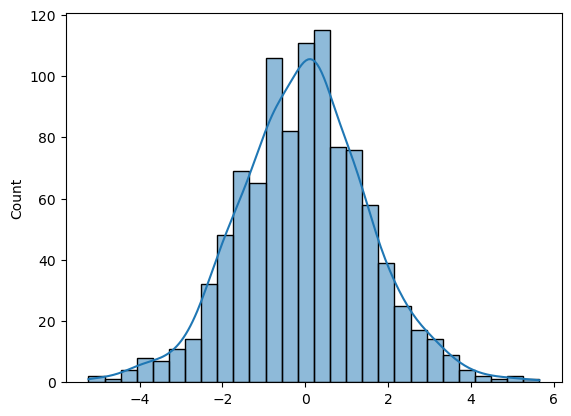

In [25]:
data = np.random.normal(mus[0][0], sigmas[0][0], 1000)
sns.histplot(data, kde=True)
plt.show()

In [20]:
dfs

[          A         B         C
 A       1.0   0.99931  0.999594
 B   0.99931       1.0  0.999032
 C  0.999594  0.999032       1.0,
           A         B        C
 A       1.0  0.999103  0.99969
 B  0.999103       1.0  0.99918
 C   0.99969   0.99918      1.0,
          A         B         C
 A      1.0   0.99971   0.99937
 B  0.99971       1.0  0.999486
 C  0.99937  0.999486       1.0,
           A         B         C
 A       1.0  0.999628  0.999659
 B  0.999628       1.0  0.999666
 C  0.999659  0.999666       1.0,
           A         B         C
 A       1.0  0.999405  0.999504
 B  0.999405       1.0  0.999598
 C  0.999504  0.999598       1.0,
           A         B         C
 A       1.0  0.999147  0.999788
 B  0.999147       1.0  0.999025
 C  0.999788  0.999025       1.0,
           A         B         C
 A       1.0  0.999251   0.99925
 B  0.999251       1.0  0.999314
 C   0.99925  0.999314       1.0,
           A         B         C
 A       1.0  0.999292  0.999651
 B  0.99929

In [14]:
averages = pd.concat([each.stack() for each in dfs],axis=1)\
             .apply(lambda x:x.mean(),axis=1)\
             .unstack()
averages

A         B         C
A  1.000000  0.997234  0.999583
B  0.997234  1.000000  0.997467
C  0.999583  0.997467  1.000000

In [70]:
sample_size = 100000
sampled_data = combined_data.sample(n=sample_size, random_state=42)


In [102]:

correlation_matrix = combined_data.corr()

In [103]:
correlation_matrix

0         1         2         3         4         5         6   \
0   1.000000  0.185805 -0.583135  0.245676 -0.181062 -0.214505 -0.179222   
1   0.185805  1.000000 -0.617155 -0.173833  0.126045 -0.405635 -0.781674   
2  -0.583135 -0.617155  1.000000 -0.023524  0.159322  0.281193  0.443327   
3   0.245676 -0.173833 -0.023524  1.000000 -0.584817  0.239358  0.348901   
4  -0.181062  0.126045  0.159322 -0.584817  1.000000 -0.100574 -0.259121   
..       ...       ...       ...       ...       ...       ...       ...   
91       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
92       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
93       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
94       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
95       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

          7         8         9   ...        86        87        88        89  \
0   0.328396  0.701904 -0.161890  ...       NaN       NaN       NaN       NaN   
1  -0.092635  0.308046  0.090251  ...       NaN       NaN       NaN       NaN   
2  -0.109297 -0.714043  0.225262  ...       NaN       NaN       NaN       NaN   
3  -0.277190  0.295670 -0.702844  ...       NaN       NaN       NaN       NaN   
4   0.118752 -0.459075  0.571192  ...       NaN       NaN       NaN       NaN   
..       ...       ...       ...  ...       ...       ...       ...       ...   
91       NaN       NaN       NaN  ... -0.181279 -0.214952  0.225548  0.377686   
92       NaN       NaN       NaN  ... -0.583798  0.148945  0.173293  0.255762   
93       NaN       NaN       NaN  ...  0.013637  0.254556 -0.075362  0.055183   
94       NaN       NaN       NaN  ... -0.197933 -0.359813  0.380815  0.519537   
95       NaN       NaN       NaN  ...  0.468595 -0.122996 -0.255268 -0.284507   

          90        91        92        93        94        95  
0        NaN       NaN       NaN       NaN       NaN       NaN  
1        NaN       NaN       NaN       NaN       NaN       NaN  
2        NaN       NaN       NaN       NaN       NaN       NaN  
3        NaN       NaN       NaN       NaN       NaN       NaN  
4        NaN       NaN       NaN       NaN       NaN       NaN  
..       ...       ...       ...       ...       ...       ...  
91 -0.113931  1.000000 -0.237129 -0.053367 -0.030750 -0.103379  
92 -0.417015 -0.237129  1.000000 -0.246313 -0.004331 -0.701285  
93 -0.017907 -0.053367 -0.246313  1.000000 -0.191616  0.096517  
94  0.049035 -0.030750 -0.004331 -0.191616  1.000000  0.321215  
95  0.412376 -0.103379 -0.701285  0.096517  0.321215  1.000000  

[288 rows x 288 columns]

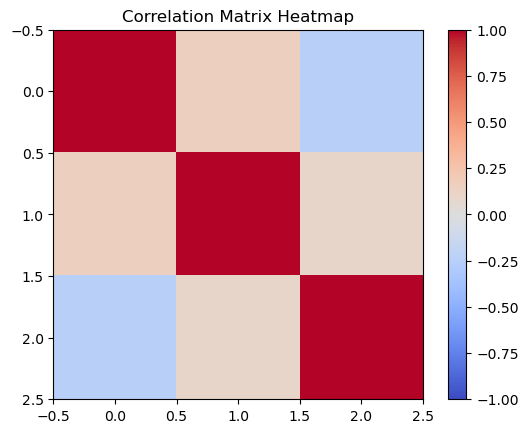

In [ ]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix Heatmap')
# plt.xlabel('Variables')
# plt.ylabel('Variables')
# plt.show()
plt.imshow(averages, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix Heatmap')
plt.show()

In [4]:
def clustering(mu):
    slice_features_mu = mu.astype(float)
    feature_flatten_mu = slice_features_mu.reshape(160, -1).T
    K_CENTRE = 4
    kmeans_mu = KMeans(
        n_clusters=K_CENTRE, init='k-means++', n_init=10,
        max_iter=1000, random_state=777
    )
    kmeans_mu.fit(feature_flatten_mu)
    labels_mu = kmeans_mu.predict(feature_flatten_mu)
    return labels_mu

In [5]:
def get_normalized_tensor(img,model,device):
    '''
    Normalizes tensor with mean and std.
    Parameters
    ----------
    img: array
        Image.
    model: Hierarchical DivNoising model
    device: GPU device.
    '''
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images

In [6]:
# for 4x4
def make_tiled(img):
    out = np.zeros([img.shape[0]+61, img.shape[1]+60])
    # make mirror margin of 2d image
    for i in range(30):
        out[i,30:30+img.shape[1]] = img[30-i-1,:]
        out[30:30+img.shape[0],30:30+img.shape[1]] = img
        out[30+img.shape[0]+i,30:30+img.shape[1]] = img[img.shape[0]-i-1,:]
    out[img.shape[0]+60,30:30+img.shape[1]] = img[img.shape[0]-31,:]
    for i in range(30):
        out[:,i] = out[:,60-i-1]
        out[:, 30+img.shape[1]+i] = out[:, 30+img.shape[1]-i-1]
    return out
    

In [7]:
# for 2x2
def make_tiled_x(img):
    out = np.zeros([img.shape[0]+63, img.shape[1]+62])
    # make mirror margin of 2d image
    for i in range(31):
        out[i,31:31+img.shape[1]] = img[31-i-1,:]
        out[31:31+img.shape[0],31:31+img.shape[1]] = img
        out[31+img.shape[0]+i,31:31+img.shape[1]] = img[img.shape[0]-i-1,:]
    out[img.shape[0]+62,31:31+img.shape[1]] = img[img.shape[0]-32,:]
    for i in range(31):
        out[:,i] = out[:,62-i-1]
        out[:, 31+img.shape[1]+i] = out[:, 31+img.shape[1]-i-1]
    return out

In [11]:
# img = imread(path+"data/test/high_c1_source_31.tif")
img = imread("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif")
tiled = make_tiled(img)
img_height,img_width = 700,760
img = get_normalized_tensor(tiled,model,device)
output = np.zeros((32, 700, 760))
for i in tqdm(range(0, img_height, 4)):
    for j in range(0, img_width, 4):
# for i in tqdm(range(0, img_height, 2)):
#     for j in range(0, img_width, 2):
        img_t = img[i:i+64,j:j+64]
        # if img_t.shape != (64,64):
        #     print(img_t.shape)
        image_sample = img_t.view(1,1,64,64)
        image_sample = image_sample.to(device=device, dtype=torch.float)
        with torch.no_grad():
            sample = model(image_sample, y=image_sample)
            mus = sample['mu']
            output[:32,i:i+4,j:j+4] = sample['mu'][0][0].cpu().numpy()[:,14:18,14:18]
            # output[32:64,i:i+4,j:j+4] = sample['mu'][1][0].cpu().numpy()[:,6:10,6:10]
            # output[64:96,i:i+4,j:j+4] = sample['mu'][2][0].cpu().numpy()[:,2:6,2:6]
            # output[96:128,i:i+4,j:j+4] = sample['mu'][3][0].cpu().numpy()
            # output[128:160,i:i+4,j:j+4] = sample['mu'][4][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)
            # output[:32,i:i+2,j:j+2] = sample['mu'][0][0].cpu().numpy()[:,15:17,15:17]
            # output[32:64,i:i+2,j:j+2] = sample['mu'][1][0].cpu().numpy()[:,7:9,7:9]
            # output[64:96,i:i+2,j:j+2] = sample['mu'][2][0].cpu().numpy()[:,3:5,3:5]
            # output[96:128,i:i+2,j:j+2] = sample['mu'][3][0].cpu().numpy()[:,1:3,1:3]
            # output[128:160,i:i+2,j:j+2] = sample['mu'][4][0].cpu().numpy()


100%|██████████| 175/175 [28:42<00:00,  9.84s/it]


In [8]:
np.save("/group/jug/Sheida/HDN_models/27022024/Contrastive_False/imgs/output_187.npy", output)

In [24]:
output = np.load("/group/jug/Sheida/HDN_models/27022024/Contrastive_False/imgs/output_187.npy")

In [31]:
clusters = clustering(output)

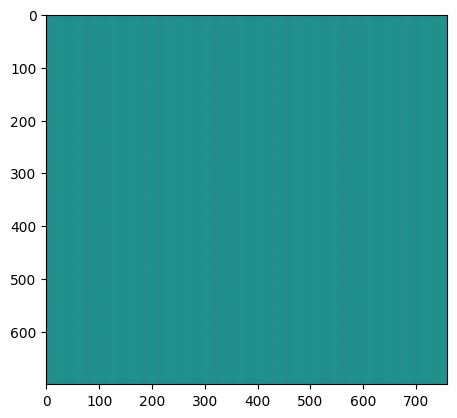

In [32]:
# imwrite("/group/jug/Sheida/HDN_models/27022024/Contrastive_False/imgs/187_8_cluster.tif", clusters.reshape(700, 760))
plt.imshow(clusters.reshape(700, 760))
plt.show()

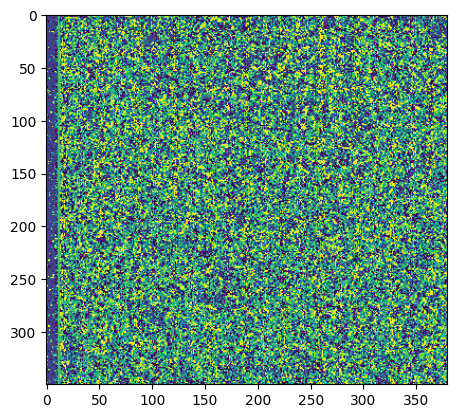

In [21]:
# imwrite("/group/jug/Sheida/HDN_models/22022024/Trained_model_3/imgs/187_8_cluster_downscale_2.tif", clusters.reshape(700, 760)[::2,::2])
plt.imshow(clusters.reshape(700, 760)[::2,::2])
plt.show()

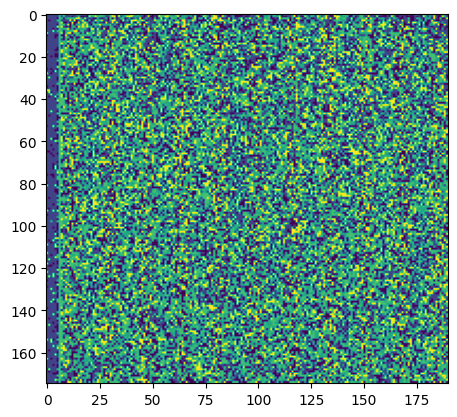

In [22]:
# imwrite("/group/jug/Sheida/HDN_models/22022024/Trained_model_3/imgs/187_8_cluster_downscale_4.tif", clusters.reshape(700, 760)[::4,::4])
plt.imshow(clusters.reshape(700, 760)[::4,::4])
plt.show()

In [33]:
def clustering_down_scale(index, mu):
    slice_features_mu = mu.astype(float)
    feature_flatten_mu = slice_features_mu.reshape(32, -1).T
    K_CENTRE = 8
    kmeans_mu = KMeans(
        n_clusters=K_CENTRE, init='k-means++', n_init=10,
        max_iter=1000, random_state=777
    )
    kmeans_mu.fit(feature_flatten_mu)
    labels_mu = kmeans_mu.predict(feature_flatten_mu)
    return labels_mu

(160, 768, 704)
(32, 352, 384)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif


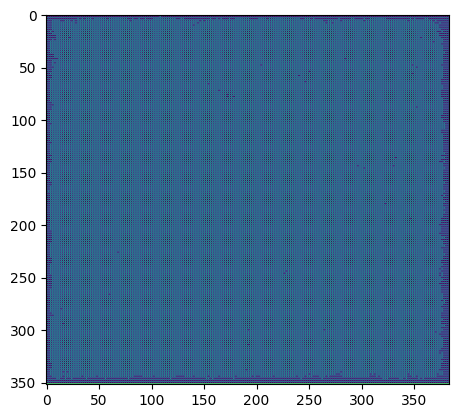

(32, 176, 192)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif


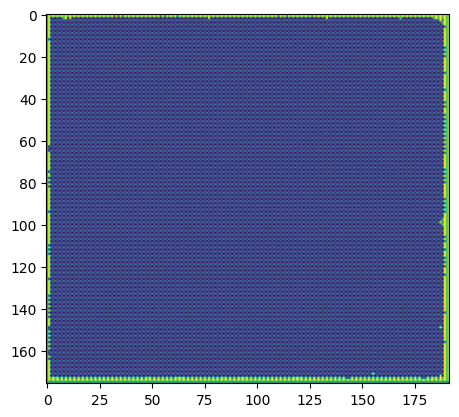

(32, 88, 96)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif


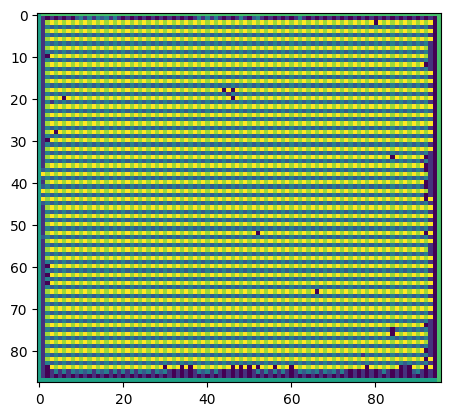

(32, 44, 48)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif


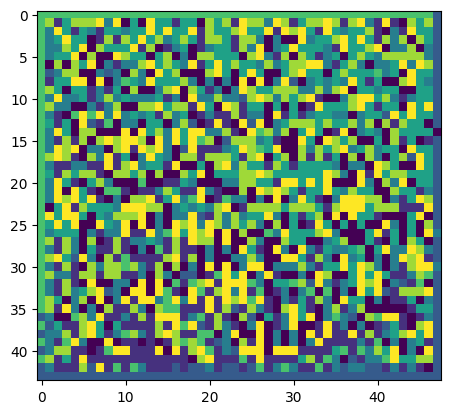

(32, 22, 24)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif


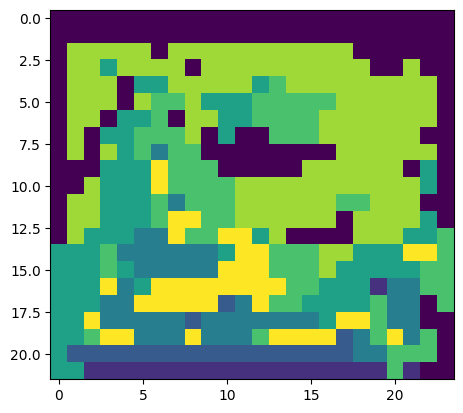

In [34]:
files = glob("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif")
img_height,img_width = 699, 760
for i in files:
    img = imread(i)
    img_t = get_normalized_tensor(img,model,device)
    image_sample = img_t.view(1,1,img_height,img_width)
    image_sample = image_sample.to(device=device, dtype=torch.float)
    with torch.no_grad():
        sample = model(image_sample, image_sample)
        mus = sample['mu']
        output = np.zeros((160, 768, 704))

        print(output.shape)

        for idx in range(len(sample['mu'])):
            mu = sample['mu'][idx][0].cpu().numpy()
            print(mu.shape)
            output = clustering_down_scale(idx, mu)
            print(i)
            imwrite("/group/jug/Sheida/HDN_models/27022024/Contrastive_False/imgs/187_"+str(idx)+".tif", output.reshape(22*(2**(4-idx)), 24*(2**(4-idx))))
            plt.imshow(output.reshape(22*(2**(4-idx)), 24*(2**(4-idx))))
            plt.show()

input:  Normal(loc: torch.Size([5]), scale: torch.Size([5])) 
target:  Normal(loc: torch.Size([5]), scale: torch.Size([5])) 
output:  tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250])
tensor(0.6250)


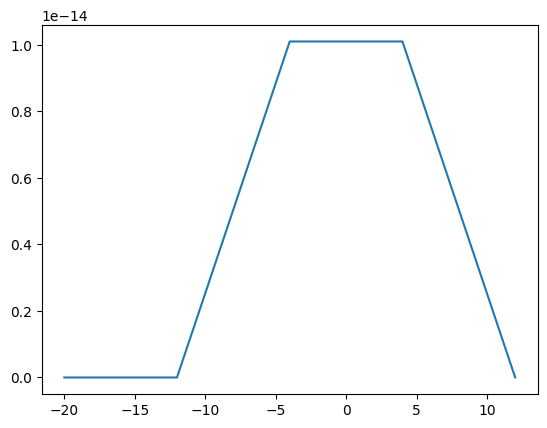

In [7]:
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import torch
import numpy as np
from scipy.stats import norm 
from torch.distributions import kl_divergence
from torch.distributions.normal import Normal

input = Normal(torch.tensor([0 for i in range(5)]), torch.tensor([1 for i in range(5)]))
target = Normal(torch.tensor([0.5 for i in range(5)]), torch.tensor([1 for i in range(5)]))
output = kl_divergence(input, target)
print("input: ",input,"\ntarget: ",target,"\noutput: ",output)
print(torch.sum(output))
plt.plot(np.arange(-20,20,8), norm.pdf(np.arange(-20,20,8), [0 for i in range(5)], [0.5 for i in range(5)]))
plt.show()